In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import gc
warnings.filterwarnings('ignore')
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import (train_test_split, StratifiedKFold, GroupKFold, cross_val_score, GridSearchCV, RandomizedSearchCV)
from sklearn.experimental import enable_halving_search_cv  
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.preprocessing import OrdinalEncoder
import optuna
from sklearn.datasets import fetch_california_housing
pd.set_option('display.max_columns', None)

# Import Data

In [4]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()


In [5]:
train_df.drop(columns=['Unnamed: 0'], inplace=True)
train_df.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,DeviceType,device_name,browser_id_31,weekday,hour,month,ProductCD_C_Day,ProductCD_R_Day,ProductCD_H_Day,ProductCD_S_Day,open_card,uid1,device_hash,uid_device_nunique,device_uid_nunique,D1_revised,D2_revised,D4_revised,D10_revised,D11_revised,D15_revised,D3_revised,D5_revised,email_domain_match,P_emaildomain_count,R_emaildomain_count,id_01_uid1_mean,id_01_uid1_std,id_02_uid1_mean,id_02_uid1_std,id_03_uid1_mean,id_03_uid1_std,id_04_uid1_mean,id_04_uid1_std,id_05_uid1_mean,id_05_uid1_std,id_06_uid1_mean,id_06_uid1_std,id_07_uid1_mean,id_07_uid1_std,id_08_uid1_mean,id_08_uid1_std,id_09_uid1_mean,id_09_uid1_std,id_10_uid1_mean,id_10_uid1_std,id_11_uid1_mean,id_11_uid1_std,id_13_uid1_mean,id_13_uid1_std,id_17_uid1_mean,id_17_uid1_std,id_18_uid1_mean,id_18_uid1_std,id_19_uid1_mean,id_19_uid1_std,id_20_uid1_mean,id_20_uid1_std,id_21_uid1_mean,id_21_uid1_std,id_22_uid1_mean,id_22_uid1_std,id_24_uid1_mean,id_24_uid1_std,id_25_uid1_mean,id_25_uid1_std,id_26_uid1_mean,id_26_uid1_std,id_32_uid1_mean,id_32_uid1_std,id_12_count_enc,id_15_count_enc,id_16_count_enc,id_28_count_enc,id_29_count_enc,id_31_count_enc,id_35_count_enc,id_36_count_enc,id_37_count_enc,id_38_count_enc,card1_addr1,card1_addr1_P_emaildomain,card1_addr1_FE,card1_addr1_P_emaildomain_FE,TransactionAmt_card1_mean,TransactionAmt_card1_std,TransactionAmt_card1_addr1_mean,TransactionAmt_card1_addr1_std,TransactionAmt_card1_addr1_P_emaildomain_mean,TransactionAmt_card1_addr1_P_emaildomain_std,D9_card1_mean,D9_card1_std,D9_card1_addr1_mean,D9_card1_addr1_std,D9_card1_addr1_P_emaildomain_mean,D9_card1_addr1_P_emaildomain_std,D11_card1_mean,D11_card1_std,D11_card1_addr1_mean,D11_card1_addr1_std,D11_card1_addr1_P_emaildomain_mean,D11_card1_addr1_P_emaildomain_std,card2_FE,card3_target_enc,card3_FE,card4_discover,card4_mastercard,card4_visa,card5_target_enc,card6_credit,card6_debit,day_count,hour_count,ProductID,TransactionAmt__ProductCD_count
0,0,2017-12-02 00:00:00,68.5,W,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0

In [6]:
test_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.head()

,TransactionDT,TransactionAmt,ProductCD,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,DeviceType,device_name,browser_id_31,weekday,hour,month,ProductCD_C_Day,ProductCD_R_Day,ProductCD_H_Day,ProductCD_S_Day,open_card,uid1,device_hash,uid_device_nunique,device_uid_nunique,D1_revised,D2_revised,D4_revised,D10_revised,D11_revised,D15_revised,D3_revised,D5_revised,email_domain_match,P_emaildomain_count,R_emaildomain_count,id_01_uid1_mean,id_01_uid1_std,id_02_uid1_mean,id_02_uid1_std,id_03_uid1_mean,id_03_uid1_std,id_04_uid1_mean,id_04_uid1_std,id_05_uid1_mean,id_05_uid1_std,id_06_uid1_mean,id_06_uid1_std,id_07_uid1_mean,id_07_uid1_std,id_08_uid1_mean,id_08_uid1_std,id_09_uid1_mean,id_09_uid1_std,id_10_uid1_mean,id_10_uid1_std,id_11_uid1_mean,id_11_uid1_std,id_13_uid1_mean,id_13_uid1_std,id_17_uid1_mean,id_17_uid1_std,id_18_uid1_mean,id_18_uid1_std,id_19_uid1_mean,id_19_uid1_std,id_20_uid1_mean,id_20_uid1_std,id_21_uid1_mean,id_21_uid1_std,id_22_uid1_mean,id_22_uid1_std,id_24_uid1_mean,id_24_uid1_std,id_25_uid1_mean,id_25_uid1_std,id_26_uid1_mean,id_26_uid1_std,id_32_uid1_mean,id_32_uid1_std,id_12_count_enc,id_15_count_enc,id_16_count_enc,id_28_count_enc,id_29_count_enc,id_31_count_enc,id_35_count_enc,id_36_count_enc,id_37_count_enc,id_38_count_enc,card1_addr1,card1_addr1_P_emaildomain,card1_addr1_FE,card1_addr1_P_emaildomain_FE,TransactionAmt_card1_mean,TransactionAmt_card1_std,TransactionAmt_card1_addr1_mean,TransactionAmt_card1_addr1_std,TransactionAmt_card1_addr1_P_emaildomain_mean,TransactionAmt_card1_addr1_P_emaildomain_std,D9_card1_mean,D9_card1_std,D9_card1_addr1_mean,D9_card1_addr1_std,D9_card1_addr1_P_emaildomain_mean,D9_card1_addr1_P_emaildomain_std,D11_card1_mean,D11_card1_std,D11_card1_addr1_mean,D11_card1_addr1_std,D11_card1_addr1_P_emaildomain_mean,D11_card1_addr1_P_emaildomain_std,card2_FE,card3_target_enc,card3_FE,card4_discover,card4_mastercard,card4_visa,card5_target_enc,card6_credit,card6_debit,day_count,hour_count,ProductID,TransactionAmt__ProductCD_count
0,2018-07-02 00:00:24,31.95,W,170.0,87.0,1.0,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

In [7]:
train_df.drop(columns=['TransactionDT'], inplace=True)
test_df.drop(columns=['TransactionDT'], inplace=True)
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

# XGboost

In [7]:
train_df = train_df_copy
test_df = test_df_copy

In [8]:
# Identify Categorical FEatures 
cat_features = [
    'ProductCD', 'card4', 'card6', 'DeviceType', 'browser_id_31', 'email_domain_match', 'R_emaildomain_count', 
    'P_emaildomain_count', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9',   
    'ProductID', 'uid1', 'device_name', 'device_hash', 'card3_target_enc', 
    'card1_addr1_P_emaildomain', 'card1_addr1_FE', 'card1_addr1_P_emaildomain_FE', 
    'open_card', 'card2_FE', 'card3_FE', 'card4_visa', 'card4_mastercard'
]

object_columns = train_df.select_dtypes(include=['object','category']).columns.tolist()
potential_categorical = [col for col in train_df.select_dtypes(include=['int64', 'float64']).columns 
                         if train_df[col].nunique() < 60]
cat_features = cat_features + object_columns + potential_categorical
if 'isFraud' in cat_features:
    cat_features.remove('isFraud')

id_columns = ["id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", "id_30", "id_31", "id_33", "id_34"]
cat_features += [col for col in id_columns if col in train_df.columns]
card_columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
cat_features = list(set(cat_features))
cat_features = [col for col in cat_features if col in train_df.columns]

remaining_features = [col for col in train_df.columns if col not in cat_features]
if 'isFraud' in remaining_features:
    remaining_features.remove('isFraud')

# Convert categorical variables to category type
for col in cat_features:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [9]:
# Define train and validation sets
X = train_df.drop(columns=["isFraud"])
y = train_df["isFraud"]

groups = train_df["uid1"]   
gkf = GroupKFold(n_splits=3)

# Ensure cat_features only includes columns that exist in X_train
cat_features = [col for col in cat_features if col in X.columns]

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fix high-cardinality categorical features
high_cardinality_cols = [col for col in cat_features if X_train[col].nunique() > 200]

# Use Ordinal Encoding to handle unseen values in X_valid
if high_cardinality_cols:
    print(f"Encoding high-cardinality features: {high_cardinality_cols}")
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train[high_cardinality_cols] = ordinal_enc.fit_transform(X_train[high_cardinality_cols])
    X_valid[high_cardinality_cols] = ordinal_enc.transform(X_valid[high_cardinality_cols])  

# Convert remaining categorical columns to `category` type for LightGBM
for col in cat_features:
    if col not in high_cardinality_cols:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


In [19]:
raw_scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight = min(10, raw_scale_pos_weight ** 0.5)

def optuna_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1000, 8000)
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': scale_pos_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'gpu_hist',
        'verbosity': 0
    }
    
    gkf = GroupKFold(n_splits=3)
    auc_scores = []
    for train_idx, valid_idx in gkf.split(X, y, groups):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        high_cardinality_cols = [col for col in cat_features if X_train[col].nunique() > 200]
        if high_cardinality_cols:
            print(f"Encoding high-cardinality features: {high_cardinality_cols}")
            ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            X_train[high_cardinality_cols] = ordinal_enc.fit_transform(X_train[high_cardinality_cols])
            X_valid[high_cardinality_cols] = ordinal_enc.transform(X_valid[high_cardinality_cols])
        
        # For XGBoost, we need to handle categorical features differently
        for col in cat_features:
            if col not in high_cardinality_cols:
                # Convert categorical features to integer codes
                X_train[col] = X_train[col].astype('category').cat.codes
                X_valid[col] = X_valid[col].astype('category').cat.codes
        
        # Create DMatrix objects
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        
        # Alternative way to fit the model using train() method with early_stopping_rounds
        watchlist = [(dvalid, 'eval')]
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=n_estimators,
            evals=watchlist,
            early_stopping_rounds=400,
            verbose_eval=False
        )
        
        # Make predictions
        y_pred = model.predict(dvalid)
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)
    
    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: AUC = {mean_auc:.4f} | Params: {params}")
    return mean_auc

study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=30)
print("\nBest AUC:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-03-06 15:37:18,194] A new study created in memory with name: no-name-01e9e7d5-b953-4085-a8b0-19de939ac0c3


Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:38:48,585] Trial 0 finished with value: 0.8666788136354627 and parameters: {'n_estimators': 5504, 'learning_rate': 0.05837885204704379, 'max_depth': 7, 'subsample': 0.8069169461170477, 'colsample_bytree': 0.6146227658587564}. Best is trial 0 with value: 0.8666788136354627.


Trial 0: AUC = 0.8667 | Params: {'learning_rate': 0.05837885204704379, 'max_depth': 7, 'subsample': 0.8069169461170477, 'colsample_bytree': 0.6146227658587564, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:40:32,817] Trial 1 finished with value: 0.8574943190026828 and parameters: {'n_estimators': 6772, 'learning_rate': 0.06075939206881484, 'max_depth': 9, 'subsample': 0.8993225058491319, 'colsample_bytree': 0.8510548119787118}. Best is trial 0 with value: 0.8666788136354627.


Trial 1: AUC = 0.8575 | Params: {'learning_rate': 0.06075939206881484, 'max_depth': 9, 'subsample': 0.8993225058491319, 'colsample_bytree': 0.8510548119787118, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:42:27,630] Trial 2 finished with value: 0.8543148522616791 and parameters: {'n_estimators': 2530, 'learning_rate': 0.04470595691423575, 'max_depth': 10, 'subsample': 0.9947780794674619, 'colsample_bytree': 0.6611581912063675}. Best is trial 0 with value: 0.8666788136354627.


Trial 2: AUC = 0.8543 | Params: {'learning_rate': 0.04470595691423575, 'max_depth': 10, 'subsample': 0.9947780794674619, 'colsample_bytree': 0.6611581912063675, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:44:11,234] Trial 3 finished with value: 0.8542697503916211 and parameters: {'n_estimators': 7845, 'learning_rate': 0.08583837087286392, 'max_depth': 9, 'subsample': 0.5157610101567949, 'colsample_bytree': 0.7672150003675517}. Best is trial 0 with value: 0.8666788136354627.


Trial 3: AUC = 0.8543 | Params: {'learning_rate': 0.08583837087286392, 'max_depth': 9, 'subsample': 0.5157610101567949, 'colsample_bytree': 0.7672150003675517, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:46:14,261] Trial 4 finished with value: 0.8754852681663469 and parameters: {'n_estimators': 3315, 'learning_rate': 0.020035909151040317, 'max_depth': 8, 'subsample': 0.7140414931416603, 'colsample_bytree': 0.7296872907119447}. Best is trial 4 with value: 0.8754852681663469.


Trial 4: AUC = 0.8755 | Params: {'learning_rate': 0.020035909151040317, 'max_depth': 8, 'subsample': 0.7140414931416603, 'colsample_bytree': 0.7296872907119447, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:47:47,576] Trial 5 finished with value: 0.870746010584656 and parameters: {'n_estimators': 1395, 'learning_rate': 0.04727938039567781, 'max_depth': 6, 'subsample': 0.5382994079019169, 'colsample_bytree': 0.5252027820933549}. Best is trial 4 with value: 0.8754852681663469.


Trial 5: AUC = 0.8707 | Params: {'learning_rate': 0.04727938039567781, 'max_depth': 6, 'subsample': 0.5382994079019169, 'colsample_bytree': 0.5252027820933549, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:49:10,577] Trial 6 finished with value: 0.8640276159433972 and parameters: {'n_estimators': 3027, 'learning_rate': 0.09497706951748357, 'max_depth': 6, 'subsample': 0.7233443246012812, 'colsample_bytree': 0.5816061136285191}. Best is trial 4 with value: 0.8754852681663469.


Trial 6: AUC = 0.8640 | Params: {'learning_rate': 0.09497706951748357, 'max_depth': 6, 'subsample': 0.7233443246012812, 'colsample_bytree': 0.5816061136285191, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:50:33,450] Trial 7 finished with value: 0.8610694926402336 and parameters: {'n_estimators': 5924, 'learning_rate': 0.07509764108432339, 'max_depth': 7, 'subsample': 0.9807213055401633, 'colsample_bytree': 0.814651749950625}. Best is trial 4 with value: 0.8754852681663469.


Trial 7: AUC = 0.8611 | Params: {'learning_rate': 0.07509764108432339, 'max_depth': 7, 'subsample': 0.9807213055401633, 'colsample_bytree': 0.814651749950625, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:52:51,204] Trial 8 finished with value: 0.864556433975158 and parameters: {'n_estimators': 1248, 'learning_rate': 0.02846770513710843, 'max_depth': 10, 'subsample': 0.6531365825579736, 'colsample_bytree': 0.7884877727675197}. Best is trial 4 with value: 0.8754852681663469.


Trial 8: AUC = 0.8646 | Params: {'learning_rate': 0.02846770513710843, 'max_depth': 10, 'subsample': 0.6531365825579736, 'colsample_bytree': 0.7884877727675197, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:54:48,864] Trial 9 finished with value: 0.8606904343969554 and parameters: {'n_estimators': 7651, 'learning_rate': 0.08766906275609312, 'max_depth': 10, 'subsample': 0.5734338179851463, 'colsample_bytree': 0.8536392670903382}. Best is trial 4 with value: 0.8754852681663469.


Trial 9: AUC = 0.8607 | Params: {'learning_rate': 0.08766906275609312, 'max_depth': 10, 'subsample': 0.5734338179851463, 'colsample_bytree': 0.8536392670903382, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:57:20,261] Trial 10 finished with value: 0.878780070779551 and parameters: {'n_estimators': 4100, 'learning_rate': 0.011071767261408695, 'max_depth': 8, 'subsample': 0.801850338579544, 'colsample_bytree': 0.9569574941517915}. Best is trial 10 with value: 0.878780070779551.


Trial 10: AUC = 0.8788 | Params: {'learning_rate': 0.011071767261408695, 'max_depth': 8, 'subsample': 0.801850338579544, 'colsample_bytree': 0.9569574941517915, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 15:59:17,068] Trial 11 finished with value: 0.8730920426795558 and parameters: {'n_estimators': 3972, 'learning_rate': 0.021446502412237462, 'max_depth': 8, 'subsample': 0.8015304044177505, 'colsample_bytree': 0.9813572814620218}. Best is trial 10 with value: 0.878780070779551.


Trial 11: AUC = 0.8731 | Params: {'learning_rate': 0.021446502412237462, 'max_depth': 8, 'subsample': 0.8015304044177505, 'colsample_bytree': 0.9813572814620218, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:01:47,428] Trial 12 finished with value: 0.8795072646816422 and parameters: {'n_estimators': 4261, 'learning_rate': 0.011196236688270545, 'max_depth': 8, 'subsample': 0.6872850457218194, 'colsample_bytree': 0.991001372990398}. Best is trial 12 with value: 0.8795072646816422.


Trial 12: AUC = 0.8795 | Params: {'learning_rate': 0.011196236688270545, 'max_depth': 8, 'subsample': 0.6872850457218194, 'colsample_bytree': 0.991001372990398, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:04:10,376] Trial 13 finished with value: 0.881630076126017 and parameters: {'n_estimators': 4937, 'learning_rate': 0.010663577953955117, 'max_depth': 7, 'subsample': 0.6392954903520531, 'colsample_bytree': 0.997938578090932}. Best is trial 13 with value: 0.881630076126017.


Trial 13: AUC = 0.8816 | Params: {'learning_rate': 0.010663577953955117, 'max_depth': 7, 'subsample': 0.6392954903520531, 'colsample_bytree': 0.997938578090932, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:05:50,621] Trial 14 finished with value: 0.8720822980758919 and parameters: {'n_estimators': 5406, 'learning_rate': 0.03637495147143392, 'max_depth': 7, 'subsample': 0.6225433988793191, 'colsample_bytree': 0.9095107316371785}. Best is trial 13 with value: 0.881630076126017.


Trial 14: AUC = 0.8721 | Params: {'learning_rate': 0.03637495147143392, 'max_depth': 7, 'subsample': 0.6225433988793191, 'colsample_bytree': 0.9095107316371785, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:08:12,038] Trial 15 finished with value: 0.8808584976891849 and parameters: {'n_estimators': 4651, 'learning_rate': 0.012860070244915619, 'max_depth': 7, 'subsample': 0.6633570421623279, 'colsample_bytree': 0.923962993695925}. Best is trial 13 with value: 0.881630076126017.


Trial 15: AUC = 0.8809 | Params: {'learning_rate': 0.012860070244915619, 'max_depth': 7, 'subsample': 0.6633570421623279, 'colsample_bytree': 0.923962993695925, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:09:53,447] Trial 16 finished with value: 0.8738170399685048 and parameters: {'n_estimators': 5055, 'learning_rate': 0.03245000116114578, 'max_depth': 7, 'subsample': 0.6009079696593497, 'colsample_bytree': 0.9058820097997686}. Best is trial 13 with value: 0.881630076126017.


Trial 16: AUC = 0.8738 | Params: {'learning_rate': 0.03245000116114578, 'max_depth': 7, 'subsample': 0.6009079696593497, 'colsample_bytree': 0.9058820097997686, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:11:56,052] Trial 17 finished with value: 0.8801700548361212 and parameters: {'n_estimators': 6161, 'learning_rate': 0.02177822764588348, 'max_depth': 6, 'subsample': 0.6498639428626437, 'colsample_bytree': 0.9206096330509651}. Best is trial 13 with value: 0.881630076126017.


Trial 17: AUC = 0.8802 | Params: {'learning_rate': 0.02177822764588348, 'max_depth': 6, 'subsample': 0.6498639428626437, 'colsample_bytree': 0.9206096330509651, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:13:36,295] Trial 18 finished with value: 0.8694537730933729 and parameters: {'n_estimators': 4764, 'learning_rate': 0.041667694830261434, 'max_depth': 7, 'subsample': 0.7610841796462057, 'colsample_bytree': 0.8658975197756579}. Best is trial 13 with value: 0.881630076126017.


Trial 18: AUC = 0.8695 | Params: {'learning_rate': 0.041667694830261434, 'max_depth': 7, 'subsample': 0.7610841796462057, 'colsample_bytree': 0.8658975197756579, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:15:02,223] Trial 19 finished with value: 0.8694471326606745 and parameters: {'n_estimators': 6712, 'learning_rate': 0.06663068604544772, 'max_depth': 6, 'subsample': 0.5635909823637443, 'colsample_bytree': 0.9983530611146614}. Best is trial 13 with value: 0.881630076126017.


Trial 19: AUC = 0.8694 | Params: {'learning_rate': 0.06663068604544772, 'max_depth': 6, 'subsample': 0.5635909823637443, 'colsample_bytree': 0.9983530611146614, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:17:37,506] Trial 20 finished with value: 0.8735136995381318 and parameters: {'n_estimators': 2355, 'learning_rate': 0.012697130372766426, 'max_depth': 9, 'subsample': 0.8618990109701977, 'colsample_bytree': 0.7312573868661354}. Best is trial 13 with value: 0.881630076126017.


Trial 20: AUC = 0.8735 | Params: {'learning_rate': 0.012697130372766426, 'max_depth': 9, 'subsample': 0.8618990109701977, 'colsample_bytree': 0.7312573868661354, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:19:36,218] Trial 21 finished with value: 0.8805560939744245 and parameters: {'n_estimators': 6307, 'learning_rate': 0.023000990965029507, 'max_depth': 6, 'subsample': 0.6511067883529448, 'colsample_bytree': 0.9254944974023319}. Best is trial 13 with value: 0.881630076126017.


Trial 21: AUC = 0.8806 | Params: {'learning_rate': 0.023000990965029507, 'max_depth': 6, 'subsample': 0.6511067883529448, 'colsample_bytree': 0.9254944974023319, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:21:23,032] Trial 22 finished with value: 0.878839130350273 and parameters: {'n_estimators': 6777, 'learning_rate': 0.02475560284143221, 'max_depth': 6, 'subsample': 0.6695632155398429, 'colsample_bytree': 0.9451418699466863}. Best is trial 13 with value: 0.881630076126017.


Trial 22: AUC = 0.8788 | Params: {'learning_rate': 0.02475560284143221, 'max_depth': 6, 'subsample': 0.6695632155398429, 'colsample_bytree': 0.9451418699466863, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:23:29,408] Trial 23 finished with value: 0.880174524941617 and parameters: {'n_estimators': 6044, 'learning_rate': 0.015630098112296847, 'max_depth': 7, 'subsample': 0.6310303086840309, 'colsample_bytree': 0.8818991452810151}. Best is trial 13 with value: 0.881630076126017.


Trial 23: AUC = 0.8802 | Params: {'learning_rate': 0.015630098112296847, 'max_depth': 7, 'subsample': 0.6310303086840309, 'colsample_bytree': 0.8818991452810151, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:25:13,591] Trial 24 finished with value: 0.8728293213136716 and parameters: {'n_estimators': 4752, 'learning_rate': 0.03306788022496355, 'max_depth': 7, 'subsample': 0.5920890020923462, 'colsample_bytree': 0.9416101747579738}. Best is trial 13 with value: 0.881630076126017.


Trial 24: AUC = 0.8728 | Params: {'learning_rate': 0.03306788022496355, 'max_depth': 7, 'subsample': 0.5920890020923462, 'colsample_bytree': 0.9416101747579738, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:27:16,768] Trial 25 finished with value: 0.8822947079640535 and parameters: {'n_estimators': 3855, 'learning_rate': 0.018521952194730323, 'max_depth': 6, 'subsample': 0.748195355831056, 'colsample_bytree': 0.8275175471487392}. Best is trial 25 with value: 0.8822947079640535.


Trial 25: AUC = 0.8823 | Params: {'learning_rate': 0.018521952194730323, 'max_depth': 6, 'subsample': 0.748195355831056, 'colsample_bytree': 0.8275175471487392, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:29:22,610] Trial 26 finished with value: 0.8795967992937612 and parameters: {'n_estimators': 3602, 'learning_rate': 0.016878382789007128, 'max_depth': 7, 'subsample': 0.7544990210052086, 'colsample_bytree': 0.692561974127841}. Best is trial 25 with value: 0.8822947079640535.


Trial 26: AUC = 0.8796 | Params: {'learning_rate': 0.016878382789007128, 'max_depth': 7, 'subsample': 0.7544990210052086, 'colsample_bytree': 0.692561974127841, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:30:53,871] Trial 27 finished with value: 0.8750663137185 and parameters: {'n_estimators': 2737, 'learning_rate': 0.05136484814827941, 'max_depth': 6, 'subsample': 0.700414216675945, 'colsample_bytree': 0.8094991989679712}. Best is trial 25 with value: 0.8822947079640535.


Trial 27: AUC = 0.8751 | Params: {'learning_rate': 0.05136484814827941, 'max_depth': 6, 'subsample': 0.700414216675945, 'colsample_bytree': 0.8094991989679712, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:32:32,203] Trial 28 finished with value: 0.8716760925083246 and parameters: {'n_estimators': 3707, 'learning_rate': 0.038547372938461714, 'max_depth': 7, 'subsample': 0.7471646864916243, 'colsample_bytree': 0.8315971150686206}. Best is trial 25 with value: 0.8822947079640535.


Trial 28: AUC = 0.8717 | Params: {'learning_rate': 0.038547372938461714, 'max_depth': 7, 'subsample': 0.7471646864916243, 'colsample_bytree': 0.8315971150686206, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']


[I 2025-03-06 16:34:20,486] Trial 29 finished with value: 0.8724060426435298 and parameters: {'n_estimators': 5389, 'learning_rate': 0.028494449391519405, 'max_depth': 8, 'subsample': 0.7800563493016277, 'colsample_bytree': 0.9636961572492843}. Best is trial 25 with value: 0.8822947079640535.


Trial 29: AUC = 0.8724 | Params: {'learning_rate': 0.028494449391519405, 'max_depth': 8, 'subsample': 0.7800563493016277, 'colsample_bytree': 0.9636961572492843, 'scale_pos_weight': 5.251692896763069, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'verbosity': 0}

Best AUC: 0.8822947079640535
Best Hyperparameters: {'n_estimators': 3855, 'learning_rate': 0.018521952194730323, 'max_depth': 6, 'subsample': 0.748195355831056, 'colsample_bytree': 0.8275175471487392}


Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Training final model...
[0]	train-auc:0.83148	test-auc:0.82806
[100]	train-auc:0.90181	test-auc:0.89437
[200]	train-auc:0.92363	test-auc:0.91259
[300]	train-auc:0.93756	test-auc:0.92466
[400]	train-auc:0.94816	test-auc:0.93344
[500]	train-auc:0.95570	test-auc:0.93954
[600]	train-auc:0.96132	test-auc:0.94384
[700]	train-auc:0.96590	test-auc:0.94744
[800]	train-auc:0.96959	test-auc:0.95009
[900]	train-auc:0.97326	test-auc:0.95286
[1000]	train-auc:0.97627	test-auc:0.95534
[1100]	train-auc:0.97885	test-auc:0.95748
[1200]	train-auc:0.98110	test-auc:0.95918
[1300]	train-auc:0.98295	test-auc:0.96069
[1400]	train-auc:0.98468	test-auc:0.96216
[1500]	train-auc:0.98626	test-auc:0.96340
[1600]	train-auc:0.98766	test-auc:0.96450
[1700]	train-auc:0.98885	test-auc:0.96547
[1800]	train-auc:0.98999	test-auc:0.9664

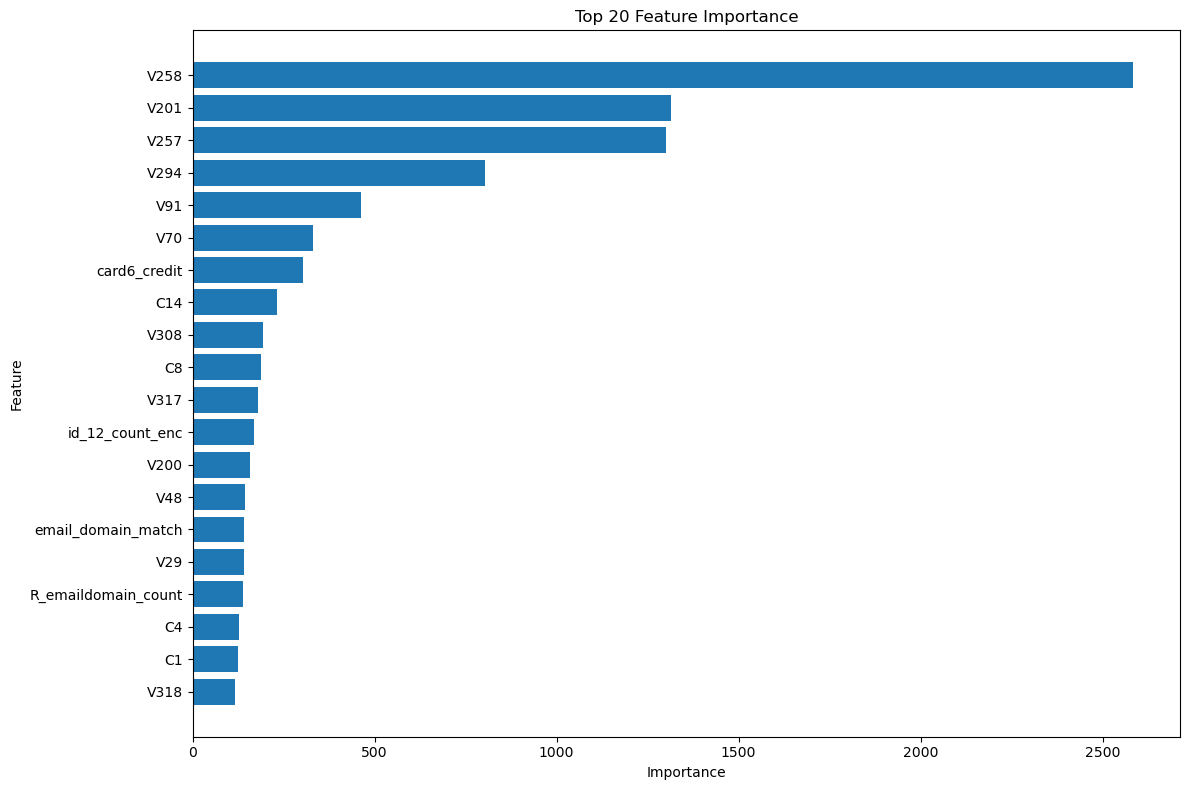

In [20]:
best_params = {
    'n_estimators': 3855,
    'learning_rate': 0.018521952194730323,
    'max_depth': 6,
    'subsample': 0.748195355831056,
    'colsample_bytree': 0.8275175471487392,
    'scale_pos_weight': scale_pos_weight,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'verbosity': 0
}

high_cardinality_cols = [col for col in cat_features if X[col].nunique() > 200]
if high_cardinality_cols:
    print(f"Encoding high-cardinality features: {high_cardinality_cols}")
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X[high_cardinality_cols] = ordinal_enc.fit_transform(X[high_cardinality_cols])

for col in cat_features:
    if col not in high_cardinality_cols:
        X[col] = X[col].astype('category').cat.codes

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

print("Training final model...")
watchlist = [(dtrain, 'train'), (dtest, 'test')]
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=watchlist,
    early_stopping_rounds=400,
    verbose_eval=100 
)

model_path = "xgboost_final_model.json"
final_model.save_model(model_path)
print(f"Model saved to {model_path}")

y_pred_proba = final_model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nFinal Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

importance_type = 'gain' 
feature_importance = final_model.get_score(importance_type=importance_type)

import pandas as pd
feature_imp_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
})
feature_imp_df = feature_imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
plt.barh(feature_imp_df['Feature'][:20], feature_imp_df['Importance'][:20])
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

Transforming high-cardinality features in test data: ['card1_addr1_P_emaildomain_FE', 'open_card', 'card1_addr1_FE', 'card1_addr1', 'card1_addr1_P_emaildomain', 'ProductID', 'uid1', 'card2_FE', 'device_hash']
Predictions saved to prediction_results_xgb.csv


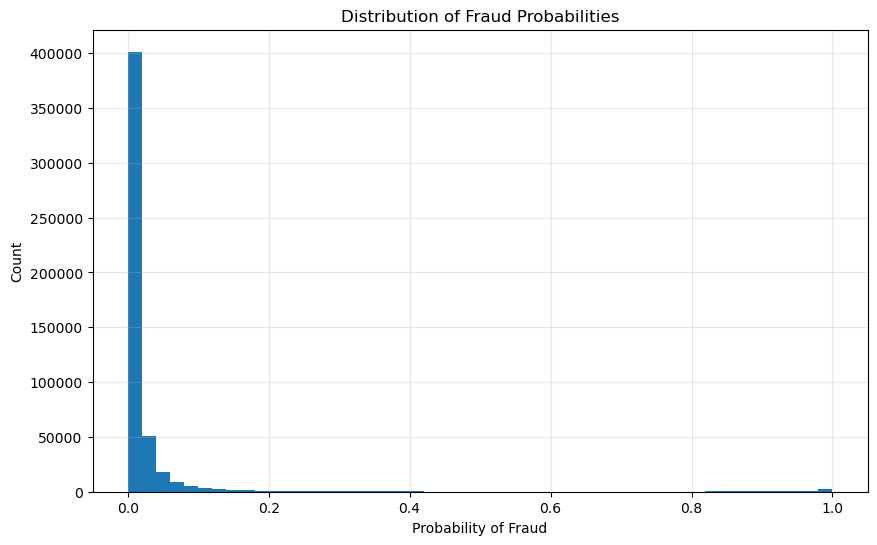


Prediction Summary:
Min probability: 0.0000
Max probability: 0.9997
Mean probability: 0.0301
Median probability: 0.0058
Transactions with >50% fraud probability: 7829 (1.55%)
Transactions with >90% fraud probability: 4410 (0.87%)


In [23]:
X_test = test_df[X_train.columns]
 
if high_cardinality_cols:
    print(f"Transforming high-cardinality features in test data: {high_cardinality_cols}")
    X_test[high_cardinality_cols] = ordinal_enc.transform(X_test[high_cardinality_cols])
 
for col in cat_features:
    if col not in high_cardinality_cols:
        X_test[col] = X_test[col].astype('category').cat.codes
 
dtest = xgb.DMatrix(X_test)
 
y_pred_proba = final_model.predict(dtest)
 
test_df["isFraud"] = y_pred_proba
 
test_df[["TransactionID", "isFraud"]].to_csv("prediction_results_xgb.csv", index=False)

# LightGBM

In [18]:
train_df = train_df_copy
test_df = test_df_copy

In [19]:
# Handling Categorical FEatures 
cat_features = [
    'ProductCD', 'card4', 'card6', 'DeviceType', 'browser_id_31', 'email_domain_match', 'R_emaildomain_count', 
    'P_emaildomain_count', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9',   
    'ProductID', 'uid1', 'device_name', 'device_hash', 'card3_target_enc', 
    'card1_addr1_P_emaildomain', 'card1_addr1_FE', 'card1_addr1_P_emaildomain_FE', 
    'open_card', 'card2_FE', 'card3_FE', 'card4_visa', 'card4_mastercard'
]

object_columns = train_df.select_dtypes(include=['object','category']).columns.tolist()
potential_categorical = [col for col in train_df.select_dtypes(include=['int64', 'float64']).columns 
                         if train_df[col].nunique() < 60]
cat_features = cat_features + object_columns + potential_categorical
if 'isFraud' in cat_features:
    cat_features.remove('isFraud')

id_columns = ["id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", "id_30", "id_31", "id_33", "id_34"]
cat_features += [col for col in id_columns if col in train_df.columns]
card_columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
cat_features = list(set(cat_features))
cat_features = [col for col in cat_features if col in train_df.columns]

remaining_features = [col for col in train_df.columns if col not in cat_features]
if 'isFraud' in remaining_features:
    remaining_features.remove('isFraud')

# Convert categorical variables to category type
for col in cat_features:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [20]:
# Define train and validation sets
X = train_df.drop(columns=["isFraud"])
y = train_df["isFraud"]

groups = train_df["uid1"]   
gkf = GroupKFold(n_splits=3)

# Ensure cat_features only includes columns that exist in X_train
cat_features = [col for col in cat_features if col in X.columns]

In [61]:
raw_scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight = min(10, raw_scale_pos_weight ** 0.5)  

def optuna_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1200, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'max_depth': trial.suggest_int('max_depth', 8, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'boosting_type': 'gbdt',
        'scale_pos_weight': scale_pos_weight,
        'objective': 'binary',
        'num_threads': 1,
        'metric': 'auc',
        'device': 'gpu',
        'verbose': -1
    }
    
    gkf = GroupKFold(n_splits=3)
    auc_scores = []

    for train_idx, valid_idx in gkf.split(X, y, groups):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        high_cardinality_cols = [col for col in cat_features if X_train[col].nunique() > 200]

        if high_cardinality_cols:
            print(f"Encoding high-cardinality features: {high_cardinality_cols}")
            ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            X_train[high_cardinality_cols] = ordinal_enc.fit_transform(X_train[high_cardinality_cols])
            X_valid[high_cardinality_cols] = ordinal_enc.transform(X_valid[high_cardinality_cols])  

        for col in cat_features:
            if col not in high_cardinality_cols:
                X_train[col] = X_train[col].astype('category')
                X_valid[col] = X_valid[col].astype('category')

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="auc",
            callbacks=[lgb.early_stopping(400, verbose=False)]
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc_score)

    mean_auc = np.mean(auc_scores)
    print(f"Trial {trial.number}: AUC = {mean_auc:.4f} | Params: {params}")
    return mean_auc  

study = optuna.create_study(direction="maximize")  
study.optimize(optuna_objective, n_trials=20)

print("\nBest AUC:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-03-04 20:38:19,505] A new study created in memory with name: no-name-1162bea1-a840-421b-8f38-6e99d15f661a


Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:41:10,318] Trial 0 finished with value: 0.8820697638729612 and parameters: {'n_estimators': 1325, 'learning_rate': 0.02738476808491972, 'max_depth': 8, 'subsample': 0.609219901460454, 'colsample_bytree': 0.8739148691354253}. Best is trial 0 with value: 0.8820697638729612.


Trial 0: AUC = 0.8821 | Params: {'n_estimators': 1325, 'learning_rate': 0.02738476808491972, 'max_depth': 8, 'subsample': 0.609219901460454, 'colsample_bytree': 0.8739148691354253, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:43:27,323] Trial 1 finished with value: 0.8805176140871959 and parameters: {'n_estimators': 2201, 'learning_rate': 0.049449699128741184, 'max_depth': 9, 'subsample': 0.8190700523259975, 'colsample_bytree': 0.9411388501959743}. Best is trial 0 with value: 0.8820697638729612.


Trial 1: AUC = 0.8805 | Params: {'n_estimators': 2201, 'learning_rate': 0.049449699128741184, 'max_depth': 9, 'subsample': 0.8190700523259975, 'colsample_bytree': 0.9411388501959743, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:46:44,532] Trial 2 finished with value: 0.883363626560126 and parameters: {'n_estimators': 3462, 'learning_rate': 0.02122880003374468, 'max_depth': 9, 'subsample': 0.9541880691830018, 'colsample_bytree': 0.8810073729447501}. Best is trial 2 with value: 0.883363626560126.


Trial 2: AUC = 0.8834 | Params: {'n_estimators': 3462, 'learning_rate': 0.02122880003374468, 'max_depth': 9, 'subsample': 0.9541880691830018, 'colsample_bytree': 0.8810073729447501, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:49:15,777] Trial 3 finished with value: 0.8825049066219762 and parameters: {'n_estimators': 2789, 'learning_rate': 0.04267264107296135, 'max_depth': 10, 'subsample': 0.6949593821859603, 'colsample_bytree': 0.8556363051736497}. Best is trial 2 with value: 0.883363626560126.


Trial 3: AUC = 0.8825 | Params: {'n_estimators': 2789, 'learning_rate': 0.04267264107296135, 'max_depth': 10, 'subsample': 0.6949593821859603, 'colsample_bytree': 0.8556363051736497, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:52:51,340] Trial 4 finished with value: 0.8830589670440342 and parameters: {'n_estimators': 2959, 'learning_rate': 0.018986212434423097, 'max_depth': 8, 'subsample': 0.5513826421179753, 'colsample_bytree': 0.7888169309385491}. Best is trial 2 with value: 0.883363626560126.


Trial 4: AUC = 0.8831 | Params: {'n_estimators': 2959, 'learning_rate': 0.018986212434423097, 'max_depth': 8, 'subsample': 0.5513826421179753, 'colsample_bytree': 0.7888169309385491, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:56:53,236] Trial 5 finished with value: 0.8823322004869034 and parameters: {'n_estimators': 3076, 'learning_rate': 0.033567540724139366, 'max_depth': 10, 'subsample': 0.9698446896577996, 'colsample_bytree': 0.5694818192510228}. Best is trial 2 with value: 0.883363626560126.


Trial 5: AUC = 0.8823 | Params: {'n_estimators': 3076, 'learning_rate': 0.033567540724139366, 'max_depth': 10, 'subsample': 0.9698446896577996, 'colsample_bytree': 0.5694818192510228, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 20:59:41,838] Trial 6 finished with value: 0.8830621311320405 and parameters: {'n_estimators': 3049, 'learning_rate': 0.030892466884035755, 'max_depth': 8, 'subsample': 0.842981504974643, 'colsample_bytree': 0.9204315232737573}. Best is trial 2 with value: 0.883363626560126.


Trial 6: AUC = 0.8831 | Params: {'n_estimators': 3049, 'learning_rate': 0.030892466884035755, 'max_depth': 8, 'subsample': 0.842981504974643, 'colsample_bytree': 0.9204315232737573, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:02:24,907] Trial 7 finished with value: 0.8819780714395306 and parameters: {'n_estimators': 3900, 'learning_rate': 0.032303136459581744, 'max_depth': 9, 'subsample': 0.9198799788729743, 'colsample_bytree': 0.9260994617660271}. Best is trial 2 with value: 0.883363626560126.


Trial 7: AUC = 0.8820 | Params: {'n_estimators': 3900, 'learning_rate': 0.032303136459581744, 'max_depth': 9, 'subsample': 0.9198799788729743, 'colsample_bytree': 0.9260994617660271, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:05:49,192] Trial 8 finished with value: 0.8829790210376691 and parameters: {'n_estimators': 1781, 'learning_rate': 0.019179535139714474, 'max_depth': 8, 'subsample': 0.622768282872707, 'colsample_bytree': 0.7188952427996349}. Best is trial 2 with value: 0.883363626560126.


Trial 8: AUC = 0.8830 | Params: {'n_estimators': 1781, 'learning_rate': 0.019179535139714474, 'max_depth': 8, 'subsample': 0.622768282872707, 'colsample_bytree': 0.7188952427996349, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:08:38,984] Trial 9 finished with value: 0.8824983446616396 and parameters: {'n_estimators': 1647, 'learning_rate': 0.028098072606332625, 'max_depth': 8, 'subsample': 0.6089902861279564, 'colsample_bytree': 0.9294427468761116}. Best is trial 2 with value: 0.883363626560126.


Trial 9: AUC = 0.8825 | Params: {'n_estimators': 1647, 'learning_rate': 0.028098072606332625, 'max_depth': 8, 'subsample': 0.6089902861279564, 'colsample_bytree': 0.9294427468761116, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:13:37,259] Trial 10 finished with value: 0.8848148287034326 and parameters: {'n_estimators': 4513, 'learning_rate': 0.011206907364898166, 'max_depth': 9, 'subsample': 0.9963441642292529, 'colsample_bytree': 0.6810991452638021}. Best is trial 10 with value: 0.8848148287034326.


Trial 10: AUC = 0.8848 | Params: {'n_estimators': 4513, 'learning_rate': 0.011206907364898166, 'max_depth': 9, 'subsample': 0.9963441642292529, 'colsample_bytree': 0.6810991452638021, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:18:57,619] Trial 11 finished with value: 0.8843578593399934 and parameters: {'n_estimators': 4944, 'learning_rate': 0.010956203895066668, 'max_depth': 9, 'subsample': 0.9905263517456587, 'colsample_bytree': 0.6591915523299833}. Best is trial 10 with value: 0.8848148287034326.


Trial 11: AUC = 0.8844 | Params: {'n_estimators': 4944, 'learning_rate': 0.010956203895066668, 'max_depth': 9, 'subsample': 0.9905263517456587, 'colsample_bytree': 0.6591915523299833, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:24:24,254] Trial 12 finished with value: 0.884592740708189 and parameters: {'n_estimators': 4806, 'learning_rate': 0.010993876915435363, 'max_depth': 9, 'subsample': 0.8785257981217875, 'colsample_bytree': 0.6379838125338924}. Best is trial 10 with value: 0.8848148287034326.


Trial 12: AUC = 0.8846 | Params: {'n_estimators': 4806, 'learning_rate': 0.010993876915435363, 'max_depth': 9, 'subsample': 0.8785257981217875, 'colsample_bytree': 0.6379838125338924, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:31:31,996] Trial 13 finished with value: 0.8845344451791842 and parameters: {'n_estimators': 4991, 'learning_rate': 0.010555477810715455, 'max_depth': 10, 'subsample': 0.8526908295011434, 'colsample_bytree': 0.5238806982772348}. Best is trial 10 with value: 0.8848148287034326.


Trial 13: AUC = 0.8845 | Params: {'n_estimators': 4991, 'learning_rate': 0.010555477810715455, 'max_depth': 10, 'subsample': 0.8526908295011434, 'colsample_bytree': 0.5238806982772348, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:35:32,213] Trial 14 finished with value: 0.8837264156189856 and parameters: {'n_estimators': 4179, 'learning_rate': 0.015125002168317726, 'max_depth': 9, 'subsample': 0.7512393657876025, 'colsample_bytree': 0.6386044047742272}. Best is trial 10 with value: 0.8848148287034326.


Trial 14: AUC = 0.8837 | Params: {'n_estimators': 4179, 'learning_rate': 0.015125002168317726, 'max_depth': 9, 'subsample': 0.7512393657876025, 'colsample_bytree': 0.6386044047742272, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:40:03,495] Trial 15 finished with value: 0.8838289323292576 and parameters: {'n_estimators': 4289, 'learning_rate': 0.014810997859696544, 'max_depth': 9, 'subsample': 0.900961720736551, 'colsample_bytree': 0.6336168263897053}. Best is trial 10 with value: 0.8848148287034326.


Trial 15: AUC = 0.8838 | Params: {'n_estimators': 4289, 'learning_rate': 0.014810997859696544, 'max_depth': 9, 'subsample': 0.900961720736551, 'colsample_bytree': 0.6336168263897053, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:43:29,767] Trial 16 finished with value: 0.8836945518745045 and parameters: {'n_estimators': 4496, 'learning_rate': 0.022186956201439546, 'max_depth': 10, 'subsample': 0.7711175709736908, 'colsample_bytree': 0.7475484664472627}. Best is trial 10 with value: 0.8848148287034326.


Trial 16: AUC = 0.8837 | Params: {'n_estimators': 4496, 'learning_rate': 0.022186956201439546, 'max_depth': 10, 'subsample': 0.7711175709736908, 'colsample_bytree': 0.7475484664472627, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:47:21,762] Trial 17 finished with value: 0.8831186438884783 and parameters: {'n_estimators': 3753, 'learning_rate': 0.015453310578467345, 'max_depth': 9, 'subsample': 0.9015623530067662, 'colsample_bytree': 0.6929384508828461}. Best is trial 10 with value: 0.8848148287034326.


Trial 17: AUC = 0.8831 | Params: {'n_estimators': 3753, 'learning_rate': 0.015453310578467345, 'max_depth': 9, 'subsample': 0.9015623530067662, 'colsample_bytree': 0.6929384508828461, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:50:58,858] Trial 18 finished with value: 0.8805811685000847 and parameters: {'n_estimators': 4698, 'learning_rate': 0.0384124649818811, 'max_depth': 10, 'subsample': 0.9947592006817504, 'colsample_bytree': 0.5718852635694959}. Best is trial 10 with value: 0.8848148287034326.


Trial 18: AUC = 0.8806 | Params: {'n_estimators': 4698, 'learning_rate': 0.0384124649818811, 'max_depth': 10, 'subsample': 0.9947592006817504, 'colsample_bytree': 0.5718852635694959, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']
Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'device_hash', 'card1_addr1', 'card2_FE', 'card1_addr1_P_emaildomain', 'ProductID']


[I 2025-03-04 21:53:52,483] Trial 19 finished with value: 0.8829313126735316 and parameters: {'n_estimators': 3530, 'learning_rate': 0.025083397068168707, 'max_depth': 9, 'subsample': 0.8737614576895266, 'colsample_bytree': 0.7996928675848568}. Best is trial 10 with value: 0.8848148287034326.


Trial 19: AUC = 0.8829 | Params: {'n_estimators': 3530, 'learning_rate': 0.025083397068168707, 'max_depth': 9, 'subsample': 0.8737614576895266, 'colsample_bytree': 0.7996928675848568, 'boosting_type': 'gbdt', 'scale_pos_weight': 5.251692896763069, 'objective': 'binary', 'num_threads': 1, 'metric': 'auc', 'device': 'gpu', 'verbose': -1}

Best AUC: 0.8848148287034326
Best Hyperparameters: {'n_estimators': 4513, 'learning_rate': 0.011206907364898166, 'max_depth': 9, 'subsample': 0.9963441642292529, 'colsample_bytree': 0.6810991452638021}


In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fix high-cardinality categorical features
high_cardinality_cols = [col for col in cat_features if X_train[col].nunique() > 200]

# Use Ordinal Encoding to handle unseen values in X_valid
if high_cardinality_cols:
    print(f"Encoding high-cardinality features: {high_cardinality_cols}")
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train[high_cardinality_cols] = ordinal_enc.fit_transform(X_train[high_cardinality_cols])
    X_valid[high_cardinality_cols] = ordinal_enc.transform(X_valid[high_cardinality_cols])  

# Convert remaining categorical columns to `category` type for LightGBM
for col in cat_features:
    if col not in high_cardinality_cols:
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

Encoding high-cardinality features: ['card1_addr1_P_emaildomain_FE', 'card1_addr1_FE', 'uid1', 'open_card', 'card2_FE', 'ProductID', 'card1_addr1', 'card1_addr1_P_emaildomain', 'device_hash']


In [89]:
raw_scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight = min(10, raw_scale_pos_weight ** 0.5)  

# training lgm
lgb_params = {
    'subsample': 0.9963,
    'scale_pos_weight': scale_pos_weight,
    'n_estimators': 5000,
    'max_depth': 9,
    'learning_rate': 0.0112,
    'colsample_bytree': 0.681,
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'device': 'gpu',   
    'categorical_feature': cat_cols
}

lgb_model = lgb.LGBMClassifier(**lgb_params)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(400), lgb.log_evaluation(100)]
)

# Save model
lgb_model.booster_.save_model("lgbm_model.txt")

y_pred = lgb_model.predict_proba(X_valid)[:, 1]  
auc_score = roc_auc_score(y_valid, y_pred)
print(f"Validation AUC: {auc_score:.4f}")

Training until validation scores don't improve for 400 rounds
[100]	valid_0's auc: 0.899098
[200]	valid_0's auc: 0.911729
[300]	valid_0's auc: 0.919305
[400]	valid_0's auc: 0.926083
[500]	valid_0's auc: 0.931271
[600]	valid_0's auc: 0.935104
[700]	valid_0's auc: 0.938209
[800]	valid_0's auc: 0.941049
[900]	valid_0's auc: 0.943671
[1000]	valid_0's auc: 0.9458
[1100]	valid_0's auc: 0.947614
[1200]	valid_0's auc: 0.949241
[1300]	valid_0's auc: 0.950727
[1400]	valid_0's auc: 0.952064
[1500]	valid_0's auc: 0.953261
[1600]	valid_0's auc: 0.954251
[1700]	valid_0's auc: 0.955249
[1800]	valid_0's auc: 0.956138
[1900]	valid_0's auc: 0.957083
[2000]	valid_0's auc: 0.957936
[2100]	valid_0's auc: 0.958614
[2200]	valid_0's auc: 0.959381
[2300]	valid_0's auc: 0.960015
[2400]	valid_0's auc: 0.960562
[2500]	valid_0's auc: 0.961147
[2600]	valid_0's auc: 0.961743
[2700]	valid_0's auc: 0.962374
[2800]	valid_0's auc: 0.962784
[2900]	valid_0's auc: 0.963253
[3000]	valid_0's auc: 0.963731
[3100]	valid_0's au

In [90]:
y_pred = lgb_model.predict_proba(X_valid)[:, 1]  
auc_score = roc_auc_score(y_valid, y_pred)
print(f"Validation AUC: {auc_score:.4f}")

Validation AUC: 0.9697


In [91]:
X_test = test_df[X_train.columns] 

if high_cardinality_cols:
    X_test[high_cardinality_cols] = ordinal_enc.transform(X_test[high_cardinality_cols])   

for col in cat_features:
    if col not in high_cardinality_cols:
        X_test[col] = X_test[col].astype('category')

y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]  

test_df["isFraud"] = y_pred_proba  
test_df[["TransactionID", "isFraud"]].to_csv("prediction_results_lightgbm.csv", index=False)

## Model Reload


Model Performance Metrics:
Accuracy: 0.9846
Precision: 0.8157
Recall: 0.7249
F1 Score: 0.7676
AUC: 0.9697

Top 20 Important Features:
                                          Feature  Importance
0                                            hour        5545
1                                       open_card        4051
2                             P_emaildomain_count        3484
3                                card5_target_enc        3008
4                                  TransactionAmt        2523
5    TransactionAmt_card1_addr1_P_emaildomain_std        2085
6               D11_card1_addr1_P_emaildomain_std        2061
7                                    D9_card1_std        2016
8                                   D9_card1_mean        2013
9                                   TransactionID        2007
10                                       card2_FE        1980
11                                    D15_revised        1918
12                                  D11_card1_std        18

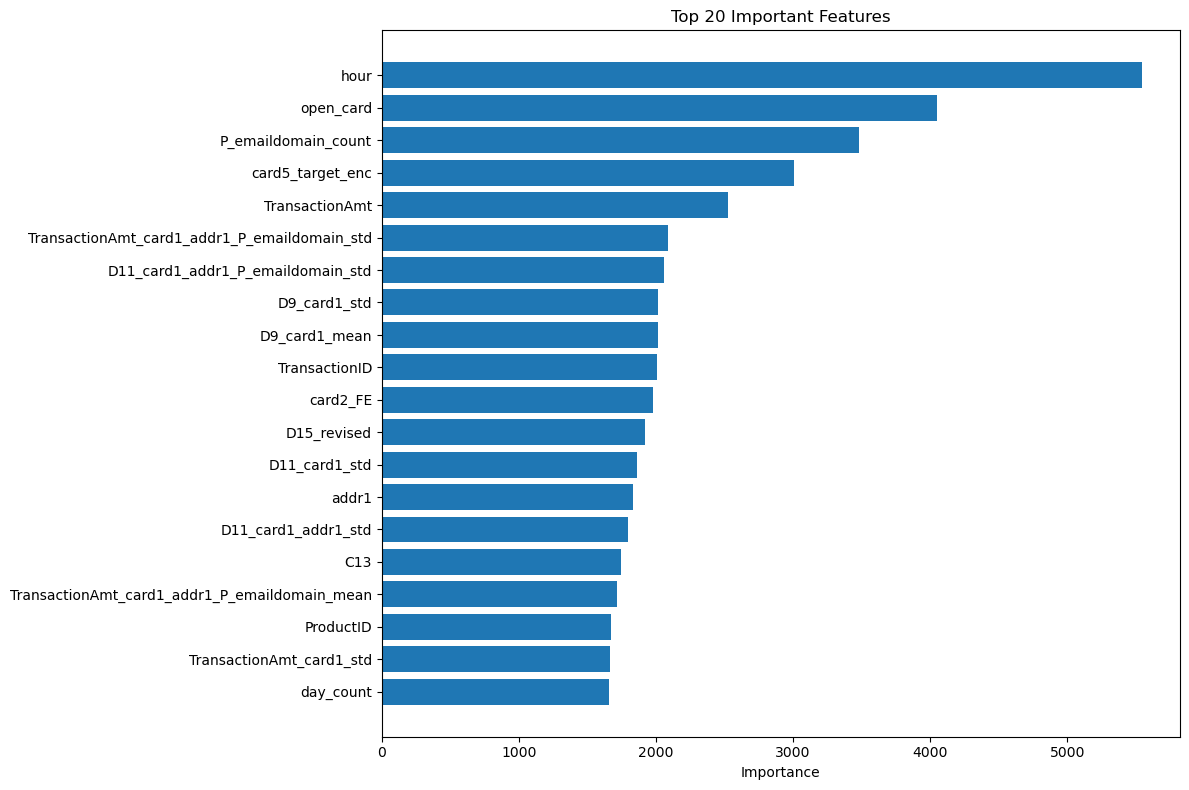

In [26]:
import lightgbm as lgb
with open("lgbm_model.txt", "r", encoding="utf-8") as f:
    model_str = f.read()

X_val = X_valid
y_val = y_valid

lgbm_loaded_model = lgb.Booster(model_str=model_str)

y_pred_proba = lgbm_loaded_model.predict(X_val)
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

feature_importances = lgbm_loaded_model.feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nTop 20 Important Features:")
print(importance_df.head(20))

plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(top_20['Feature'][::-1], top_20['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

Leaderboard Score
- Public Score : 0.93
- Private Score : 0.91

# CatBoost

In [8]:
# Handling Categorical FEatures 
cat_features = [
    'ProductCD', 'card4', 'card6', 'DeviceType', 'browser_id_31', 'email_domain_match', 'R_emaildomain_count', 
    'P_emaildomain_count', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9',   
    'ProductID', 'uid1', 'device_name', 'device_hash', 'card3_target_enc', 
    'card1_addr1_P_emaildomain', 'card1_addr1_FE', 'card1_addr1_P_emaildomain_FE', 
    'open_card', 'card2_FE', 'card3_FE', 'card4_visa', 'card4_mastercard'
]

object_columns = train_df.select_dtypes(include=['object','category']).columns.tolist()
potential_categorical = [col for col in train_df.select_dtypes(include=['int64', 'float64']).columns 
                         if train_df[col].nunique() < 60]
cat_features = cat_features + object_columns + potential_categorical
if 'isFraud' in cat_features:
    cat_features.remove('isFraud')

id_columns = ["id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", "id_30", "id_31", "id_33", "id_34"]
cat_features += [col for col in id_columns if col in train_df.columns]
card_columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
cat_features = list(set(cat_features))
cat_features = [col for col in cat_features if col in train_df.columns]

remaining_features = [col for col in train_df.columns if col not in cat_features]
remaining_features

['isFraud',
 'TransactionAmt',
 'addr1',
 'addr2',
 'dist1',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'V95',
 'V96',
 'V97',
 'V99',
 'V101',
 'V102',
 'V103',
 'V105',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V167',
 'V168',
 'V171',
 'V177',
 'V178',
 'V179',
 'V180',
 'V182',
 'V187',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V221',
 'V222',
 'V224',
 'V226',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V253',
 'V258',
 'V259',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V283',
 'V285',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V298',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 

In [9]:
# Fill missing values for columns
if 'isFraud' in remaining_features:
    remaining_features.remove('isFraud')

train_df[remaining_features] = train_df[remaining_features].fillna(-999)
test_df[remaining_features] = test_df[remaining_features].fillna(-999)

train_df[cat_features] = train_df[cat_features].astype(str).fillna("missing")
test_df[cat_features] = test_df[cat_features].astype(str).fillna("missing")

In [10]:
# Define train and validation sets
X_train = train_df.drop(columns=["isFraud"])
y_train = train_df["isFraud"]

groups = train_df["uid1"]   
gkf = GroupKFold(n_splits=3)

# Ensure cat_features only includes columns that exist in X_train
cat_features = [col for col in cat_features if col in X_train.columns]

In [11]:
def optuna_objective(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 1000, 5000),
        "depth": trial.suggest_int("depth", 8, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.02, 0.05),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "loss_function": "Logloss",   
        "eval_metric": "AUC",   
        "task_type": "GPU",
        "od_wait": 20,  
        "random_seed": 42,
        "scale_pos_weight": (sum(y_train == 0) / sum(y_train == 1)) ** 0.5 
    }

    auc_scores = []
    
    # GroupKFold Cross-validation
    for train_idx, valid_idx in gkf.split(X_train, y_train, groups):   
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**param, cat_features=cat_features, verbose=100)   
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=500)

        # Predict probabilities & calculate AUC
        preds = model.predict_proba(X_val)[:, 1]  
        auc = roc_auc_score(y_val, preds)
        auc_scores.append(auc)

    return np.mean(auc_scores) 

# Run Optuna optimization
study = optuna.create_study(direction="maximize")   
study.optimize(optuna_objective, n_trials=35)

print("Best Parameters:", study.best_trial.params)
print("Best AUC Score:", study.best_trial.value)

[I 2025-03-03 17:48:48,302] A new study created in memory with name: no-name-603e36b7-ba2b-4444-8fa2-c941b63ac90e
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7917199	best: 0.7917199 (0)	total: 807ms	remaining: 49m 1s
100:	test: 0.8870250	best: 0.8870250 (100)	total: 46.5s	remaining: 27m 10s
200:	test: 0.8976529	best: 0.8977057 (199)	total: 1m 30s	remaining: 25m 51s
300:	test: 0.9014601	best: 0.9015098 (285)	total: 2m 14s	remaining: 24m 54s
400:	test: 0.9035856	best: 0.9035856 (400)	total: 3m 1s	remaining: 24m 24s
500:	test: 0.9041849	best: 0.9045346 (467)	total: 3m 45s	remaining: 23m 34s
600:	test: 0.9053820	best: 0.9053820 (600)	total: 4m 31s	remaining: 22m 56s
700:	test: 0.9052151	best: 0.9057034 (632)	total: 5m 16s	remaining: 22m 9s
800:	test: 0.9048864	best: 0.9057034 (632)	total: 6m 2s	remaining: 21m 27s
900:	test: 0.9043630	best: 0.9057034 (632)	total: 6m 48s	remaining: 20m 45s
1000:	test: 0.9033400	best: 0.9057034 (632)	total: 7m 36s	remaining: 20m 6s
1100:	test: 0.9025224	best: 0.9057034 (632)	total: 8m 23s	remaining: 19m 22s
bestTest = 0.9057033658
bestIteration = 632
Shrink model to first 633 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7893706	best: 0.7893706 (0)	total: 953ms	remaining: 57m 53s
100:	test: 0.8577790	best: 0.8579149 (98)	total: 47.4s	remaining: 27m 42s
200:	test: 0.8671872	best: 0.8673261 (198)	total: 1m 34s	remaining: 27m 4s
300:	test: 0.8707903	best: 0.8710848 (289)	total: 2m 20s	remaining: 26m 1s
400:	test: 0.8725492	best: 0.8728665 (357)	total: 3m 5s	remaining: 25m 3s
500:	test: 0.8743874	best: 0.8746067 (495)	total: 3m 53s	remaining: 24m 23s
600:	test: 0.8747329	best: 0.8748848 (583)	total: 4m 37s	remaining: 23m 27s
700:	test: 0.8754340	best: 0.8754340 (700)	total: 5m 22s	remaining: 22m 34s
800:	test: 0.8757342	best: 0.8757556 (797)	total: 6m 8s	remaining: 21m 50s
900:	test: 0.8757654	best: 0.8758802 (848)	total: 6m 55s	remaining: 21m 6s
1000:	test: 0.8756098	best: 0.8758802 (848)	total: 7m 42s	remaining: 20m 21s
1100:	test: 0.8753657	best: 0.8758802 (848)	total: 8m 29s	remaining: 19m 37s
1200:	test: 0.8751156	best: 0.8758802 (848)	total: 9m 17s	remaining: 18m 53s
1300:	test: 0.8738628	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8162656	best: 0.8162656 (0)	total: 621ms	remaining: 37m 41s
100:	test: 0.8829147	best: 0.8830089 (99)	total: 46.7s	remaining: 27m 19s
200:	test: 0.8888045	best: 0.8888903 (190)	total: 1m 30s	remaining: 25m 45s
300:	test: 0.8905867	best: 0.8907570 (297)	total: 2m 16s	remaining: 25m 16s
400:	test: 0.8910375	best: 0.8912475 (360)	total: 3m 1s	remaining: 24m 26s
500:	test: 0.8917437	best: 0.8918727 (466)	total: 3m 46s	remaining: 23m 39s
600:	test: 0.8922768	best: 0.8923365 (596)	total: 4m 33s	remaining: 23m 3s
700:	test: 0.8925800	best: 0.8928146 (649)	total: 5m 20s	remaining: 22m 26s
800:	test: 0.8927459	best: 0.8928920 (790)	total: 6m 5s	remaining: 21m 39s
900:	test: 0.8925602	best: 0.8928920 (790)	total: 6m 52s	remaining: 20m 57s
1000:	test: 0.8920635	best: 0.8929009 (955)	total: 7m 40s	remaining: 20m 16s
1100:	test: 0.8921388	best: 0.8929009 (955)	total: 8m 27s	remaining: 19m 32s
1200:	test: 0.8914703	best: 0.8929009 (955)	total: 9m 14s	remaining: 18m 48s
1300:	test: 0.89074

[I 2025-03-03 18:21:57,107] Trial 0 finished with value: 0.8914948651572502 and parameters: {'iterations': 3645, 'depth': 10, 'learning_rate': 0.03901217149229777, 'l2_leaf_reg': 3.7894473139063543, 'border_count': 144}. Best is trial 0 with value: 0.8914948651572502.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812653	best: 0.7812653 (0)	total: 626ms	remaining: 18m 8s
100:	test: 0.8847735	best: 0.8847735 (100)	total: 34.2s	remaining: 9m 13s
200:	test: 0.8951596	best: 0.8951596 (200)	total: 1m 6s	remaining: 8m 32s
300:	test: 0.8995278	best: 0.8995278 (300)	total: 1m 40s	remaining: 7m 59s
400:	test: 0.9016415	best: 0.9016415 (400)	total: 2m 15s	remaining: 7m 33s
500:	test: 0.9035769	best: 0.9035769 (500)	total: 2m 48s	remaining: 6m 55s
600:	test: 0.9041177	best: 0.9042128 (573)	total: 3m 21s	remaining: 6m 22s
700:	test: 0.9051006	best: 0.9052491 (681)	total: 3m 56s	remaining: 5m 49s
800:	test: 0.9058051	best: 0.9058191 (769)	total: 4m 29s	remaining: 5m 15s
900:	test: 0.9067260	best: 0.9067636 (897)	total: 5m 1s	remaining: 4m 40s
1000:	test: 0.9066592	best: 0.9068684 (964)	total: 5m 34s	remaining: 4m 6s
1100:	test: 0.9067355	best: 0.9068684 (964)	total: 6m 8s	remaining: 3m 33s
1200:	test: 0.9069803	best: 0.9072632 (1183)	total: 6m 41s	remaining: 2m 59s
1300:	test: 0.9071847	best: 0.9

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7799767	best: 0.7799767 (0)	total: 635ms	remaining: 18m 24s
100:	test: 0.8567637	best: 0.8568662 (99)	total: 35s	remaining: 9m 27s
200:	test: 0.8673764	best: 0.8674356 (191)	total: 1m 8s	remaining: 8m 45s
300:	test: 0.8706076	best: 0.8706402 (299)	total: 1m 41s	remaining: 8m 6s
400:	test: 0.8724460	best: 0.8724460 (400)	total: 2m 14s	remaining: 7m 27s
500:	test: 0.8747534	best: 0.8747534 (500)	total: 2m 46s	remaining: 6m 50s
600:	test: 0.8756051	best: 0.8756051 (600)	total: 3m 18s	remaining: 6m 16s
700:	test: 0.8763293	best: 0.8763363 (697)	total: 3m 51s	remaining: 5m 43s
800:	test: 0.8769572	best: 0.8769856 (797)	total: 4m 24s	remaining: 5m 9s
900:	test: 0.8776741	best: 0.8776741 (900)	total: 4m 59s	remaining: 4m 38s
1000:	test: 0.8783709	best: 0.8784886 (996)	total: 5m 31s	remaining: 4m 4s
1100:	test: 0.8784437	best: 0.8785282 (1081)	total: 6m 4s	remaining: 3m 30s
1200:	test: 0.8789665	best: 0.8791025 (1185)	total: 6m 37s	remaining: 2m 58s
1300:	test: 0.8792815	best: 0.879

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8171722	best: 0.8171722 (0)	total: 569ms	remaining: 16m 28s
100:	test: 0.8801352	best: 0.8801690 (99)	total: 33.9s	remaining: 9m 10s
200:	test: 0.8854693	best: 0.8856525 (199)	total: 1m 7s	remaining: 8m 35s
300:	test: 0.8876932	best: 0.8876932 (300)	total: 1m 39s	remaining: 7m 57s
400:	test: 0.8896651	best: 0.8898260 (392)	total: 2m 12s	remaining: 7m 23s
500:	test: 0.8899557	best: 0.8899773 (498)	total: 2m 44s	remaining: 6m 46s
600:	test: 0.8894120	best: 0.8899863 (504)	total: 3m 18s	remaining: 6m 15s
700:	test: 0.8900498	best: 0.8900498 (700)	total: 3m 50s	remaining: 5m 41s
800:	test: 0.8900990	best: 0.8900990 (800)	total: 4m 23s	remaining: 5m 9s
900:	test: 0.8903927	best: 0.8906580 (865)	total: 4m 57s	remaining: 4m 36s
1000:	test: 0.8906553	best: 0.8906609 (989)	total: 5m 30s	remaining: 4m 3s
1100:	test: 0.8910931	best: 0.8910931 (1100)	total: 6m 3s	remaining: 3m 30s
1200:	test: 0.8902839	best: 0.8911015 (1101)	total: 6m 35s	remaining: 2m 57s
1300:	test: 0.8901132	best: 0.

[I 2025-03-03 18:53:10,151] Trial 1 finished with value: 0.8926412781003427 and parameters: {'iterations': 1739, 'depth': 8, 'learning_rate': 0.0425582254918082, 'l2_leaf_reg': 7.130551408246994, 'border_count': 51}. Best is trial 1 with value: 0.8926412781003427.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7908483	best: 0.7908483 (0)	total: 610ms	remaining: 38m 45s
100:	test: 0.8913330	best: 0.8913330 (100)	total: 47s	remaining: 28m 48s
200:	test: 0.8985159	best: 0.8985159 (200)	total: 1m 32s	remaining: 27m 35s
300:	test: 0.8995251	best: 0.8998379 (286)	total: 2m 17s	remaining: 26m 42s
400:	test: 0.9005769	best: 0.9008151 (363)	total: 3m 4s	remaining: 26m 7s
500:	test: 0.9012144	best: 0.9019161 (474)	total: 3m 54s	remaining: 25m 49s
600:	test: 0.9001005	best: 0.9019161 (474)	total: 4m 46s	remaining: 25m 29s
700:	test: 0.8995780	best: 0.9019161 (474)	total: 5m 33s	remaining: 24m 40s
800:	test: 0.8990061	best: 0.9019161 (474)	total: 6m 25s	remaining: 24m 9s
900:	test: 0.8970501	best: 0.9019161 (474)	total: 7m 17s	remaining: 23m 33s
bestTest = 0.9019160867
bestIteration = 474
Shrink model to first 475 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7936095	best: 0.7936095 (0)	total: 808ms	remaining: 51m 18s
100:	test: 0.8629540	best: 0.8629540 (100)	total: 46.4s	remaining: 28m 26s
200:	test: 0.8685677	best: 0.8685693 (198)	total: 1m 32s	remaining: 27m 42s
300:	test: 0.8709514	best: 0.8709514 (300)	total: 2m 17s	remaining: 26m 38s
400:	test: 0.8720347	best: 0.8720347 (400)	total: 3m 3s	remaining: 25m 59s
500:	test: 0.8725153	best: 0.8731275 (494)	total: 3m 49s	remaining: 25m 16s
600:	test: 0.8723635	best: 0.8731275 (494)	total: 4m 34s	remaining: 24m 28s
700:	test: 0.8722764	best: 0.8731275 (494)	total: 5m 20s	remaining: 23m 41s
800:	test: 0.8716649	best: 0.8731275 (494)	total: 6m 7s	remaining: 23m 1s
900:	test: 0.8705426	best: 0.8731275 (494)	total: 6m 54s	remaining: 22m 19s
bestTest = 0.8731275201
bestIteration = 494
Shrink model to first 495 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8136512	best: 0.8136512 (0)	total: 836ms	remaining: 53m 4s
100:	test: 0.8852324	best: 0.8852324 (100)	total: 47.1s	remaining: 28m 50s
200:	test: 0.8898994	best: 0.8898994 (200)	total: 1m 32s	remaining: 27m 36s
300:	test: 0.8894306	best: 0.8905881 (255)	total: 2m 18s	remaining: 26m 51s
400:	test: 0.8895624	best: 0.8905881 (255)	total: 3m 4s	remaining: 26m 12s
500:	test: 0.8900798	best: 0.8905881 (255)	total: 3m 51s	remaining: 25m 28s
600:	test: 0.8898624	best: 0.8905881 (255)	total: 4m 37s	remaining: 24m 43s
700:	test: 0.8894921	best: 0.8905881 (255)	total: 5m 24s	remaining: 24m
bestTest = 0.8905881047
bestIteration = 255
Shrink model to first 256 iterations.


[I 2025-03-03 19:17:28,334] Trial 2 finished with value: 0.8885439196017916 and parameters: {'iterations': 3813, 'depth': 10, 'learning_rate': 0.04484337219305314, 'l2_leaf_reg': 2.3086308210925166, 'border_count': 114}. Best is trial 1 with value: 0.8926412781003427.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7915539	best: 0.7915539 (0)	total: 654ms	remaining: 45m 27s
100:	test: 0.8864473	best: 0.8864473 (100)	total: 47.2s	remaining: 31m 43s
200:	test: 0.8949872	best: 0.8950070 (199)	total: 1m 33s	remaining: 30m 43s
300:	test: 0.8994627	best: 0.8994787 (299)	total: 2m 19s	remaining: 29m 51s
400:	test: 0.9013672	best: 0.9013672 (400)	total: 3m 7s	remaining: 29m 25s
500:	test: 0.9025168	best: 0.9025323 (499)	total: 3m 55s	remaining: 28m 45s
600:	test: 0.9025893	best: 0.9030235 (551)	total: 4m 43s	remaining: 28m 5s
700:	test: 0.9028470	best: 0.9030235 (551)	total: 5m 30s	remaining: 27m 19s
800:	test: 0.9021728	best: 0.9030235 (551)	total: 6m 18s	remaining: 26m 34s
900:	test: 0.9012378	best: 0.9030235 (551)	total: 7m 7s	remaining: 25m 53s
1000:	test: 0.9005155	best: 0.9030235 (551)	total: 7m 57s	remaining: 25m 12s
bestTest = 0.903023541
bestIteration = 551
Shrink model to first 552 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7893774	best: 0.7893774 (0)	total: 747ms	remaining: 51m 56s
100:	test: 0.8610243	best: 0.8613671 (99)	total: 48s	remaining: 32m 16s
200:	test: 0.8685040	best: 0.8685624 (198)	total: 1m 33s	remaining: 30m 52s
300:	test: 0.8710983	best: 0.8714937 (274)	total: 2m 19s	remaining: 29m 59s
400:	test: 0.8733893	best: 0.8733893 (400)	total: 3m 6s	remaining: 29m 12s
500:	test: 0.8751190	best: 0.8756887 (477)	total: 3m 54s	remaining: 28m 38s
600:	test: 0.8757784	best: 0.8758623 (594)	total: 4m 41s	remaining: 27m 51s
700:	test: 0.8763707	best: 0.8764763 (687)	total: 5m 27s	remaining: 27m 3s
800:	test: 0.8760921	best: 0.8764763 (687)	total: 6m 15s	remaining: 26m 21s
900:	test: 0.8753653	best: 0.8764763 (687)	total: 7m 2s	remaining: 25m 33s
1000:	test: 0.8747414	best: 0.8764763 (687)	total: 7m 49s	remaining: 24m 49s
1100:	test: 0.8740336	best: 0.8764763 (687)	total: 8m 38s	remaining: 24m 7s
bestTest = 0.876476258
bestIteration = 687
Shrink model to first 688 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8162141	best: 0.8162141 (0)	total: 721ms	remaining: 50m 9s
100:	test: 0.8846440	best: 0.8849572 (91)	total: 46.6s	remaining: 31m 20s
200:	test: 0.8894755	best: 0.8899742 (180)	total: 1m 30s	remaining: 29m 56s
300:	test: 0.8900259	best: 0.8900259 (300)	total: 2m 17s	remaining: 29m 24s
400:	test: 0.8915638	best: 0.8915755 (399)	total: 3m 6s	remaining: 29m 11s
500:	test: 0.8923565	best: 0.8927817 (485)	total: 3m 51s	remaining: 28m 19s
600:	test: 0.8905258	best: 0.8927817 (485)	total: 4m 37s	remaining: 27m 27s
700:	test: 0.8899364	best: 0.8927817 (485)	total: 5m 23s	remaining: 26m 43s
800:	test: 0.8902382	best: 0.8927817 (485)	total: 6m 11s	remaining: 26m 3s
900:	test: 0.8897574	best: 0.8927817 (485)	total: 6m 59s	remaining: 25m 22s
bestTest = 0.8927817345
bestIteration = 485
Shrink model to first 486 iterations.


[I 2025-03-03 19:45:56,029] Trial 3 finished with value: 0.8907605445795298 and parameters: {'iterations': 4174, 'depth': 10, 'learning_rate': 0.041766509363544625, 'l2_leaf_reg': 3.558456407395981, 'border_count': 210}. Best is trial 1 with value: 0.8926412781003427.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7903018	best: 0.7903018 (0)	total: 818ms	remaining: 21m 16s
100:	test: 0.8837044	best: 0.8837044 (100)	total: 48.6s	remaining: 11m 42s
200:	test: 0.8946779	best: 0.8946779 (200)	total: 1m 35s	remaining: 10m 43s
300:	test: 0.8973750	best: 0.8974940 (289)	total: 2m 21s	remaining: 9m 53s
400:	test: 0.9004372	best: 0.9004679 (399)	total: 3m 8s	remaining: 9m 5s
500:	test: 0.9023077	best: 0.9023077 (500)	total: 3m 55s	remaining: 8m 18s
600:	test: 0.9032267	best: 0.9034002 (579)	total: 4m 43s	remaining: 7m 33s
700:	test: 0.9028933	best: 0.9034002 (579)	total: 5m 31s	remaining: 6m 46s
800:	test: 0.9030741	best: 0.9034894 (767)	total: 6m 18s	remaining: 5m 59s
900:	test: 0.9033219	best: 0.9034894 (767)	total: 7m 6s	remaining: 5m 12s
1000:	test: 0.9028144	best: 0.9035175 (912)	total: 7m 54s	remaining: 4m 26s
1100:	test: 0.9019515	best: 0.9035175 (912)	total: 8m 43s	remaining: 3m 39s
1200:	test: 0.9008076	best: 0.9035175 (912)	total: 9m 31s	remaining: 2m 51s
1300:	test: 0.8996386	best: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7847871	best: 0.7847871 (0)	total: 796ms	remaining: 20m 42s
100:	test: 0.8498392	best: 0.8498392 (100)	total: 46.7s	remaining: 11m 15s
200:	test: 0.8603191	best: 0.8603191 (200)	total: 1m 34s	remaining: 10m 37s
300:	test: 0.8645196	best: 0.8648835 (295)	total: 2m 18s	remaining: 9m 41s
400:	test: 0.8662640	best: 0.8662640 (400)	total: 3m 4s	remaining: 8m 53s
500:	test: 0.8669055	best: 0.8669629 (486)	total: 3m 50s	remaining: 8m 7s
600:	test: 0.8677646	best: 0.8680659 (535)	total: 4m 37s	remaining: 7m 23s
700:	test: 0.8691188	best: 0.8691822 (698)	total: 5m 26s	remaining: 6m 41s
800:	test: 0.8689640	best: 0.8693553 (725)	total: 6m 14s	remaining: 5m 56s
900:	test: 0.8686674	best: 0.8694368 (832)	total: 7m 2s	remaining: 5m 9s
1000:	test: 0.8688666	best: 0.8694368 (832)	total: 7m 48s	remaining: 4m 22s
1100:	test: 0.8674850	best: 0.8694368 (832)	total: 8m 36s	remaining: 3m 36s
1200:	test: 0.8677441	best: 0.8694368 (832)	total: 9m 27s	remaining: 2m 50s
1300:	test: 0.8672573	best: 0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8135041	best: 0.8135041 (0)	total: 623ms	remaining: 16m 12s
100:	test: 0.8740029	best: 0.8752268 (99)	total: 44.1s	remaining: 10m 38s
200:	test: 0.8820474	best: 0.8827659 (185)	total: 1m 25s	remaining: 9m 36s
300:	test: 0.8870047	best: 0.8870047 (300)	total: 2m 4s	remaining: 8m 42s
400:	test: 0.8879291	best: 0.8879868 (396)	total: 2m 43s	remaining: 7m 53s
500:	test: 0.8890371	best: 0.8892522 (491)	total: 3m 24s	remaining: 7m 13s
600:	test: 0.8888338	best: 0.8892522 (491)	total: 4m 5s	remaining: 6m 32s
700:	test: 0.8885611	best: 0.8892522 (491)	total: 4m 48s	remaining: 5m 54s
800:	test: 0.8881958	best: 0.8892522 (491)	total: 5m 30s	remaining: 5m 14s
900:	test: 0.8869247	best: 0.8892522 (491)	total: 6m 14s	remaining: 4m 34s
bestTest = 0.8892522454
bestIteration = 491
Shrink model to first 492 iterations.


[I 2025-03-03 20:17:27,648] Trial 4 finished with value: 0.8874021837365197 and parameters: {'iterations': 1562, 'depth': 10, 'learning_rate': 0.02754330172911418, 'l2_leaf_reg': 1.1115754316112594, 'border_count': 171}. Best is trial 1 with value: 0.8926412781003427.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812654	best: 0.7812654 (0)	total: 559ms	remaining: 43m 30s
100:	test: 0.8726831	best: 0.8726831 (100)	total: 31.8s	remaining: 23m 58s
200:	test: 0.8885864	best: 0.8885864 (200)	total: 1m 2s	remaining: 23m 5s
300:	test: 0.8946847	best: 0.8946847 (300)	total: 1m 31s	remaining: 22m 8s
400:	test: 0.8978964	best: 0.8978964 (400)	total: 1m 59s	remaining: 21m 6s
500:	test: 0.9000272	best: 0.9000272 (500)	total: 2m 26s	remaining: 20m 16s
600:	test: 0.9017923	best: 0.9017923 (600)	total: 2m 55s	remaining: 19m 48s
700:	test: 0.9030941	best: 0.9030941 (700)	total: 3m 27s	remaining: 19m 33s
800:	test: 0.9039823	best: 0.9039823 (800)	total: 3m 57s	remaining: 19m 5s
900:	test: 0.9049450	best: 0.9049726 (898)	total: 4m 26s	remaining: 18m 36s
1000:	test: 0.9056084	best: 0.9056178 (998)	total: 4m 57s	remaining: 18m 11s
1100:	test: 0.9056711	best: 0.9058676 (1053)	total: 5m 29s	remaining: 17m 49s
1200:	test: 0.9060081	best: 0.9060479 (1178)	total: 5m 59s	remaining: 17m 17s
1300:	test: 0.9062

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7799854	best: 0.7799854 (0)	total: 528ms	remaining: 41m 4s
100:	test: 0.8397152	best: 0.8397152 (100)	total: 30.2s	remaining: 22m 47s
200:	test: 0.8587406	best: 0.8587406 (200)	total: 1m	remaining: 22m 32s
300:	test: 0.8643956	best: 0.8644339 (297)	total: 1m 30s	remaining: 21m 50s
400:	test: 0.8676676	best: 0.8678721 (394)	total: 2m	remaining: 21m 18s
500:	test: 0.8696040	best: 0.8696062 (499)	total: 2m 28s	remaining: 20m 33s
600:	test: 0.8713352	best: 0.8713352 (600)	total: 2m 55s	remaining: 19m 49s
700:	test: 0.8726755	best: 0.8728382 (696)	total: 3m 24s	remaining: 19m 19s
800:	test: 0.8740788	best: 0.8742375 (793)	total: 3m 56s	remaining: 19m 2s
900:	test: 0.8750771	best: 0.8750771 (900)	total: 4m 29s	remaining: 18m 46s
1000:	test: 0.8760985	best: 0.8761157 (998)	total: 5m 1s	remaining: 18m 23s
1100:	test: 0.8767630	best: 0.8767743 (1099)	total: 5m 32s	remaining: 17m 58s
1200:	test: 0.8775378	best: 0.8775606 (1198)	total: 6m 5s	remaining: 17m 34s
1300:	test: 0.8782516	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8171696	best: 0.8171696 (0)	total: 537ms	remaining: 41m 45s
100:	test: 0.8727267	best: 0.8727267 (100)	total: 32.1s	remaining: 24m 12s
200:	test: 0.8816248	best: 0.8816260 (198)	total: 1m 2s	remaining: 22m 58s
300:	test: 0.8861009	best: 0.8861009 (300)	total: 1m 32s	remaining: 22m 16s
400:	test: 0.8879133	best: 0.8879299 (398)	total: 2m	remaining: 21m 19s
500:	test: 0.8887635	best: 0.8887635 (500)	total: 2m 29s	remaining: 20m 40s
600:	test: 0.8893247	best: 0.8893831 (593)	total: 2m 58s	remaining: 20m 10s
700:	test: 0.8902798	best: 0.8904700 (689)	total: 3m 27s	remaining: 19m 33s
800:	test: 0.8912740	best: 0.8912740 (800)	total: 3m 55s	remaining: 18m 58s
900:	test: 0.8914365	best: 0.8914453 (897)	total: 4m 26s	remaining: 18m 33s
1000:	test: 0.8916116	best: 0.8916284 (997)	total: 4m 58s	remaining: 18m 13s
1100:	test: 0.8919541	best: 0.8920658 (1089)	total: 5m 27s	remaining: 17m 40s
1200:	test: 0.8918917	best: 0.8920658 (1089)	total: 5m 58s	remaining: 17m 14s
1300:	test: 0.8923

[I 2025-03-03 20:56:26,930] Trial 5 finished with value: 0.8938580769181126 and parameters: {'iterations': 4669, 'depth': 8, 'learning_rate': 0.022263686039305362, 'l2_leaf_reg': 6.875042157653531, 'border_count': 188}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7951202	best: 0.7951202 (0)	total: 739ms	remaining: 1h 34s
100:	test: 0.8881394	best: 0.8881394 (100)	total: 37.1s	remaining: 29m 29s
200:	test: 0.8974856	best: 0.8974856 (200)	total: 1m 10s	remaining: 27m 37s
300:	test: 0.9015461	best: 0.9015461 (300)	total: 1m 44s	remaining: 26m 44s
400:	test: 0.9036764	best: 0.9036764 (400)	total: 2m 19s	remaining: 26m 8s
500:	test: 0.9048622	best: 0.9050850 (480)	total: 2m 51s	remaining: 25m 8s
600:	test: 0.9057724	best: 0.9058271 (599)	total: 3m 25s	remaining: 24m 34s
700:	test: 0.9068673	best: 0.9069021 (689)	total: 3m 58s	remaining: 23m 53s
800:	test: 0.9081473	best: 0.9082568 (797)	total: 4m 30s	remaining: 23m 10s
900:	test: 0.9085954	best: 0.9086226 (897)	total: 5m 4s	remaining: 22m 36s
1000:	test: 0.9084837	best: 0.9088679 (914)	total: 5m 38s	remaining: 22m 4s
1100:	test: 0.9082329	best: 0.9088679 (914)	total: 6m 13s	remaining: 21m 34s
1200:	test: 0.9078236	best: 0.9088679 (914)	total: 6m 49s	remaining: 21m 6s
1300:	test: 0.9076495

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7940476	best: 0.7940476 (0)	total: 674ms	remaining: 55m 16s
100:	test: 0.8572181	best: 0.8572181 (100)	total: 35.1s	remaining: 27m 52s
200:	test: 0.8663437	best: 0.8663437 (200)	total: 1m 6s	remaining: 26m 7s
300:	test: 0.8697818	best: 0.8698131 (297)	total: 1m 38s	remaining: 25m 14s
400:	test: 0.8717951	best: 0.8718894 (391)	total: 2m 11s	remaining: 24m 39s
500:	test: 0.8737945	best: 0.8739102 (496)	total: 2m 43s	remaining: 24m 5s
600:	test: 0.8748900	best: 0.8750246 (589)	total: 3m 16s	remaining: 23m 29s
700:	test: 0.8756466	best: 0.8758088 (666)	total: 3m 49s	remaining: 23m 3s
800:	test: 0.8763706	best: 0.8764352 (795)	total: 4m 25s	remaining: 22m 45s
900:	test: 0.8775514	best: 0.8776075 (898)	total: 5m 1s	remaining: 22m 23s
1000:	test: 0.8776561	best: 0.8777895 (940)	total: 5m 38s	remaining: 22m 5s
1100:	test: 0.8778491	best: 0.8779296 (1090)	total: 6m 11s	remaining: 21m 28s
1200:	test: 0.8778425	best: 0.8781678 (1126)	total: 6m 45s	remaining: 20m 56s
1300:	test: 0.87749

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8136742	best: 0.8136742 (0)	total: 714ms	remaining: 58m 29s
100:	test: 0.8798957	best: 0.8799753 (99)	total: 36.2s	remaining: 28m 48s
200:	test: 0.8850651	best: 0.8853267 (198)	total: 1m 10s	remaining: 27m 34s
300:	test: 0.8884141	best: 0.8885654 (299)	total: 1m 44s	remaining: 26m 41s
400:	test: 0.8886524	best: 0.8888670 (344)	total: 2m 17s	remaining: 25m 46s
500:	test: 0.8906149	best: 0.8906149 (500)	total: 2m 50s	remaining: 25m
600:	test: 0.8901273	best: 0.8909888 (559)	total: 3m 23s	remaining: 24m 25s
700:	test: 0.8901949	best: 0.8909888 (559)	total: 3m 55s	remaining: 23m 38s
800:	test: 0.8896712	best: 0.8909888 (559)	total: 4m 27s	remaining: 22m 54s
900:	test: 0.8894347	best: 0.8909888 (559)	total: 5m	remaining: 22m 20s
1000:	test: 0.8887698	best: 0.8909888 (559)	total: 5m 34s	remaining: 21m 48s
bestTest = 0.8909887671
bestIteration = 559
Shrink model to first 560 iterations.


[I 2025-03-03 21:21:15,458] Trial 6 finished with value: 0.8926748822847052 and parameters: {'iterations': 4919, 'depth': 9, 'learning_rate': 0.03738464496522404, 'l2_leaf_reg': 3.697682066881306, 'border_count': 44}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7809685	best: 0.7809685 (0)	total: 673ms	remaining: 50m 15s
100:	test: 0.8676506	best: 0.8676506 (100)	total: 32s	remaining: 23m 10s
200:	test: 0.8850694	best: 0.8850694 (200)	total: 1m 2s	remaining: 22m 22s
300:	test: 0.8924471	best: 0.8924471 (300)	total: 1m 32s	remaining: 21m 20s
400:	test: 0.8969874	best: 0.8969874 (400)	total: 1m 59s	remaining: 20m 13s
500:	test: 0.9001811	best: 0.9001811 (500)	total: 2m 27s	remaining: 19m 29s
600:	test: 0.9020745	best: 0.9020745 (600)	total: 2m 55s	remaining: 18m 50s
700:	test: 0.9036630	best: 0.9036630 (700)	total: 3m 23s	remaining: 18m 18s
800:	test: 0.9046324	best: 0.9046410 (789)	total: 3m 51s	remaining: 17m 46s
900:	test: 0.9051856	best: 0.9052029 (897)	total: 4m 19s	remaining: 17m 12s
1000:	test: 0.9057969	best: 0.9058037 (997)	total: 4m 47s	remaining: 16m 41s
1100:	test: 0.9058757	best: 0.9059311 (1093)	total: 5m 16s	remaining: 16m 13s
1200:	test: 0.9062329	best: 0.9062329 (1200)	total: 5m 46s	remaining: 15m 47s
1300:	test: 0.90

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7782421	best: 0.7782421 (0)	total: 708ms	remaining: 52m 51s
100:	test: 0.8377090	best: 0.8379082 (99)	total: 35.1s	remaining: 25m 22s
200:	test: 0.8560364	best: 0.8560799 (199)	total: 1m 5s	remaining: 23m 9s
300:	test: 0.8637021	best: 0.8638102 (296)	total: 1m 35s	remaining: 22m 1s
400:	test: 0.8668416	best: 0.8668503 (398)	total: 2m 5s	remaining: 21m 22s
500:	test: 0.8691307	best: 0.8691307 (500)	total: 2m 36s	remaining: 20m 42s
600:	test: 0.8712547	best: 0.8712904 (598)	total: 3m 7s	remaining: 20m 9s
700:	test: 0.8736700	best: 0.8736717 (699)	total: 3m 39s	remaining: 19m 46s
800:	test: 0.8743453	best: 0.8743700 (791)	total: 4m 13s	remaining: 19m 25s
900:	test: 0.8752283	best: 0.8752283 (900)	total: 4m 47s	remaining: 19m 2s
1000:	test: 0.8759378	best: 0.8759378 (1000)	total: 5m 20s	remaining: 18m 36s
1100:	test: 0.8760667	best: 0.8762057 (1078)	total: 5m 54s	remaining: 18m 8s
1200:	test: 0.8765939	best: 0.8768234 (1189)	total: 6m 27s	remaining: 17m 39s
1300:	test: 0.8772078

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8165959	best: 0.8165959 (0)	total: 574ms	remaining: 42m 53s
100:	test: 0.8702103	best: 0.8702103 (100)	total: 34.2s	remaining: 24m 45s
200:	test: 0.8809624	best: 0.8809624 (200)	total: 1m 8s	remaining: 24m 10s
300:	test: 0.8845106	best: 0.8845577 (298)	total: 1m 39s	remaining: 23m 6s
400:	test: 0.8859013	best: 0.8862522 (368)	total: 2m 8s	remaining: 21m 43s
500:	test: 0.8878599	best: 0.8879531 (474)	total: 2m 38s	remaining: 21m 1s
600:	test: 0.8891391	best: 0.8892366 (595)	total: 3m 10s	remaining: 20m 30s
700:	test: 0.8888239	best: 0.8893388 (628)	total: 3m 40s	remaining: 19m 51s
800:	test: 0.8896560	best: 0.8896560 (800)	total: 4m 11s	remaining: 19m 18s
900:	test: 0.8902740	best: 0.8903404 (895)	total: 4m 44s	remaining: 18m 51s
1000:	test: 0.8905227	best: 0.8906476 (987)	total: 5m 18s	remaining: 18m 26s
1100:	test: 0.8906584	best: 0.8910000 (1085)	total: 5m 51s	remaining: 17m 58s
1200:	test: 0.8909053	best: 0.8910000 (1085)	total: 6m 23s	remaining: 17m 29s
1300:	test: 0.891

[I 2025-03-03 21:55:32,976] Trial 7 finished with value: 0.8923979360774089 and parameters: {'iterations': 4484, 'depth': 8, 'learning_rate': 0.020187070209610945, 'l2_leaf_reg': 1.6764925221570468, 'border_count': 35}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7949488	best: 0.7949488 (0)	total: 546ms	remaining: 30m 30s
100:	test: 0.8753830	best: 0.8753830 (100)	total: 40.8s	remaining: 21m 54s
200:	test: 0.8888314	best: 0.8888314 (200)	total: 1m 20s	remaining: 20m 57s
300:	test: 0.8951218	best: 0.8951218 (300)	total: 1m 56s	remaining: 19m 46s
400:	test: 0.8987181	best: 0.8987181 (400)	total: 2m 34s	remaining: 18m 58s
500:	test: 0.9006482	best: 0.9006482 (500)	total: 3m 9s	remaining: 18m
600:	test: 0.9020432	best: 0.9020432 (600)	total: 3m 44s	remaining: 17m 8s
700:	test: 0.9032859	best: 0.9033127 (670)	total: 4m 19s	remaining: 16m 23s
800:	test: 0.9042521	best: 0.9043415 (794)	total: 4m 56s	remaining: 15m 45s
900:	test: 0.9045878	best: 0.9046670 (824)	total: 5m 34s	remaining: 15m 9s
1000:	test: 0.9054020	best: 0.9054388 (988)	total: 6m 12s	remaining: 14m 35s
1100:	test: 0.9052163	best: 0.9055119 (1046)	total: 6m 50s	remaining: 14m
1200:	test: 0.9057879	best: 0.9057879 (1200)	total: 7m 29s	remaining: 13m 25s
1300:	test: 0.9057695	be

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7951533	best: 0.7951533 (0)	total: 545ms	remaining: 30m 27s
100:	test: 0.8480962	best: 0.8480962 (100)	total: 40.1s	remaining: 21m 31s
200:	test: 0.8629624	best: 0.8629624 (200)	total: 1m 19s	remaining: 20m 43s
300:	test: 0.8674443	best: 0.8674443 (300)	total: 1m 57s	remaining: 19m 47s
400:	test: 0.8694876	best: 0.8695914 (388)	total: 2m 32s	remaining: 18m 44s
500:	test: 0.8713610	best: 0.8714926 (498)	total: 3m 8s	remaining: 17m 51s
600:	test: 0.8733044	best: 0.8733695 (598)	total: 3m 44s	remaining: 17m 6s
700:	test: 0.8745753	best: 0.8745753 (700)	total: 4m 19s	remaining: 16m 23s
800:	test: 0.8759345	best: 0.8759483 (799)	total: 4m 57s	remaining: 15m 48s
900:	test: 0.8764561	best: 0.8764561 (900)	total: 5m 36s	remaining: 15m 14s
1000:	test: 0.8767866	best: 0.8769932 (950)	total: 6m 15s	remaining: 14m 43s
1100:	test: 0.8776254	best: 0.8776254 (1100)	total: 6m 55s	remaining: 14m 9s
1200:	test: 0.8780481	best: 0.8782290 (1167)	total: 7m 35s	remaining: 13m 36s
1300:	test: 0.87

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8131894	best: 0.8131894 (0)	total: 442ms	remaining: 24m 42s
100:	test: 0.8746295	best: 0.8746295 (100)	total: 40.2s	remaining: 21m 35s
200:	test: 0.8829998	best: 0.8832122 (192)	total: 1m 19s	remaining: 20m 41s
300:	test: 0.8873761	best: 0.8873761 (300)	total: 1m 52s	remaining: 19m
400:	test: 0.8878649	best: 0.8883106 (349)	total: 2m 24s	remaining: 17m 47s
500:	test: 0.8881898	best: 0.8885941 (455)	total: 2m 57s	remaining: 16m 52s
600:	test: 0.8882555	best: 0.8885941 (455)	total: 3m 30s	remaining: 16m 2s
700:	test: 0.8888571	best: 0.8889197 (696)	total: 4m 3s	remaining: 15m 22s
800:	test: 0.8895473	best: 0.8895473 (800)	total: 4m 36s	remaining: 14m 41s
900:	test: 0.8894694	best: 0.8898777 (825)	total: 5m 10s	remaining: 14m 4s
1000:	test: 0.8894626	best: 0.8898777 (825)	total: 5m 43s	remaining: 13m 28s
1100:	test: 0.8887774	best: 0.8898777 (825)	total: 6m 18s	remaining: 12m 55s
1200:	test: 0.8888214	best: 0.8898777 (825)	total: 6m 54s	remaining: 12m 23s
1300:	test: 0.8890865	

[I 2025-03-03 22:29:15,458] Trial 8 finished with value: 0.8917779194899792 and parameters: {'iterations': 3354, 'depth': 9, 'learning_rate': 0.022142811638648622, 'l2_leaf_reg': 2.5982613560656325, 'border_count': 60}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7953305	best: 0.7953305 (0)	total: 613ms	remaining: 25m 54s
100:	test: 0.8766737	best: 0.8766737 (100)	total: 36.7s	remaining: 14m 46s
200:	test: 0.8913023	best: 0.8913023 (200)	total: 1m 10s	remaining: 13m 36s
300:	test: 0.8964858	best: 0.8964972 (299)	total: 1m 42s	remaining: 12m 38s
400:	test: 0.8995202	best: 0.8995662 (399)	total: 2m 15s	remaining: 12m 2s
500:	test: 0.9021182	best: 0.9021182 (500)	total: 2m 47s	remaining: 11m 21s
600:	test: 0.9035283	best: 0.9035283 (600)	total: 3m 22s	remaining: 10m 51s
700:	test: 0.9050847	best: 0.9050847 (700)	total: 3m 57s	remaining: 10m 23s
800:	test: 0.9058046	best: 0.9058998 (791)	total: 4m 32s	remaining: 9m 50s
900:	test: 0.9065558	best: 0.9065770 (897)	total: 5m 8s	remaining: 9m 20s
1000:	test: 0.9069142	best: 0.9069458 (982)	total: 5m 42s	remaining: 8m 45s
1100:	test: 0.9069870	best: 0.9070336 (1080)	total: 6m 15s	remaining: 8m 10s
1200:	test: 0.9074332	best: 0.9074609 (1191)	total: 6m 50s	remaining: 7m 36s
1300:	test: 0.907661

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7956915	best: 0.7956915 (0)	total: 589ms	remaining: 24m 54s
100:	test: 0.8463309	best: 0.8463309 (100)	total: 34.6s	remaining: 13m 55s
200:	test: 0.8632805	best: 0.8632805 (200)	total: 1m 8s	remaining: 13m 19s
300:	test: 0.8683006	best: 0.8683541 (299)	total: 1m 44s	remaining: 12m 53s
400:	test: 0.8712386	best: 0.8712386 (400)	total: 2m 18s	remaining: 12m 15s
500:	test: 0.8735028	best: 0.8735222 (498)	total: 2m 53s	remaining: 11m 46s
600:	test: 0.8748241	best: 0.8748276 (598)	total: 3m 29s	remaining: 11m 16s
700:	test: 0.8759793	best: 0.8760189 (694)	total: 4m 4s	remaining: 10m 41s
800:	test: 0.8765253	best: 0.8765267 (799)	total: 4m 37s	remaining: 10m
900:	test: 0.8773860	best: 0.8773860 (900)	total: 5m 12s	remaining: 9m 27s
1000:	test: 0.8779943	best: 0.8779943 (1000)	total: 5m 46s	remaining: 8m 51s
1100:	test: 0.8784818	best: 0.8785560 (1098)	total: 6m 19s	remaining: 8m 15s
1200:	test: 0.8787517	best: 0.8788806 (1183)	total: 6m 53s	remaining: 7m 40s
1300:	test: 0.8790384	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8144996	best: 0.8144996 (0)	total: 661ms	remaining: 27m 55s
100:	test: 0.8746099	best: 0.8746099 (100)	total: 34.3s	remaining: 13m 47s
200:	test: 0.8854898	best: 0.8856694 (199)	total: 1m 9s	remaining: 13m 33s
300:	test: 0.8887572	best: 0.8888092 (291)	total: 1m 43s	remaining: 12m 51s
400:	test: 0.8904156	best: 0.8904949 (395)	total: 2m 17s	remaining: 12m 12s
500:	test: 0.8909948	best: 0.8911133 (484)	total: 2m 52s	remaining: 11m 40s
600:	test: 0.8912157	best: 0.8913552 (597)	total: 3m 25s	remaining: 11m 2s
700:	test: 0.8914025	best: 0.8915359 (665)	total: 3m 58s	remaining: 10m 25s
800:	test: 0.8916374	best: 0.8916374 (800)	total: 4m 32s	remaining: 9m 50s
900:	test: 0.8918678	best: 0.8919263 (895)	total: 5m 5s	remaining: 9m 14s
1000:	test: 0.8918736	best: 0.8919938 (990)	total: 5m 38s	remaining: 8m 39s
1100:	test: 0.8918964	best: 0.8921683 (1069)	total: 6m 11s	remaining: 8m 5s
1200:	test: 0.8920926	best: 0.8921683 (1069)	total: 6m 45s	remaining: 7m 31s
1300:	test: 0.8919256	

[I 2025-03-03 23:06:00,141] Trial 9 finished with value: 0.8937122819255645 and parameters: {'iterations': 2538, 'depth': 9, 'learning_rate': 0.02394468783472189, 'l2_leaf_reg': 7.120040462397764, 'border_count': 67}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812597	best: 0.7812597 (0)	total: 631ms	remaining: 26m 58s
100:	test: 0.8794407	best: 0.8795198 (96)	total: 30.8s	remaining: 12m 31s
200:	test: 0.8918767	best: 0.8918767 (200)	total: 1m	remaining: 11m 49s
300:	test: 0.8969081	best: 0.8969143 (298)	total: 1m 29s	remaining: 11m 11s
400:	test: 0.8998190	best: 0.8998190 (400)	total: 1m 58s	remaining: 10m 38s
500:	test: 0.9017335	best: 0.9017335 (500)	total: 2m 27s	remaining: 10m 10s
600:	test: 0.9030757	best: 0.9030757 (600)	total: 3m	remaining: 9m 48s
700:	test: 0.9040850	best: 0.9041258 (694)	total: 3m 30s	remaining: 9m 21s
800:	test: 0.9047586	best: 0.9047930 (795)	total: 4m 1s	remaining: 8m 52s
900:	test: 0.9054442	best: 0.9054499 (898)	total: 4m 33s	remaining: 8m 26s
1000:	test: 0.9058892	best: 0.9059582 (988)	total: 5m 3s	remaining: 7m 54s
1100:	test: 0.9064947	best: 0.9065018 (1067)	total: 5m 33s	remaining: 7m 23s
1200:	test: 0.9069510	best: 0.9070463 (1182)	total: 6m 3s	remaining: 6m 53s
1300:	test: 0.9069822	best: 0.90

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7806005	best: 0.7806005 (0)	total: 623ms	remaining: 26m 37s
100:	test: 0.8497015	best: 0.8497015 (100)	total: 30.8s	remaining: 12m 31s
200:	test: 0.8637427	best: 0.8637427 (200)	total: 1m 2s	remaining: 12m 14s
300:	test: 0.8689295	best: 0.8689295 (300)	total: 1m 33s	remaining: 11m 41s
400:	test: 0.8711162	best: 0.8712624 (395)	total: 2m 4s	remaining: 11m 11s
500:	test: 0.8722696	best: 0.8723723 (494)	total: 2m 36s	remaining: 10m 45s
600:	test: 0.8734967	best: 0.8735468 (598)	total: 3m 8s	remaining: 10m 16s
700:	test: 0.8741498	best: 0.8742171 (686)	total: 3m 37s	remaining: 9m 39s
800:	test: 0.8750251	best: 0.8751833 (791)	total: 4m 9s	remaining: 9m 10s
900:	test: 0.8757821	best: 0.8757967 (893)	total: 4m 39s	remaining: 8m 36s
1000:	test: 0.8763423	best: 0.8763824 (992)	total: 5m 9s	remaining: 8m 3s
1100:	test: 0.8769844	best: 0.8771492 (1087)	total: 5m 40s	remaining: 7m 33s
1200:	test: 0.8779534	best: 0.8779846 (1197)	total: 6m 10s	remaining: 7m 1s
1300:	test: 0.8781751	best

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8174589	best: 0.8174589 (0)	total: 555ms	remaining: 23m 44s
100:	test: 0.8711541	best: 0.8712199 (99)	total: 33.2s	remaining: 13m 30s
200:	test: 0.8827962	best: 0.8831359 (198)	total: 1m 4s	remaining: 12m 40s
300:	test: 0.8851550	best: 0.8851550 (300)	total: 1m 33s	remaining: 11m 46s
400:	test: 0.8864220	best: 0.8864220 (400)	total: 2m 3s	remaining: 11m 6s
500:	test: 0.8872452	best: 0.8872452 (500)	total: 2m 32s	remaining: 10m 29s
600:	test: 0.8880704	best: 0.8880764 (599)	total: 3m 2s	remaining: 9m 58s
700:	test: 0.8883734	best: 0.8884410 (654)	total: 3m 32s	remaining: 9m 24s
800:	test: 0.8884731	best: 0.8887215 (722)	total: 4m 2s	remaining: 8m 55s
900:	test: 0.8887090	best: 0.8887828 (899)	total: 4m 31s	remaining: 8m 22s
1000:	test: 0.8887731	best: 0.8889162 (983)	total: 5m 1s	remaining: 7m 51s
1100:	test: 0.8887995	best: 0.8890480 (1055)	total: 5m 31s	remaining: 7m 21s
1200:	test: 0.8891155	best: 0.8892877 (1168)	total: 6m 2s	remaining: 6m 52s
1300:	test: 0.8894683	best: 

[I 2025-03-03 23:46:26,833] Trial 10 finished with value: 0.8926787400737336 and parameters: {'iterations': 2567, 'depth': 8, 'learning_rate': 0.0301238052372136, 'l2_leaf_reg': 9.998967101777955, 'border_count': 251}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952800	best: 0.7952800 (0)	total: 756ms	remaining: 32m 5s
100:	test: 0.8782916	best: 0.8782916 (100)	total: 37.1s	remaining: 14m 59s
200:	test: 0.8913814	best: 0.8913814 (200)	total: 1m 12s	remaining: 14m 2s
300:	test: 0.8963307	best: 0.8963377 (299)	total: 1m 45s	remaining: 13m 8s
400:	test: 0.8994343	best: 0.8994343 (400)	total: 2m 19s	remaining: 12m 28s
500:	test: 0.9013690	best: 0.9013690 (500)	total: 2m 52s	remaining: 11m 46s
600:	test: 0.9030452	best: 0.9030452 (600)	total: 3m 25s	remaining: 11m 7s
700:	test: 0.9041532	best: 0.9041532 (700)	total: 3m 59s	remaining: 10m 32s
800:	test: 0.9050152	best: 0.9050282 (795)	total: 4m 34s	remaining: 9m 59s
900:	test: 0.9056759	best: 0.9057401 (899)	total: 5m 9s	remaining: 9m 26s
1000:	test: 0.9059622	best: 0.9060216 (974)	total: 5m 45s	remaining: 8m 54s
1100:	test: 0.9062312	best: 0.9062312 (1100)	total: 6m 20s	remaining: 8m 20s
1200:	test: 0.9065689	best: 0.9065689 (1200)	total: 6m 53s	remaining: 7m 43s
1300:	test: 0.9063376	b

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7953045	best: 0.7953045 (0)	total: 776ms	remaining: 32m 58s
100:	test: 0.8471941	best: 0.8471941 (100)	total: 35.8s	remaining: 14m 28s
200:	test: 0.8623305	best: 0.8623305 (200)	total: 1m 10s	remaining: 13m 39s
300:	test: 0.8673078	best: 0.8673143 (299)	total: 1m 43s	remaining: 12m 51s
400:	test: 0.8697104	best: 0.8697104 (400)	total: 2m 18s	remaining: 12m 21s
500:	test: 0.8718715	best: 0.8719012 (498)	total: 2m 52s	remaining: 11m 47s
600:	test: 0.8733750	best: 0.8734093 (598)	total: 3m 26s	remaining: 11m 8s
700:	test: 0.8744701	best: 0.8744701 (700)	total: 3m 59s	remaining: 10m 30s
800:	test: 0.8758742	best: 0.8758742 (800)	total: 4m 33s	remaining: 9m 57s
900:	test: 0.8764665	best: 0.8764665 (900)	total: 5m 9s	remaining: 9m 26s
1000:	test: 0.8769682	best: 0.8770235 (999)	total: 5m 46s	remaining: 8m 55s
1100:	test: 0.8773012	best: 0.8773444 (1099)	total: 6m 22s	remaining: 8m 23s
1200:	test: 0.8782912	best: 0.8783005 (1189)	total: 6m 56s	remaining: 7m 47s
1300:	test: 0.878657

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8143616	best: 0.8143616 (0)	total: 610ms	remaining: 25m 54s
100:	test: 0.8728350	best: 0.8729906 (99)	total: 36s	remaining: 14m 33s
200:	test: 0.8840667	best: 0.8840974 (199)	total: 1m 12s	remaining: 14m 2s
300:	test: 0.8882065	best: 0.8882065 (300)	total: 1m 46s	remaining: 13m 11s
400:	test: 0.8893684	best: 0.8895862 (392)	total: 2m 21s	remaining: 12m 40s
500:	test: 0.8893573	best: 0.8895862 (392)	total: 2m 55s	remaining: 11m 58s
600:	test: 0.8903679	best: 0.8903898 (577)	total: 3m 29s	remaining: 11m 18s
700:	test: 0.8907128	best: 0.8910540 (669)	total: 4m 5s	remaining: 10m 46s
800:	test: 0.8912696	best: 0.8912696 (800)	total: 4m 38s	remaining: 10m 8s
900:	test: 0.8917565	best: 0.8918089 (892)	total: 5m 11s	remaining: 9m 29s
1000:	test: 0.8915715	best: 0.8918089 (892)	total: 5m 45s	remaining: 8m 54s
1100:	test: 0.8915912	best: 0.8918089 (892)	total: 6m 20s	remaining: 8m 20s
1200:	test: 0.8917280	best: 0.8918089 (892)	total: 6m 57s	remaining: 7m 48s
1300:	test: 0.8916683	bes

[I 2025-03-04 00:27:58,031] Trial 11 finished with value: 0.893424851802211 and parameters: {'iterations': 2549, 'depth': 9, 'learning_rate': 0.02429771433280196, 'l2_leaf_reg': 5.952681169357741, 'border_count': 99}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812655	best: 0.7812655 (0)	total: 669ms	remaining: 30m 13s
100:	test: 0.8746784	best: 0.8746784 (100)	total: 33.4s	remaining: 14m 24s
200:	test: 0.8890445	best: 0.8890445 (200)	total: 1m 4s	remaining: 13m 25s
300:	test: 0.8947847	best: 0.8947847 (300)	total: 1m 33s	remaining: 12m 25s
400:	test: 0.8980944	best: 0.8980944 (400)	total: 2m 2s	remaining: 11m 47s
500:	test: 0.9007962	best: 0.9007962 (500)	total: 2m 32s	remaining: 11m 14s
600:	test: 0.9022418	best: 0.9022418 (600)	total: 3m 3s	remaining: 10m 44s
700:	test: 0.9043506	best: 0.9043506 (700)	total: 3m 33s	remaining: 10m 11s
800:	test: 0.9053683	best: 0.9053683 (800)	total: 4m 2s	remaining: 9m 38s
900:	test: 0.9061847	best: 0.9061964 (898)	total: 4m 32s	remaining: 9m 7s
1000:	test: 0.9069682	best: 0.9069935 (997)	total: 5m 4s	remaining: 8m 39s
1100:	test: 0.9070959	best: 0.9072677 (1046)	total: 5m 35s	remaining: 8m 10s
1200:	test: 0.9075537	best: 0.9075537 (1200)	total: 6m 7s	remaining: 7m 41s
1300:	test: 0.9078850	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7797245	best: 0.7797245 (0)	total: 680ms	remaining: 30m 43s
100:	test: 0.8441358	best: 0.8444106 (98)	total: 31.8s	remaining: 13m 40s
200:	test: 0.8626166	best: 0.8626166 (200)	total: 1m 4s	remaining: 13m 22s
300:	test: 0.8674763	best: 0.8674763 (300)	total: 1m 34s	remaining: 12m 32s
400:	test: 0.8702524	best: 0.8704475 (386)	total: 2m 2s	remaining: 11m 48s
500:	test: 0.8721638	best: 0.8722543 (492)	total: 2m 33s	remaining: 11m 17s
600:	test: 0.8734669	best: 0.8734669 (600)	total: 3m 3s	remaining: 10m 44s
700:	test: 0.8737720	best: 0.8739111 (641)	total: 3m 33s	remaining: 10m 11s
800:	test: 0.8745809	best: 0.8746243 (793)	total: 4m 3s	remaining: 9m 40s
900:	test: 0.8753858	best: 0.8754697 (887)	total: 4m 33s	remaining: 9m 8s
1000:	test: 0.8758461	best: 0.8758838 (969)	total: 5m 2s	remaining: 8m 36s
1100:	test: 0.8763764	best: 0.8764544 (1092)	total: 5m 33s	remaining: 8m 8s
1200:	test: 0.8769674	best: 0.8769674 (1200)	total: 6m 5s	remaining: 7m 40s
1300:	test: 0.8772947	best:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8171076	best: 0.8171076 (0)	total: 514ms	remaining: 23m 11s
100:	test: 0.8731145	best: 0.8731145 (100)	total: 30.6s	remaining: 13m 9s
200:	test: 0.8832548	best: 0.8835774 (193)	total: 1m 2s	remaining: 13m 4s
300:	test: 0.8872731	best: 0.8872731 (300)	total: 1m 31s	remaining: 12m 12s
400:	test: 0.8890706	best: 0.8890744 (398)	total: 1m 59s	remaining: 11m 26s
500:	test: 0.8893765	best: 0.8897700 (445)	total: 2m 28s	remaining: 10m 54s
600:	test: 0.8899687	best: 0.8899687 (600)	total: 2m 58s	remaining: 10m 26s
700:	test: 0.8909358	best: 0.8909521 (683)	total: 3m 28s	remaining: 9m 59s
800:	test: 0.8916867	best: 0.8916867 (800)	total: 3m 59s	remaining: 9m 31s
900:	test: 0.8914707	best: 0.8917390 (827)	total: 4m 31s	remaining: 9m 5s
1000:	test: 0.8916024	best: 0.8917390 (827)	total: 5m 3s	remaining: 8m 38s
1100:	test: 0.8915900	best: 0.8917390 (827)	total: 5m 32s	remaining: 8m 6s
1200:	test: 0.8910641	best: 0.8917390 (827)	total: 6m 3s	remaining: 7m 36s
1300:	test: 0.8909710	best: 

[I 2025-03-04 01:00:59,331] Trial 12 finished with value: 0.8933759903518294 and parameters: {'iterations': 2711, 'depth': 8, 'learning_rate': 0.025004320263243646, 'l2_leaf_reg': 5.852180517354854, 'border_count': 183}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7953885	best: 0.7953885 (0)	total: 649ms	remaining: 23m 25s
100:	test: 0.8842713	best: 0.8842713 (100)	total: 34.8s	remaining: 11m 52s
200:	test: 0.8948872	best: 0.8948872 (200)	total: 1m 9s	remaining: 11m 16s
300:	test: 0.8992957	best: 0.8992957 (300)	total: 1m 41s	remaining: 10m 29s
400:	test: 0.9019337	best: 0.9019337 (400)	total: 2m 16s	remaining: 9m 59s
500:	test: 0.9038813	best: 0.9039017 (499)	total: 2m 50s	remaining: 9m 28s
600:	test: 0.9050843	best: 0.9050843 (600)	total: 3m 27s	remaining: 9m 1s
700:	test: 0.9054752	best: 0.9054752 (700)	total: 4m 1s	remaining: 8m 24s
800:	test: 0.9059575	best: 0.9059619 (798)	total: 4m 34s	remaining: 7m 47s
900:	test: 0.9065487	best: 0.9065487 (900)	total: 5m 9s	remaining: 7m 13s
1000:	test: 0.9064857	best: 0.9067329 (931)	total: 5m 42s	remaining: 6m 38s
1100:	test: 0.9069231	best: 0.9070016 (1081)	total: 6m 15s	remaining: 6m 3s
1200:	test: 0.9072280	best: 0.9072280 (1200)	total: 6m 49s	remaining: 5m 29s
1300:	test: 0.9069176	best:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7951812	best: 0.7951812 (0)	total: 575ms	remaining: 20m 44s
100:	test: 0.8512168	best: 0.8512168 (100)	total: 35.9s	remaining: 12m 14s
200:	test: 0.8637936	best: 0.8637936 (200)	total: 1m 10s	remaining: 11m 32s
300:	test: 0.8679501	best: 0.8679501 (300)	total: 1m 44s	remaining: 10m 48s
400:	test: 0.8694726	best: 0.8694726 (400)	total: 2m 16s	remaining: 10m 2s
500:	test: 0.8711223	best: 0.8715204 (496)	total: 2m 51s	remaining: 9m 31s
600:	test: 0.8726183	best: 0.8726183 (600)	total: 3m 25s	remaining: 8m 56s
700:	test: 0.8740486	best: 0.8740681 (697)	total: 4m 1s	remaining: 8m 23s
800:	test: 0.8747855	best: 0.8747867 (799)	total: 4m 37s	remaining: 7m 52s
900:	test: 0.8758383	best: 0.8758589 (898)	total: 5m 14s	remaining: 7m 21s
1000:	test: 0.8763027	best: 0.8763027 (1000)	total: 5m 47s	remaining: 6m 44s
1100:	test: 0.8769774	best: 0.8770069 (1099)	total: 6m 22s	remaining: 6m 10s
1200:	test: 0.8776502	best: 0.8777986 (1176)	total: 6m 57s	remaining: 5m 35s
1300:	test: 0.8775026	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8149613	best: 0.8149613 (0)	total: 677ms	remaining: 24m 24s
100:	test: 0.8784345	best: 0.8787265 (97)	total: 35.4s	remaining: 12m 4s
200:	test: 0.8864369	best: 0.8866944 (199)	total: 1m 10s	remaining: 11m 33s
300:	test: 0.8888348	best: 0.8888975 (293)	total: 1m 42s	remaining: 10m 36s
400:	test: 0.8898078	best: 0.8899502 (392)	total: 2m 16s	remaining: 9m 59s
500:	test: 0.8913456	best: 0.8913456 (500)	total: 2m 50s	remaining: 9m 26s
600:	test: 0.8914903	best: 0.8918616 (548)	total: 3m 25s	remaining: 8m 54s
700:	test: 0.8921564	best: 0.8921655 (696)	total: 4m	remaining: 8m 22s
800:	test: 0.8921255	best: 0.8921655 (696)	total: 4m 35s	remaining: 7m 49s
900:	test: 0.8918693	best: 0.8921655 (696)	total: 5m 10s	remaining: 7m 15s
1000:	test: 0.8916728	best: 0.8921655 (696)	total: 5m 44s	remaining: 6m 40s
1100:	test: 0.8919486	best: 0.8921655 (696)	total: 6m 20s	remaining: 6m 7s
1200:	test: 0.8919953	best: 0.8923692 (1164)	total: 6m 55s	remaining: 5m 33s
1300:	test: 0.8916903	best: 0.

[I 2025-03-04 01:35:19,744] Trial 13 finished with value: 0.8926767109578746 and parameters: {'iterations': 2166, 'depth': 9, 'learning_rate': 0.031865102059410975, 'l2_leaf_reg': 9.697974506686386, 'border_count': 102}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7811616	best: 0.7811616 (0)	total: 699ms	remaining: 13m 10s
100:	test: 0.8682314	best: 0.8682314 (100)	total: 32.5s	remaining: 5m 31s
200:	test: 0.8857041	best: 0.8857041 (200)	total: 1m 2s	remaining: 4m 50s
300:	test: 0.8927574	best: 0.8927574 (300)	total: 1m 32s	remaining: 4m 15s
400:	test: 0.8970310	best: 0.8970310 (400)	total: 2m 1s	remaining: 3m 40s
500:	test: 0.8994242	best: 0.8994242 (500)	total: 2m 29s	remaining: 3m 8s
600:	test: 0.9012876	best: 0.9012919 (599)	total: 2m 59s	remaining: 2m 38s
700:	test: 0.9031495	best: 0.9031495 (700)	total: 3m 32s	remaining: 2m 10s
800:	test: 0.9041937	best: 0.9041992 (788)	total: 4m 3s	remaining: 1m 40s
900:	test: 0.9053411	best: 0.9053663 (896)	total: 4m 34s	remaining: 1m 10s
1000:	test: 0.9060351	best: 0.9060451 (999)	total: 5m 6s	remaining: 40.1s
1100:	test: 0.9064967	best: 0.9065091 (1088)	total: 5m 37s	remaining: 9.51s
1131:	test: 0.9066875	best: 0.9066875 (1131)	total: 5m 46s	remaining: 0us
bestTest = 0.9066874981
bestIterati

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7795798	best: 0.7795798 (0)	total: 554ms	remaining: 10m 26s
100:	test: 0.8387392	best: 0.8389358 (99)	total: 31.2s	remaining: 5m 18s
200:	test: 0.8575168	best: 0.8575168 (200)	total: 1m	remaining: 4m 39s
300:	test: 0.8641366	best: 0.8641700 (297)	total: 1m 30s	remaining: 4m 8s
400:	test: 0.8670985	best: 0.8672186 (394)	total: 1m 59s	remaining: 3m 38s
500:	test: 0.8696116	best: 0.8696116 (500)	total: 2m 29s	remaining: 3m 8s
600:	test: 0.8712965	best: 0.8713193 (593)	total: 2m 59s	remaining: 2m 38s
700:	test: 0.8723926	best: 0.8724813 (684)	total: 3m 31s	remaining: 2m 9s
800:	test: 0.8733557	best: 0.8733557 (800)	total: 4m 2s	remaining: 1m 40s
900:	test: 0.8744720	best: 0.8744720 (900)	total: 4m 34s	remaining: 1m 10s
1000:	test: 0.8752938	best: 0.8753132 (996)	total: 5m 6s	remaining: 40.1s
1100:	test: 0.8758726	best: 0.8758807 (1098)	total: 5m 35s	remaining: 9.46s
1131:	test: 0.8761330	best: 0.8761330 (1131)	total: 5m 45s	remaining: 0us
bestTest = 0.8761330247
bestIteration = 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8170159	best: 0.8170159 (0)	total: 573ms	remaining: 10m 48s
100:	test: 0.8697139	best: 0.8698127 (97)	total: 30.6s	remaining: 5m 12s
200:	test: 0.8804076	best: 0.8806486 (196)	total: 59.7s	remaining: 4m 36s
300:	test: 0.8848051	best: 0.8848051 (300)	total: 1m 28s	remaining: 4m 4s
400:	test: 0.8864644	best: 0.8867109 (369)	total: 1m 56s	remaining: 3m 33s
500:	test: 0.8878594	best: 0.8878672 (499)	total: 2m 25s	remaining: 3m 3s
600:	test: 0.8888526	best: 0.8888526 (600)	total: 2m 57s	remaining: 2m 37s
700:	test: 0.8898773	best: 0.8899000 (683)	total: 3m 29s	remaining: 2m 8s
800:	test: 0.8908976	best: 0.8908976 (800)	total: 3m 59s	remaining: 1m 39s
900:	test: 0.8911943	best: 0.8912240 (888)	total: 4m 32s	remaining: 1m 9s
1000:	test: 0.8915040	best: 0.8915107 (989)	total: 5m 2s	remaining: 39.6s
1100:	test: 0.8923966	best: 0.8923966 (1100)	total: 5m 32s	remaining: 9.36s
1131:	test: 0.8923114	best: 0.8924279 (1107)	total: 5m 42s	remaining: 0us
bestTest = 0.8924279213
bestIteration

[I 2025-03-04 01:54:12,117] Trial 14 finished with value: 0.8917495206820858 and parameters: {'iterations': 1132, 'depth': 8, 'learning_rate': 0.020506194793118167, 'l2_leaf_reg': 5.048445901542182, 'border_count': 226}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7953553	best: 0.7953553 (0)	total: 722ms	remaining: 36m 57s
100:	test: 0.8776593	best: 0.8776593 (100)	total: 36.3s	remaining: 17m 46s
200:	test: 0.8911541	best: 0.8911541 (200)	total: 1m 10s	remaining: 16m 44s
300:	test: 0.8965188	best: 0.8965188 (300)	total: 1m 43s	remaining: 15m 49s
400:	test: 0.8991598	best: 0.8991598 (400)	total: 2m 17s	remaining: 15m 18s
500:	test: 0.9015512	best: 0.9015512 (500)	total: 2m 53s	remaining: 14m 47s
600:	test: 0.9023700	best: 0.9023700 (600)	total: 3m 27s	remaining: 14m 12s
700:	test: 0.9032788	best: 0.9034262 (689)	total: 4m 2s	remaining: 13m 40s
800:	test: 0.9045063	best: 0.9045063 (800)	total: 4m 38s	remaining: 13m 8s
900:	test: 0.9051510	best: 0.9051510 (900)	total: 5m 11s	remaining: 12m 28s
1000:	test: 0.9056708	best: 0.9056816 (988)	total: 5m 46s	remaining: 11m 56s
1100:	test: 0.9059333	best: 0.9060078 (1078)	total: 6m 20s	remaining: 11m 21s
1200:	test: 0.9064661	best: 0.9064758 (1198)	total: 6m 54s	remaining: 10m 45s
1300:	test: 0.9

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7957343	best: 0.7957343 (0)	total: 739ms	remaining: 37m 47s
100:	test: 0.8483003	best: 0.8483003 (100)	total: 37.3s	remaining: 18m 16s
200:	test: 0.8628715	best: 0.8628715 (200)	total: 1m 12s	remaining: 17m 19s
300:	test: 0.8675462	best: 0.8675462 (300)	total: 1m 47s	remaining: 16m 24s
400:	test: 0.8700890	best: 0.8700890 (400)	total: 2m 20s	remaining: 15m 33s
500:	test: 0.8724691	best: 0.8724691 (500)	total: 2m 53s	remaining: 14m 48s
600:	test: 0.8736709	best: 0.8736709 (600)	total: 3m 27s	remaining: 14m 12s
700:	test: 0.8750396	best: 0.8750396 (700)	total: 4m 3s	remaining: 13m 42s
800:	test: 0.8758101	best: 0.8758128 (799)	total: 4m 40s	remaining: 13m 14s
900:	test: 0.8761891	best: 0.8764205 (873)	total: 5m 17s	remaining: 12m 44s
1000:	test: 0.8768684	best: 0.8768684 (1000)	total: 5m 51s	remaining: 12m 7s
1100:	test: 0.8774787	best: 0.8774787 (1100)	total: 6m 27s	remaining: 11m 32s
1200:	test: 0.8780907	best: 0.8781265 (1181)	total: 7m 1s	remaining: 10m 56s
1300:	test: 0.8

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8146379	best: 0.8146379 (0)	total: 499ms	remaining: 25m 32s
100:	test: 0.8759177	best: 0.8760576 (99)	total: 37.8s	remaining: 18m 32s
200:	test: 0.8864124	best: 0.8864124 (200)	total: 1m 13s	remaining: 17m 27s
300:	test: 0.8885090	best: 0.8885090 (300)	total: 1m 48s	remaining: 16m 38s
400:	test: 0.8891674	best: 0.8895858 (392)	total: 2m 24s	remaining: 16m 2s
500:	test: 0.8891148	best: 0.8895858 (392)	total: 2m 55s	remaining: 15m 2s
600:	test: 0.8896521	best: 0.8898658 (566)	total: 3m 31s	remaining: 14m 26s
700:	test: 0.8905853	best: 0.8906764 (688)	total: 4m 6s	remaining: 13m 53s
800:	test: 0.8905475	best: 0.8906764 (688)	total: 4m 41s	remaining: 13m 18s
900:	test: 0.8904861	best: 0.8906764 (688)	total: 5m 15s	remaining: 12m 40s
1000:	test: 0.8904073	best: 0.8906764 (688)	total: 5m 49s	remaining: 12m 3s
1100:	test: 0.8902231	best: 0.8906764 (688)	total: 6m 27s	remaining: 11m 32s
bestTest = 0.8906764388
bestIteration = 688
Shrink model to first 689 iterations.


[I 2025-03-04 02:27:56,094] Trial 15 finished with value: 0.8924719938072981 and parameters: {'iterations': 3070, 'depth': 9, 'learning_rate': 0.02468670288929071, 'l2_leaf_reg': 7.780751535789856, 'border_count': 143}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7811614	best: 0.7811614 (0)	total: 602ms	remaining: 49m 46s
100:	test: 0.8792315	best: 0.8792315 (100)	total: 32.4s	remaining: 26m
200:	test: 0.8930049	best: 0.8930049 (200)	total: 1m 3s	remaining: 24m 53s
300:	test: 0.8982676	best: 0.8982676 (300)	total: 1m 31s	remaining: 23m 30s
400:	test: 0.9015076	best: 0.9015076 (400)	total: 1m 59s	remaining: 22m 40s
500:	test: 0.9035639	best: 0.9035639 (500)	total: 2m 27s	remaining: 21m 55s
600:	test: 0.9051508	best: 0.9051566 (599)	total: 2m 56s	remaining: 21m 20s
700:	test: 0.9060001	best: 0.9060272 (698)	total: 3m 25s	remaining: 20m 50s
800:	test: 0.9068651	best: 0.9068651 (800)	total: 3m 54s	remaining: 20m 16s
900:	test: 0.9073667	best: 0.9073667 (900)	total: 4m 23s	remaining: 19m 47s
1000:	test: 0.9074492	best: 0.9074826 (971)	total: 4m 52s	remaining: 19m 16s
1100:	test: 0.9080761	best: 0.9080998 (1096)	total: 5m 23s	remaining: 18m 53s
1200:	test: 0.9084447	best: 0.9085782 (1166)	total: 5m 53s	remaining: 18m 26s
1300:	test: 0.9083

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7795817	best: 0.7795817 (0)	total: 598ms	remaining: 49m 28s
100:	test: 0.8529023	best: 0.8529023 (100)	total: 31.5s	remaining: 25m 14s
200:	test: 0.8644532	best: 0.8644532 (200)	total: 1m 2s	remaining: 24m 44s
300:	test: 0.8689713	best: 0.8689713 (300)	total: 1m 33s	remaining: 24m 3s
400:	test: 0.8712208	best: 0.8712596 (399)	total: 2m 1s	remaining: 23m
500:	test: 0.8728879	best: 0.8730764 (496)	total: 2m 31s	remaining: 22m 32s
600:	test: 0.8735991	best: 0.8736036 (599)	total: 3m	remaining: 21m 51s
700:	test: 0.8751380	best: 0.8751593 (698)	total: 3m 30s	remaining: 21m 18s
800:	test: 0.8759648	best: 0.8760042 (792)	total: 4m	remaining: 20m 48s
900:	test: 0.8767426	best: 0.8767426 (900)	total: 4m 28s	remaining: 20m 12s
1000:	test: 0.8772847	best: 0.8773974 (979)	total: 4m 58s	remaining: 19m 42s
1100:	test: 0.8780342	best: 0.8782066 (1079)	total: 5m 29s	remaining: 19m 14s
1200:	test: 0.8783742	best: 0.8783742 (1200)	total: 6m	remaining: 18m 48s
1300:	test: 0.8787495	best: 0.87

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8170159	best: 0.8170159 (0)	total: 580ms	remaining: 47m 59s
100:	test: 0.8776220	best: 0.8776220 (100)	total: 30.3s	remaining: 24m 16s
200:	test: 0.8853955	best: 0.8857443 (199)	total: 59.8s	remaining: 23m 36s
300:	test: 0.8880156	best: 0.8881711 (291)	total: 1m 30s	remaining: 23m 22s
400:	test: 0.8890045	best: 0.8890209 (399)	total: 1m 59s	remaining: 22m 42s
500:	test: 0.8899964	best: 0.8899964 (500)	total: 2m 30s	remaining: 22m 16s
600:	test: 0.8908339	best: 0.8908761 (592)	total: 3m 1s	remaining: 22m
700:	test: 0.8920593	best: 0.8920718 (696)	total: 3m 31s	remaining: 21m 28s
800:	test: 0.8923953	best: 0.8924476 (795)	total: 4m	remaining: 20m 47s
900:	test: 0.8923092	best: 0.8924735 (826)	total: 4m 30s	remaining: 20m 18s
1000:	test: 0.8930778	best: 0.8930778 (1000)	total: 5m	remaining: 19m 48s
1100:	test: 0.8924893	best: 0.8931252 (1003)	total: 5m 28s	remaining: 19m 13s
1200:	test: 0.8925490	best: 0.8931252 (1003)	total: 5m 57s	remaining: 18m 39s
1300:	test: 0.8926144	best

[I 2025-03-04 02:57:27,390] Trial 16 finished with value: 0.893649607226172 and parameters: {'iterations': 4963, 'depth': 8, 'learning_rate': 0.03246174342173509, 'l2_leaf_reg': 5.149318831391067, 'border_count': 76}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7953311	best: 0.7953311 (0)	total: 678ms	remaining: 22m 32s
100:	test: 0.8852306	best: 0.8854122 (98)	total: 37.8s	remaining: 11m 48s
200:	test: 0.8951039	best: 0.8951039 (200)	total: 1m 13s	remaining: 10m 57s
300:	test: 0.8989251	best: 0.8989677 (298)	total: 1m 46s	remaining: 10m
400:	test: 0.9017577	best: 0.9017577 (400)	total: 2m 21s	remaining: 9m 20s
500:	test: 0.9030504	best: 0.9030504 (500)	total: 2m 55s	remaining: 8m 42s
600:	test: 0.9042317	best: 0.9042317 (600)	total: 3m 29s	remaining: 8m 6s
700:	test: 0.9054283	best: 0.9054283 (700)	total: 4m 3s	remaining: 7m 29s
800:	test: 0.9059047	best: 0.9059047 (800)	total: 4m 37s	remaining: 6m 53s
900:	test: 0.9063701	best: 0.9064026 (899)	total: 5m 12s	remaining: 6m 19s
1000:	test: 0.9068741	best: 0.9068741 (1000)	total: 5m 49s	remaining: 5m 47s
1100:	test: 0.9072636	best: 0.9073505 (1090)	total: 6m 25s	remaining: 5m 13s
1200:	test: 0.9071840	best: 0.9073505 (1090)	total: 7m 3s	remaining: 4m 39s
1300:	test: 0.9070777	best: 0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7957533	best: 0.7957533 (0)	total: 667ms	remaining: 22m 10s
100:	test: 0.8509240	best: 0.8509240 (100)	total: 35.1s	remaining: 10m 59s
200:	test: 0.8637443	best: 0.8638070 (199)	total: 1m 11s	remaining: 10m 40s
300:	test: 0.8685444	best: 0.8685739 (299)	total: 1m 47s	remaining: 10m 4s
400:	test: 0.8718439	best: 0.8719191 (396)	total: 2m 21s	remaining: 9m 23s
500:	test: 0.8732639	best: 0.8734587 (496)	total: 2m 58s	remaining: 8m 52s
600:	test: 0.8750927	best: 0.8750927 (600)	total: 3m 34s	remaining: 8m 16s
700:	test: 0.8758316	best: 0.8758438 (698)	total: 4m 8s	remaining: 7m 37s
800:	test: 0.8765101	best: 0.8766995 (792)	total: 4m 44s	remaining: 7m 4s
900:	test: 0.8771971	best: 0.8771971 (900)	total: 5m 20s	remaining: 6m 29s
1000:	test: 0.8777158	best: 0.8777550 (988)	total: 5m 55s	remaining: 5m 53s
1100:	test: 0.8785282	best: 0.8785837 (1079)	total: 6m 30s	remaining: 5m 16s
1200:	test: 0.8791152	best: 0.8791152 (1200)	total: 7m 5s	remaining: 4m 41s
1300:	test: 0.8794118	best

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8144986	best: 0.8144986 (0)	total: 647ms	remaining: 21m 29s
100:	test: 0.8782471	best: 0.8782471 (100)	total: 36s	remaining: 11m 14s
200:	test: 0.8866393	best: 0.8868900 (199)	total: 1m 12s	remaining: 10m 47s
300:	test: 0.8887219	best: 0.8889167 (255)	total: 1m 47s	remaining: 10m 3s
400:	test: 0.8902109	best: 0.8902109 (400)	total: 2m 23s	remaining: 9m 29s
500:	test: 0.8908337	best: 0.8908337 (500)	total: 2m 58s	remaining: 8m 52s
600:	test: 0.8913514	best: 0.8913514 (600)	total: 3m 33s	remaining: 8m 14s
700:	test: 0.8920188	best: 0.8921857 (689)	total: 4m 9s	remaining: 7m 40s
800:	test: 0.8921224	best: 0.8921857 (689)	total: 4m 44s	remaining: 7m 3s
900:	test: 0.8920388	best: 0.8921923 (865)	total: 5m 19s	remaining: 6m 27s
1000:	test: 0.8916646	best: 0.8921923 (865)	total: 5m 52s	remaining: 5m 50s
1100:	test: 0.8919901	best: 0.8921923 (865)	total: 6m 27s	remaining: 5m 14s
1200:	test: 0.8921127	best: 0.8921923 (865)	total: 7m 2s	remaining: 4m 39s
1300:	test: 0.8916966	best: 0.

[I 2025-03-04 03:28:26,982] Trial 17 finished with value: 0.893250893974144 and parameters: {'iterations': 1995, 'depth': 9, 'learning_rate': 0.02781177146902985, 'l2_leaf_reg': 7.142712270312482, 'border_count': 175}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952563	best: 0.7952563 (0)	total: 621ms	remaining: 32m 56s
100:	test: 0.8777446	best: 0.8777446 (100)	total: 37.2s	remaining: 18m 54s
200:	test: 0.8919851	best: 0.8919851 (200)	total: 1m 11s	remaining: 17m 34s
300:	test: 0.8977684	best: 0.8977824 (299)	total: 1m 44s	remaining: 16m 45s
400:	test: 0.9009101	best: 0.9009101 (400)	total: 2m 17s	remaining: 15m 56s
500:	test: 0.9025877	best: 0.9025877 (500)	total: 2m 50s	remaining: 15m 13s
600:	test: 0.9040083	best: 0.9040083 (600)	total: 3m 23s	remaining: 14m 34s
700:	test: 0.9052866	best: 0.9052866 (700)	total: 3m 59s	remaining: 14m 7s
800:	test: 0.9064497	best: 0.9064497 (800)	total: 4m 35s	remaining: 13m 39s
900:	test: 0.9072168	best: 0.9072168 (900)	total: 5m 11s	remaining: 13m 9s
1000:	test: 0.9074335	best: 0.9074454 (998)	total: 5m 48s	remaining: 12m 40s
1100:	test: 0.9075951	best: 0.9077471 (1078)	total: 6m 24s	remaining: 12m 7s
1200:	test: 0.9081311	best: 0.9081311 (1200)	total: 6m 57s	remaining: 11m 30s
1300:	test: 0.90

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7955064	best: 0.7955064 (0)	total: 606ms	remaining: 32m 8s
100:	test: 0.8437870	best: 0.8437870 (100)	total: 35.2s	remaining: 17m 53s
200:	test: 0.8624771	best: 0.8624771 (200)	total: 1m 10s	remaining: 17m 26s
300:	test: 0.8669675	best: 0.8669807 (295)	total: 1m 44s	remaining: 16m 37s
400:	test: 0.8706002	best: 0.8706002 (400)	total: 2m 17s	remaining: 15m 52s
500:	test: 0.8726642	best: 0.8728535 (492)	total: 2m 50s	remaining: 15m 11s
600:	test: 0.8744642	best: 0.8744642 (600)	total: 3m 23s	remaining: 14m 35s
700:	test: 0.8757833	best: 0.8758066 (698)	total: 3m 56s	remaining: 13m 59s
800:	test: 0.8763369	best: 0.8763607 (798)	total: 4m 32s	remaining: 13m 31s
900:	test: 0.8772243	best: 0.8772243 (900)	total: 5m 8s	remaining: 13m 1s
1000:	test: 0.8771402	best: 0.8773336 (923)	total: 5m 45s	remaining: 12m 34s
1100:	test: 0.8775634	best: 0.8777129 (1091)	total: 6m 21s	remaining: 12m 1s
1200:	test: 0.8786096	best: 0.8786289 (1198)	total: 6m 55s	remaining: 11m 27s
1300:	test: 0.878

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8140627	best: 0.8140627 (0)	total: 609ms	remaining: 32m 19s
100:	test: 0.8730297	best: 0.8730297 (100)	total: 34.6s	remaining: 17m 37s
200:	test: 0.8848781	best: 0.8848781 (200)	total: 1m 9s	remaining: 17m 13s
300:	test: 0.8885359	best: 0.8885359 (300)	total: 1m 44s	remaining: 16m 44s
400:	test: 0.8898267	best: 0.8899664 (369)	total: 2m 18s	remaining: 16m 2s
500:	test: 0.8900344	best: 0.8900847 (493)	total: 2m 53s	remaining: 15m 30s
600:	test: 0.8907502	best: 0.8907517 (599)	total: 3m 30s	remaining: 15m 2s
700:	test: 0.8907871	best: 0.8910637 (650)	total: 4m 3s	remaining: 14m 24s
800:	test: 0.8910598	best: 0.8912271 (764)	total: 4m 39s	remaining: 13m 50s
900:	test: 0.8906453	best: 0.8912294 (814)	total: 5m 13s	remaining: 13m 15s
1000:	test: 0.8911111	best: 0.8912294 (814)	total: 5m 47s	remaining: 12m 37s
1100:	test: 0.8915181	best: 0.8915181 (1100)	total: 6m 21s	remaining: 12m 1s
1200:	test: 0.8918852	best: 0.8918852 (1200)	total: 6m 55s	remaining: 11m 26s
1300:	test: 0.8919

[I 2025-03-04 04:08:02,435] Trial 18 finished with value: 0.8936884159611501 and parameters: {'iterations': 3185, 'depth': 9, 'learning_rate': 0.023049647019450652, 'l2_leaf_reg': 4.545842451532962, 'border_count': 136}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7810184	best: 0.7810184 (0)	total: 533ms	remaining: 37m 25s
100:	test: 0.8760287	best: 0.8765792 (97)	total: 30.3s	remaining: 20m 32s
200:	test: 0.8915856	best: 0.8915856 (200)	total: 1m 1s	remaining: 20m 24s
300:	test: 0.8964519	best: 0.8964519 (300)	total: 1m 32s	remaining: 19m 57s
400:	test: 0.8995537	best: 0.8995537 (400)	total: 2m 3s	remaining: 19m 30s
500:	test: 0.9013363	best: 0.9013363 (500)	total: 2m 33s	remaining: 19m
600:	test: 0.9025096	best: 0.9025449 (599)	total: 3m 4s	remaining: 18m 27s
700:	test: 0.9032876	best: 0.9033351 (693)	total: 3m 33s	remaining: 17m 52s
800:	test: 0.9040700	best: 0.9040703 (797)	total: 4m 4s	remaining: 17m 20s
900:	test: 0.9046720	best: 0.9047034 (890)	total: 4m 35s	remaining: 16m 53s
1000:	test: 0.9050925	best: 0.9050925 (1000)	total: 5m 6s	remaining: 16m 23s
1100:	test: 0.9057381	best: 0.9057557 (1098)	total: 5m 36s	remaining: 15m 50s
1200:	test: 0.9059119	best: 0.9060292 (1154)	total: 6m 6s	remaining: 15m 20s
1300:	test: 0.9062226	b

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7786720	best: 0.7786720 (0)	total: 565ms	remaining: 39m 41s
100:	test: 0.8501413	best: 0.8501413 (100)	total: 31.3s	remaining: 21m 15s
200:	test: 0.8633165	best: 0.8633561 (198)	total: 1m 4s	remaining: 21m 23s
300:	test: 0.8687997	best: 0.8687997 (300)	total: 1m 35s	remaining: 20m 42s
400:	test: 0.8713115	best: 0.8713865 (397)	total: 2m 6s	remaining: 20m
500:	test: 0.8727303	best: 0.8728102 (496)	total: 2m 38s	remaining: 19m 33s
600:	test: 0.8739947	best: 0.8739998 (599)	total: 3m 9s	remaining: 18m 58s
700:	test: 0.8751743	best: 0.8752188 (694)	total: 3m 38s	remaining: 18m 16s
800:	test: 0.8754552	best: 0.8760720 (793)	total: 4m 10s	remaining: 17m 48s
900:	test: 0.8760308	best: 0.8761004 (890)	total: 4m 40s	remaining: 17m 11s
1000:	test: 0.8762136	best: 0.8764044 (942)	total: 5m 11s	remaining: 16m 39s
1100:	test: 0.8767205	best: 0.8767683 (1094)	total: 5m 41s	remaining: 16m 5s
1200:	test: 0.8771344	best: 0.8772328 (1188)	total: 6m 11s	remaining: 15m 31s
1300:	test: 0.8775176

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8167656	best: 0.8167656 (0)	total: 601ms	remaining: 42m 14s
100:	test: 0.8740407	best: 0.8741752 (99)	total: 32s	remaining: 21m 44s
200:	test: 0.8845058	best: 0.8845058 (200)	total: 1m 3s	remaining: 21m 9s
300:	test: 0.8877853	best: 0.8877853 (300)	total: 1m 33s	remaining: 20m 19s
400:	test: 0.8888363	best: 0.8888612 (398)	total: 2m 3s	remaining: 19m 39s
500:	test: 0.8899735	best: 0.8899798 (499)	total: 2m 33s	remaining: 18m 55s
600:	test: 0.8906614	best: 0.8906614 (600)	total: 3m 3s	remaining: 18m 24s
700:	test: 0.8902489	best: 0.8908809 (625)	total: 3m 34s	remaining: 17m 53s
800:	test: 0.8911196	best: 0.8912792 (778)	total: 4m 4s	remaining: 17m 21s
900:	test: 0.8918248	best: 0.8918248 (900)	total: 4m 34s	remaining: 16m 50s
1000:	test: 0.8924687	best: 0.8924687 (1000)	total: 5m 4s	remaining: 16m 16s
1100:	test: 0.8925851	best: 0.8926200 (1062)	total: 5m 32s	remaining: 15m 41s
1200:	test: 0.8924174	best: 0.8926200 (1062)	total: 6m 4s	remaining: 15m 14s
1300:	test: 0.8918700	

[I 2025-03-04 04:41:30,918] Trial 19 finished with value: 0.8932141273747211 and parameters: {'iterations': 4215, 'depth': 8, 'learning_rate': 0.026829794168191867, 'l2_leaf_reg': 2.53242051671843, 'border_count': 199}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7953582	best: 0.7953582 (0)	total: 632ms	remaining: 38m 51s
100:	test: 0.8758686	best: 0.8758686 (100)	total: 36.6s	remaining: 21m 41s
200:	test: 0.8886254	best: 0.8886254 (200)	total: 1m 10s	remaining: 20m 29s
300:	test: 0.8939534	best: 0.8939534 (300)	total: 1m 43s	remaining: 19m 27s
400:	test: 0.8971120	best: 0.8971120 (400)	total: 2m 15s	remaining: 18m 35s
500:	test: 0.8997994	best: 0.8998266 (493)	total: 2m 49s	remaining: 17m 57s
600:	test: 0.9012186	best: 0.9012536 (596)	total: 3m 25s	remaining: 17m 36s
700:	test: 0.9031624	best: 0.9031624 (700)	total: 3m 59s	remaining: 17m
800:	test: 0.9041531	best: 0.9041531 (800)	total: 4m 33s	remaining: 16m 27s
900:	test: 0.9056138	best: 0.9056278 (899)	total: 5m 9s	remaining: 16m
1000:	test: 0.9060193	best: 0.9060262 (991)	total: 5m 42s	remaining: 15m 21s
1100:	test: 0.9063305	best: 0.9063305 (1100)	total: 6m 16s	remaining: 14m 46s
1200:	test: 0.9070184	best: 0.9070957 (1187)	total: 6m 51s	remaining: 14m 13s
1300:	test: 0.9072053	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7957648	best: 0.7957648 (0)	total: 711ms	remaining: 43m 42s
100:	test: 0.8424884	best: 0.8429956 (96)	total: 34.8s	remaining: 20m 38s
200:	test: 0.8594308	best: 0.8594308 (200)	total: 1m 9s	remaining: 20m
300:	test: 0.8642170	best: 0.8644931 (298)	total: 1m 43s	remaining: 19m 26s
400:	test: 0.8672175	best: 0.8672175 (400)	total: 2m 17s	remaining: 18m 50s
500:	test: 0.8700720	best: 0.8700725 (497)	total: 2m 53s	remaining: 18m 27s
600:	test: 0.8712158	best: 0.8712569 (597)	total: 3m 26s	remaining: 17m 40s
700:	test: 0.8723024	best: 0.8723517 (694)	total: 4m	remaining: 17m 5s
800:	test: 0.8734335	best: 0.8734335 (800)	total: 4m 34s	remaining: 16m 30s
900:	test: 0.8739401	best: 0.8740355 (837)	total: 5m 8s	remaining: 15m 56s
1000:	test: 0.8746028	best: 0.8746219 (998)	total: 5m 42s	remaining: 15m 20s
1100:	test: 0.8756178	best: 0.8756619 (1098)	total: 6m 16s	remaining: 14m 46s
1200:	test: 0.8760820	best: 0.8760820 (1200)	total: 6m 52s	remaining: 14m 15s
1300:	test: 0.8766761	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8148148	best: 0.8148148 (0)	total: 672ms	remaining: 41m 21s
100:	test: 0.8750321	best: 0.8751541 (98)	total: 35.1s	remaining: 20m 48s
200:	test: 0.8840222	best: 0.8840398 (196)	total: 1m 9s	remaining: 20m 15s
300:	test: 0.8877282	best: 0.8877282 (300)	total: 1m 43s	remaining: 19m 20s
400:	test: 0.8886347	best: 0.8886625 (398)	total: 2m 17s	remaining: 18m 49s
500:	test: 0.8893351	best: 0.8895876 (479)	total: 2m 50s	remaining: 18m 4s
600:	test: 0.8903010	best: 0.8903010 (600)	total: 3m 22s	remaining: 17m 23s
700:	test: 0.8914861	best: 0.8914861 (700)	total: 3m 55s	remaining: 16m 43s
800:	test: 0.8912300	best: 0.8914861 (700)	total: 4m 28s	remaining: 16m 8s
900:	test: 0.8915982	best: 0.8916079 (892)	total: 5m 2s	remaining: 15m 37s
1000:	test: 0.8916476	best: 0.8917593 (990)	total: 5m 37s	remaining: 15m 8s
1100:	test: 0.8920513	best: 0.8922050 (1083)	total: 6m 13s	remaining: 14m 38s
1200:	test: 0.8920009	best: 0.8922592 (1150)	total: 6m 46s	remaining: 14m 3s
1300:	test: 0.892132

[I 2025-03-04 05:21:56,581] Trial 20 finished with value: 0.8931476212398288 and parameters: {'iterations': 3692, 'depth': 9, 'learning_rate': 0.02189173608479481, 'l2_leaf_reg': 8.29014179670015, 'border_count': 73}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952568	best: 0.7952568 (0)	total: 634ms	remaining: 33m 2s
100:	test: 0.8777266	best: 0.8777266 (100)	total: 38.9s	remaining: 19m 24s
200:	test: 0.8902278	best: 0.8902278 (200)	total: 1m 12s	remaining: 17m 35s
300:	test: 0.8959173	best: 0.8959377 (299)	total: 1m 46s	remaining: 16m 38s
400:	test: 0.8994839	best: 0.8994839 (400)	total: 2m 19s	remaining: 15m 51s
500:	test: 0.9013506	best: 0.9013506 (500)	total: 2m 53s	remaining: 15m 10s
600:	test: 0.9027145	best: 0.9027145 (600)	total: 3m 26s	remaining: 14m 30s
700:	test: 0.9033127	best: 0.9033127 (700)	total: 4m 1s	remaining: 13m 55s
800:	test: 0.9039956	best: 0.9039983 (786)	total: 4m 34s	remaining: 13m 17s
900:	test: 0.9047801	best: 0.9047801 (900)	total: 5m 9s	remaining: 12m 44s
1000:	test: 0.9048718	best: 0.9048718 (1000)	total: 5m 45s	remaining: 12m 13s
1100:	test: 0.9050195	best: 0.9050496 (1071)	total: 6m 21s	remaining: 11m 43s
1200:	test: 0.9054264	best: 0.9054452 (1195)	total: 6m 57s	remaining: 11m 10s
1300:	test: 0.9

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7955303	best: 0.7955303 (0)	total: 602ms	remaining: 31m 22s
100:	test: 0.8470478	best: 0.8470478 (100)	total: 38.3s	remaining: 19m 9s
200:	test: 0.8630831	best: 0.8630831 (200)	total: 1m 13s	remaining: 17m 53s
300:	test: 0.8686246	best: 0.8686452 (298)	total: 1m 46s	remaining: 16m 43s
400:	test: 0.8709870	best: 0.8709878 (394)	total: 2m 20s	remaining: 15m 55s
500:	test: 0.8726298	best: 0.8728317 (490)	total: 2m 54s	remaining: 15m 17s
600:	test: 0.8740125	best: 0.8740125 (600)	total: 3m 29s	remaining: 14m 40s
700:	test: 0.8754101	best: 0.8754455 (698)	total: 4m 2s	remaining: 14m 1s
800:	test: 0.8762535	best: 0.8762535 (800)	total: 4m 37s	remaining: 13m 27s
900:	test: 0.8771040	best: 0.8771145 (897)	total: 5m 15s	remaining: 13m
1000:	test: 0.8775811	best: 0.8776152 (994)	total: 5m 51s	remaining: 12m 26s
1100:	test: 0.8779410	best: 0.8779410 (1100)	total: 6m 27s	remaining: 11m 53s
1200:	test: 0.8785058	best: 0.8785997 (1172)	total: 7m 3s	remaining: 11m 20s
1300:	test: 0.8789376

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8140618	best: 0.8140618 (0)	total: 606ms	remaining: 31m 35s
100:	test: 0.8732170	best: 0.8732170 (100)	total: 34.7s	remaining: 17m 19s
200:	test: 0.8844411	best: 0.8844411 (200)	total: 1m 8s	remaining: 16m 40s
300:	test: 0.8879519	best: 0.8879907 (285)	total: 1m 43s	remaining: 16m 15s
400:	test: 0.8890448	best: 0.8891898 (395)	total: 2m 18s	remaining: 15m 45s
500:	test: 0.8900327	best: 0.8900467 (493)	total: 2m 54s	remaining: 15m 16s
600:	test: 0.8908420	best: 0.8908420 (600)	total: 3m 31s	remaining: 14m 48s
700:	test: 0.8915529	best: 0.8917109 (690)	total: 4m 6s	remaining: 14m 13s
800:	test: 0.8919690	best: 0.8919929 (795)	total: 4m 40s	remaining: 13m 35s
900:	test: 0.8919320	best: 0.8921529 (841)	total: 5m 15s	remaining: 12m 59s
1000:	test: 0.8914692	best: 0.8921529 (841)	total: 5m 50s	remaining: 12m 25s
1100:	test: 0.8913054	best: 0.8921529 (841)	total: 6m 24s	remaining: 11m 48s
1200:	test: 0.8912619	best: 0.8921529 (841)	total: 6m 58s	remaining: 11m 12s
1300:	test: 0.891

[I 2025-03-04 05:57:20,368] Trial 21 finished with value: 0.8927118177226715 and parameters: {'iterations': 3129, 'depth': 9, 'learning_rate': 0.02284417924406892, 'l2_leaf_reg': 4.467228870786299, 'border_count': 134}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952797	best: 0.7952797 (0)	total: 640ms	remaining: 24m 17s
100:	test: 0.8919466	best: 0.8919466 (100)	total: 36.6s	remaining: 13m 10s
200:	test: 0.9000066	best: 0.9000169 (196)	total: 1m 12s	remaining: 12m 30s
300:	test: 0.9024791	best: 0.9025890 (281)	total: 1m 47s	remaining: 11m 43s
400:	test: 0.9049720	best: 0.9050120 (399)	total: 2m 21s	remaining: 11m 3s
500:	test: 0.9051719	best: 0.9058356 (475)	total: 2m 55s	remaining: 10m 24s
600:	test: 0.9051582	best: 0.9058356 (475)	total: 3m 31s	remaining: 9m 51s
700:	test: 0.9053894	best: 0.9058356 (475)	total: 4m 6s	remaining: 9m 14s
800:	test: 0.9050844	best: 0.9058356 (475)	total: 4m 41s	remaining: 8m 39s
900:	test: 0.9036900	best: 0.9058356 (475)	total: 5m 17s	remaining: 8m 5s
bestTest = 0.9058355689
bestIteration = 475
Shrink model to first 476 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7958291	best: 0.7958291 (0)	total: 635ms	remaining: 24m 7s
100:	test: 0.8600797	best: 0.8600797 (100)	total: 37.7s	remaining: 13m 34s
200:	test: 0.8672956	best: 0.8673154 (199)	total: 1m 13s	remaining: 12m 39s
300:	test: 0.8708110	best: 0.8708110 (300)	total: 1m 47s	remaining: 11m 47s
400:	test: 0.8725404	best: 0.8725610 (393)	total: 2m 23s	remaining: 11m 10s
500:	test: 0.8740040	best: 0.8740915 (493)	total: 2m 57s	remaining: 10m 30s
600:	test: 0.8741480	best: 0.8744476 (561)	total: 3m 31s	remaining: 9m 51s
700:	test: 0.8744015	best: 0.8744857 (642)	total: 4m 6s	remaining: 9m 15s
800:	test: 0.8746993	best: 0.8751788 (755)	total: 4m 41s	remaining: 8m 39s
900:	test: 0.8750316	best: 0.8751788 (755)	total: 5m 15s	remaining: 8m 2s
1000:	test: 0.8745731	best: 0.8751788 (755)	total: 5m 53s	remaining: 7m 31s
1100:	test: 0.8748074	best: 0.8751788 (755)	total: 6m 30s	remaining: 6m 57s
1200:	test: 0.8738932	best: 0.8751788 (755)	total: 7m 8s	remaining: 6m 24s
bestTest = 0.8751788139
be

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8143636	best: 0.8143636 (0)	total: 528ms	remaining: 20m 3s
100:	test: 0.8838856	best: 0.8838856 (100)	total: 35.5s	remaining: 12m 46s
200:	test: 0.8869932	best: 0.8873732 (192)	total: 1m 7s	remaining: 11m 41s
300:	test: 0.8889449	best: 0.8892527 (296)	total: 1m 41s	remaining: 11m 5s
400:	test: 0.8897334	best: 0.8900358 (387)	total: 2m 15s	remaining: 10m 35s
500:	test: 0.8891751	best: 0.8900358 (387)	total: 2m 50s	remaining: 10m 6s
600:	test: 0.8895254	best: 0.8900358 (387)	total: 3m 28s	remaining: 9m 40s
700:	test: 0.8889619	best: 0.8900358 (387)	total: 4m 4s	remaining: 9m 10s
800:	test: 0.8884405	best: 0.8900358 (387)	total: 4m 41s	remaining: 8m 39s
bestTest = 0.8900357783
bestIteration = 387
Shrink model to first 388 iterations.


[I 2025-03-04 06:17:22,115] Trial 22 finished with value: 0.8903500660527647 and parameters: {'iterations': 2279, 'depth': 9, 'learning_rate': 0.04990779216102869, 'l2_leaf_reg': 6.108573228288368, 'border_count': 164}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7920811	best: 0.7920811 (0)	total: 719ms	remaining: 33m 25s
100:	test: 0.8796752	best: 0.8796752 (100)	total: 44.2s	remaining: 19m 37s
200:	test: 0.8915399	best: 0.8915399 (200)	total: 1m 24s	remaining: 18m 6s
300:	test: 0.8965355	best: 0.8966274 (299)	total: 2m 2s	remaining: 16m 57s
400:	test: 0.8991781	best: 0.8992123 (394)	total: 2m 42s	remaining: 16m 6s
500:	test: 0.9009718	best: 0.9010277 (491)	total: 3m 21s	remaining: 15m 19s
600:	test: 0.9018734	best: 0.9018734 (600)	total: 4m 2s	remaining: 14m 41s
700:	test: 0.9022086	best: 0.9022501 (655)	total: 4m 44s	remaining: 14m 7s
800:	test: 0.9029271	best: 0.9030034 (772)	total: 5m 26s	remaining: 13m 30s
900:	test: 0.9031089	best: 0.9031124 (898)	total: 6m 5s	remaining: 12m 46s
1000:	test: 0.9035990	best: 0.9035990 (1000)	total: 6m 47s	remaining: 12m 8s
1100:	test: 0.9039558	best: 0.9040193 (1092)	total: 7m 28s	remaining: 11m 28s
1200:	test: 0.9037289	best: 0.9040339 (1113)	total: 8m 10s	remaining: 10m 49s
1300:	test: 0.90356

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7948790	best: 0.7948790 (0)	total: 811ms	remaining: 37m 42s
100:	test: 0.8508775	best: 0.8508775 (100)	total: 42.7s	remaining: 18m 58s
200:	test: 0.8638850	best: 0.8638850 (200)	total: 1m 23s	remaining: 17m 49s
300:	test: 0.8693005	best: 0.8693137 (298)	total: 2m 2s	remaining: 16m 54s
400:	test: 0.8719553	best: 0.8719601 (397)	total: 2m 42s	remaining: 16m 7s
500:	test: 0.8735039	best: 0.8735846 (492)	total: 3m 22s	remaining: 15m 25s
600:	test: 0.8742047	best: 0.8742518 (595)	total: 4m 5s	remaining: 14m 55s
700:	test: 0.8755454	best: 0.8755861 (698)	total: 4m 48s	remaining: 14m 19s
800:	test: 0.8767727	best: 0.8767727 (800)	total: 5m 31s	remaining: 13m 44s
900:	test: 0.8773134	best: 0.8773134 (900)	total: 6m 12s	remaining: 13m 2s
1000:	test: 0.8774817	best: 0.8775240 (931)	total: 6m 54s	remaining: 12m 20s
1100:	test: 0.8776071	best: 0.8776498 (1099)	total: 7m 34s	remaining: 11m 37s
1200:	test: 0.8777000	best: 0.8777203 (1194)	total: 8m 15s	remaining: 10m 55s
1300:	test: 0.877

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8156448	best: 0.8156448 (0)	total: 772ms	remaining: 35m 52s
100:	test: 0.8773127	best: 0.8777998 (98)	total: 43.4s	remaining: 19m 15s
200:	test: 0.8857655	best: 0.8858919 (199)	total: 1m 25s	remaining: 18m 23s
300:	test: 0.8890620	best: 0.8891292 (297)	total: 2m 4s	remaining: 17m 9s
400:	test: 0.8901342	best: 0.8901342 (400)	total: 2m 43s	remaining: 16m 17s
500:	test: 0.8911594	best: 0.8911594 (500)	total: 3m 23s	remaining: 15m 29s
600:	test: 0.8918859	best: 0.8919184 (591)	total: 4m 4s	remaining: 14m 49s
700:	test: 0.8925395	best: 0.8927705 (674)	total: 4m 43s	remaining: 14m 6s
800:	test: 0.8925856	best: 0.8927705 (674)	total: 5m 24s	remaining: 13m 27s
900:	test: 0.8927861	best: 0.8928511 (872)	total: 6m 6s	remaining: 12m 48s
1000:	test: 0.8927128	best: 0.8929080 (930)	total: 6m 49s	remaining: 12m 11s
1100:	test: 0.8923259	best: 0.8929080 (930)	total: 7m 32s	remaining: 11m 34s
1200:	test: 0.8928301	best: 0.8929080 (930)	total: 8m 12s	remaining: 10m 52s
1300:	test: 0.8927464

[I 2025-03-04 06:59:51,842] Trial 23 finished with value: 0.89184466303466 and parameters: {'iterations': 2791, 'depth': 10, 'learning_rate': 0.02363948830393832, 'l2_leaf_reg': 4.670595352677182, 'border_count': 112}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952727	best: 0.7952727 (0)	total: 610ms	remaining: 46m 7s
100:	test: 0.8741097	best: 0.8741097 (100)	total: 36.4s	remaining: 26m 39s
200:	test: 0.8889028	best: 0.8889028 (200)	total: 1m 10s	remaining: 25m 31s
300:	test: 0.8946798	best: 0.8947284 (298)	total: 1m 45s	remaining: 24m 42s
400:	test: 0.8984652	best: 0.8984696 (399)	total: 2m 19s	remaining: 23m 59s
500:	test: 0.9008853	best: 0.9008853 (500)	total: 2m 53s	remaining: 23m 21s
600:	test: 0.9024916	best: 0.9024916 (600)	total: 3m 29s	remaining: 22m 52s
700:	test: 0.9036670	best: 0.9036670 (700)	total: 4m 5s	remaining: 22m 24s
800:	test: 0.9047175	best: 0.9047304 (799)	total: 4m 41s	remaining: 21m 53s
900:	test: 0.9056627	best: 0.9056834 (899)	total: 5m 17s	remaining: 21m 21s
1000:	test: 0.9062809	best: 0.9063119 (993)	total: 5m 53s	remaining: 20m 48s
1100:	test: 0.9064682	best: 0.9066550 (1067)	total: 6m 26s	remaining: 20m 8s
1200:	test: 0.9070179	best: 0.9070465 (1173)	total: 7m 2s	remaining: 19m 34s
1300:	test: 0.907

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7956343	best: 0.7956343 (0)	total: 728ms	remaining: 55m 5s
100:	test: 0.8411829	best: 0.8411829 (100)	total: 37.5s	remaining: 27m 27s
200:	test: 0.8587839	best: 0.8587839 (200)	total: 1m 11s	remaining: 25m 53s
300:	test: 0.8640734	best: 0.8641482 (298)	total: 1m 47s	remaining: 25m 15s
400:	test: 0.8670748	best: 0.8670748 (400)	total: 2m 21s	remaining: 24m 15s
500:	test: 0.8691581	best: 0.8691581 (500)	total: 2m 55s	remaining: 23m 31s
600:	test: 0.8712038	best: 0.8712083 (599)	total: 3m 28s	remaining: 22m 49s
700:	test: 0.8728834	best: 0.8728923 (698)	total: 4m 3s	remaining: 22m 12s
800:	test: 0.8735794	best: 0.8737606 (793)	total: 4m 38s	remaining: 21m 41s
900:	test: 0.8741177	best: 0.8741177 (900)	total: 5m 15s	remaining: 21m 14s
1000:	test: 0.8748605	best: 0.8748725 (994)	total: 5m 52s	remaining: 20m 48s
1100:	test: 0.8751703	best: 0.8752811 (1091)	total: 6m 31s	remaining: 20m 22s
1200:	test: 0.8753691	best: 0.8754000 (1189)	total: 7m 6s	remaining: 19m 44s
1300:	test: 0.87

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8144084	best: 0.8144084 (0)	total: 640ms	remaining: 48m 23s
100:	test: 0.8726989	best: 0.8726989 (100)	total: 35.6s	remaining: 26m 3s
200:	test: 0.8819965	best: 0.8820255 (196)	total: 1m 10s	remaining: 25m 23s
300:	test: 0.8868279	best: 0.8868279 (300)	total: 1m 46s	remaining: 24m 54s
400:	test: 0.8880659	best: 0.8881304 (399)	total: 2m 21s	remaining: 24m 17s
500:	test: 0.8894019	best: 0.8894264 (496)	total: 2m 57s	remaining: 23m 51s
600:	test: 0.8903592	best: 0.8903592 (600)	total: 3m 32s	remaining: 23m 11s
700:	test: 0.8907933	best: 0.8908773 (690)	total: 4m 7s	remaining: 22m 35s
800:	test: 0.8911027	best: 0.8912431 (780)	total: 4m 41s	remaining: 21m 55s
900:	test: 0.8905407	best: 0.8912431 (780)	total: 5m 16s	remaining: 21m 20s
1000:	test: 0.8907551	best: 0.8912431 (780)	total: 5m 51s	remaining: 20m 43s
1100:	test: 0.8904822	best: 0.8912431 (780)	total: 6m 25s	remaining: 20m 4s
1200:	test: 0.8908179	best: 0.8912431 (780)	total: 7m	remaining: 19m 29s
bestTest = 0.891243100

[I 2025-03-04 07:39:42,551] Trial 24 finished with value: 0.8926568480209984 and parameters: {'iterations': 4540, 'depth': 9, 'learning_rate': 0.021380803491225796, 'l2_leaf_reg': 6.559638531387658, 'border_count': 233}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812670	best: 0.7812670 (0)	total: 677ms	remaining: 37m 10s
100:	test: 0.8754777	best: 0.8754777 (100)	total: 33.2s	remaining: 17m 30s
200:	test: 0.8894943	best: 0.8894943 (200)	total: 1m 5s	remaining: 16m 48s
300:	test: 0.8948813	best: 0.8948813 (300)	total: 1m 33s	remaining: 15m 26s
400:	test: 0.8985537	best: 0.8985537 (400)	total: 2m 3s	remaining: 14m 51s
500:	test: 0.9009881	best: 0.9009881 (500)	total: 2m 32s	remaining: 14m 9s
600:	test: 0.9020718	best: 0.9020718 (600)	total: 3m 1s	remaining: 13m 32s
700:	test: 0.9036217	best: 0.9036217 (700)	total: 3m 30s	remaining: 12m 57s
800:	test: 0.9046493	best: 0.9046493 (800)	total: 3m 59s	remaining: 12m 24s
900:	test: 0.9053115	best: 0.9053729 (892)	total: 4m 28s	remaining: 11m 53s
1000:	test: 0.9061244	best: 0.9062187 (980)	total: 4m 57s	remaining: 11m 21s
1100:	test: 0.9066103	best: 0.9066123 (1099)	total: 5m 28s	remaining: 10m 53s
1200:	test: 0.9069260	best: 0.9069986 (1198)	total: 5m 59s	remaining: 10m 26s
1300:	test: 0.907

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7804469	best: 0.7804469 (0)	total: 549ms	remaining: 30m 10s
100:	test: 0.8446376	best: 0.8447050 (98)	total: 31.8s	remaining: 16m 47s
200:	test: 0.8602984	best: 0.8602984 (200)	total: 1m 3s	remaining: 16m 11s
300:	test: 0.8655864	best: 0.8655864 (300)	total: 1m 34s	remaining: 15m 39s
400:	test: 0.8682049	best: 0.8684307 (386)	total: 2m 5s	remaining: 15m 7s
500:	test: 0.8701558	best: 0.8701667 (496)	total: 2m 34s	remaining: 14m 24s
600:	test: 0.8716727	best: 0.8716763 (599)	total: 3m 6s	remaining: 13m 54s
700:	test: 0.8728049	best: 0.8729325 (695)	total: 3m 35s	remaining: 13m 16s
800:	test: 0.8737463	best: 0.8738284 (788)	total: 4m 4s	remaining: 12m 40s
900:	test: 0.8750102	best: 0.8750748 (896)	total: 4m 34s	remaining: 12m 10s
1000:	test: 0.8756087	best: 0.8756087 (1000)	total: 5m 4s	remaining: 11m 37s
1100:	test: 0.8763556	best: 0.8764591 (1088)	total: 5m 34s	remaining: 11m 7s
1200:	test: 0.8763376	best: 0.8764591 (1088)	total: 6m 4s	remaining: 10m 36s
1300:	test: 0.8770221

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8173227	best: 0.8173227 (0)	total: 561ms	remaining: 30m 47s
100:	test: 0.8721999	best: 0.8721999 (100)	total: 30.6s	remaining: 16m 7s
200:	test: 0.8803511	best: 0.8808356 (189)	total: 1m 1s	remaining: 15m 46s
300:	test: 0.8843074	best: 0.8843074 (300)	total: 1m 31s	remaining: 15m 7s
400:	test: 0.8855639	best: 0.8856946 (385)	total: 1m 59s	remaining: 14m 19s
500:	test: 0.8866138	best: 0.8866454 (496)	total: 2m 27s	remaining: 13m 43s
600:	test: 0.8872162	best: 0.8872858 (570)	total: 2m 57s	remaining: 13m 15s
700:	test: 0.8877159	best: 0.8877938 (686)	total: 3m 27s	remaining: 12m 47s
800:	test: 0.8886521	best: 0.8886521 (800)	total: 3m 57s	remaining: 12m 18s
900:	test: 0.8893917	best: 0.8893917 (900)	total: 4m 26s	remaining: 11m 48s
1000:	test: 0.8894203	best: 0.8897626 (971)	total: 4m 56s	remaining: 11m 20s
1100:	test: 0.8899242	best: 0.8899747 (1093)	total: 5m 29s	remaining: 10m 56s
1200:	test: 0.8899453	best: 0.8900123 (1168)	total: 6m 1s	remaining: 10m 29s
1300:	test: 0.890

[I 2025-03-04 08:15:55,689] Trial 25 finished with value: 0.8927716240868531 and parameters: {'iterations': 3296, 'depth': 8, 'learning_rate': 0.02605531858545356, 'l2_leaf_reg': 8.620204518670876, 'border_count': 196}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952467	best: 0.7952467 (0)	total: 701ms	remaining: 14m 11s
100:	test: 0.8824963	best: 0.8824963 (100)	total: 37.8s	remaining: 6m 56s
200:	test: 0.8935949	best: 0.8935949 (200)	total: 1m 13s	remaining: 6m 8s
300:	test: 0.8983238	best: 0.8983238 (300)	total: 1m 48s	remaining: 5m 28s
400:	test: 0.9005298	best: 0.9005721 (396)	total: 2m 21s	remaining: 4m 46s
500:	test: 0.9020747	best: 0.9020747 (500)	total: 2m 55s	remaining: 4m 9s
600:	test: 0.9034072	best: 0.9035792 (590)	total: 3m 29s	remaining: 3m 34s
700:	test: 0.9041573	best: 0.9042408 (656)	total: 4m 3s	remaining: 2m 58s
800:	test: 0.9045657	best: 0.9045657 (800)	total: 4m 37s	remaining: 2m 23s
900:	test: 0.9048642	best: 0.9048642 (900)	total: 5m 13s	remaining: 1m 49s
1000:	test: 0.9052451	best: 0.9052451 (1000)	total: 5m 48s	remaining: 1m 14s
1100:	test: 0.9053931	best: 0.9055153 (1096)	total: 6m 24s	remaining: 39.8s
1200:	test: 0.9055269	best: 0.9057584 (1187)	total: 7m 2s	remaining: 4.92s
1214:	test: 0.9052754	best: 0.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7956406	best: 0.7956406 (0)	total: 795ms	remaining: 16m 5s
100:	test: 0.8530130	best: 0.8530892 (98)	total: 36.1s	remaining: 6m 37s
200:	test: 0.8651399	best: 0.8651399 (200)	total: 1m 10s	remaining: 5m 54s
300:	test: 0.8695933	best: 0.8695933 (300)	total: 1m 43s	remaining: 5m 15s
400:	test: 0.8714930	best: 0.8715501 (396)	total: 2m 16s	remaining: 4m 37s
500:	test: 0.8729476	best: 0.8731517 (494)	total: 2m 51s	remaining: 4m 4s
600:	test: 0.8740848	best: 0.8740848 (600)	total: 3m 26s	remaining: 3m 31s
700:	test: 0.8755547	best: 0.8755578 (695)	total: 4m 2s	remaining: 2m 57s
800:	test: 0.8758276	best: 0.8758573 (798)	total: 4m 39s	remaining: 2m 24s
900:	test: 0.8762923	best: 0.8764050 (870)	total: 5m 16s	remaining: 1m 50s
1000:	test: 0.8769290	best: 0.8770257 (991)	total: 5m 51s	remaining: 1m 15s
1100:	test: 0.8772993	best: 0.8773554 (1032)	total: 6m 27s	remaining: 40.1s
1200:	test: 0.8776898	best: 0.8778365 (1189)	total: 7m 2s	remaining: 4.92s
1214:	test: 0.8777614	best: 0.87

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8140576	best: 0.8140576 (0)	total: 518ms	remaining: 10m 28s
100:	test: 0.8773714	best: 0.8773714 (100)	total: 35.1s	remaining: 6m 27s
200:	test: 0.8865881	best: 0.8866308 (199)	total: 1m 8s	remaining: 5m 47s
300:	test: 0.8894997	best: 0.8894997 (300)	total: 1m 41s	remaining: 5m 7s
400:	test: 0.8901746	best: 0.8901746 (400)	total: 2m 16s	remaining: 4m 36s
500:	test: 0.8897321	best: 0.8902413 (410)	total: 2m 51s	remaining: 4m 4s
600:	test: 0.8910113	best: 0.8910113 (600)	total: 3m 28s	remaining: 3m 33s
700:	test: 0.8914825	best: 0.8915261 (656)	total: 4m 2s	remaining: 2m 57s
800:	test: 0.8912942	best: 0.8915261 (656)	total: 4m 38s	remaining: 2m 23s
900:	test: 0.8908954	best: 0.8915261 (656)	total: 5m 13s	remaining: 1m 49s
1000:	test: 0.8906553	best: 0.8915261 (656)	total: 5m 48s	remaining: 1m 14s
1100:	test: 0.8908346	best: 0.8915261 (656)	total: 6m 24s	remaining: 39.8s
bestTest = 0.891526103
bestIteration = 656
Shrink model to first 657 iterations.


[I 2025-03-04 08:38:30,394] Trial 26 finished with value: 0.891707034892162 and parameters: {'iterations': 1215, 'depth': 9, 'learning_rate': 0.030379486200518818, 'l2_leaf_reg': 4.32400154739513, 'border_count': 152}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7911872	best: 0.7911872 (0)	total: 781ms	remaining: 30m 12s
100:	test: 0.8847008	best: 0.8847008 (100)	total: 45.2s	remaining: 16m 34s
200:	test: 0.8957327	best: 0.8959286 (198)	total: 1m 24s	remaining: 14m 53s
300:	test: 0.8996517	best: 0.8996853 (298)	total: 2m 7s	remaining: 14m 14s
400:	test: 0.9016384	best: 0.9016384 (400)	total: 2m 47s	remaining: 13m 23s
500:	test: 0.9033262	best: 0.9033504 (490)	total: 3m 30s	remaining: 12m 44s
600:	test: 0.9042038	best: 0.9043288 (598)	total: 4m 11s	remaining: 12m 1s
700:	test: 0.9034599	best: 0.9043288 (598)	total: 4m 52s	remaining: 11m 17s
800:	test: 0.9030638	best: 0.9043288 (598)	total: 5m 32s	remaining: 10m 30s
900:	test: 0.9023184	best: 0.9043288 (598)	total: 6m 16s	remaining: 9m 53s
1000:	test: 0.9005858	best: 0.9043288 (598)	total: 6m 58s	remaining: 9m 12s
bestTest = 0.9043287933
bestIteration = 598
Shrink model to first 599 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7941841	best: 0.7941841 (0)	total: 711ms	remaining: 27m 29s
100:	test: 0.8580239	best: 0.8580765 (98)	total: 41.8s	remaining: 15m 18s
200:	test: 0.8646943	best: 0.8646943 (200)	total: 1m 23s	remaining: 14m 41s
300:	test: 0.8679716	best: 0.8679716 (300)	total: 2m 6s	remaining: 14m 10s
400:	test: 0.8703274	best: 0.8703274 (400)	total: 2m 46s	remaining: 13m 18s
500:	test: 0.8726280	best: 0.8726997 (498)	total: 3m 26s	remaining: 12m 30s
600:	test: 0.8736897	best: 0.8737282 (595)	total: 4m 8s	remaining: 11m 52s
700:	test: 0.8739380	best: 0.8741885 (680)	total: 4m 51s	remaining: 11m 13s
800:	test: 0.8730385	best: 0.8741885 (680)	total: 5m 34s	remaining: 10m 34s
900:	test: 0.8736990	best: 0.8741885 (680)	total: 6m 18s	remaining: 9m 56s
1000:	test: 0.8730775	best: 0.8741885 (680)	total: 7m 1s	remaining: 9m 15s
1100:	test: 0.8727614	best: 0.8741885 (680)	total: 7m 42s	remaining: 8m 32s
bestTest = 0.8741884828
bestIteration = 680
Shrink model to first 681 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8144585	best: 0.8144585 (0)	total: 755ms	remaining: 29m 12s
100:	test: 0.8812695	best: 0.8812695 (100)	total: 41.8s	remaining: 15m 19s
200:	test: 0.8876581	best: 0.8880587 (198)	total: 1m 23s	remaining: 14m 38s
300:	test: 0.8903912	best: 0.8904770 (293)	total: 2m 3s	remaining: 13m 50s
400:	test: 0.8905051	best: 0.8908623 (345)	total: 2m 46s	remaining: 13m 16s
500:	test: 0.8906267	best: 0.8910779 (477)	total: 3m 28s	remaining: 12m 36s
600:	test: 0.8908125	best: 0.8911211 (570)	total: 4m 9s	remaining: 11m 53s
700:	test: 0.8910120	best: 0.8911457 (674)	total: 4m 49s	remaining: 11m 10s
800:	test: 0.8906538	best: 0.8912376 (753)	total: 5m 29s	remaining: 10m 26s
900:	test: 0.8896421	best: 0.8912376 (753)	total: 6m 10s	remaining: 9m 44s
1000:	test: 0.8899185	best: 0.8912376 (753)	total: 6m 51s	remaining: 9m 3s
1100:	test: 0.8899377	best: 0.8912376 (753)	total: 7m 35s	remaining: 8m 25s
1200:	test: 0.8890327	best: 0.8912376 (753)	total: 8m 18s	remaining: 7m 44s
bestTest = 0.891237556

[I 2025-03-04 09:04:45,657] Trial 27 finished with value: 0.8899182709849631 and parameters: {'iterations': 2322, 'depth': 10, 'learning_rate': 0.03428050256915688, 'l2_leaf_reg': 3.0057198917258443, 'border_count': 130}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7811589	best: 0.7811589 (0)	total: 524ms	remaining: 35m 35s
100:	test: 0.8722988	best: 0.8722988 (100)	total: 31.1s	remaining: 20m 22s
200:	test: 0.8881515	best: 0.8881515 (200)	total: 1m 2s	remaining: 20m
300:	test: 0.8942734	best: 0.8942734 (300)	total: 1m 30s	remaining: 18m 57s
400:	test: 0.8982040	best: 0.8982040 (400)	total: 1m 59s	remaining: 18m 16s
500:	test: 0.9005674	best: 0.9005674 (500)	total: 2m 27s	remaining: 17m 33s
600:	test: 0.9025888	best: 0.9026252 (596)	total: 2m 56s	remaining: 16m 58s
700:	test: 0.9038168	best: 0.9038168 (700)	total: 3m 25s	remaining: 16m 28s
800:	test: 0.9048583	best: 0.9048583 (800)	total: 3m 56s	remaining: 16m 5s
900:	test: 0.9056723	best: 0.9056723 (900)	total: 4m 26s	remaining: 15m 38s
1000:	test: 0.9064173	best: 0.9064259 (987)	total: 4m 55s	remaining: 15m 8s
1100:	test: 0.9067836	best: 0.9067836 (1100)	total: 5m 27s	remaining: 14m 42s
1200:	test: 0.9069881	best: 0.9069881 (1200)	total: 5m 57s	remaining: 14m 15s
1300:	test: 0.907201

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7797063	best: 0.7797063 (0)	total: 519ms	remaining: 35m 11s
100:	test: 0.8431841	best: 0.8435437 (98)	total: 31.2s	remaining: 20m 28s
200:	test: 0.8623953	best: 0.8623953 (200)	total: 1m 1s	remaining: 19m 37s
300:	test: 0.8668667	best: 0.8668731 (298)	total: 1m 29s	remaining: 18m 46s
400:	test: 0.8689831	best: 0.8690374 (394)	total: 1m 59s	remaining: 18m 11s
500:	test: 0.8718313	best: 0.8718313 (500)	total: 2m 27s	remaining: 17m 31s
600:	test: 0.8734918	best: 0.8735031 (596)	total: 2m 55s	remaining: 16m 54s
700:	test: 0.8738884	best: 0.8738884 (700)	total: 3m 24s	remaining: 16m 24s
800:	test: 0.8749224	best: 0.8749658 (789)	total: 3m 54s	remaining: 15m 58s
900:	test: 0.8757150	best: 0.8757150 (900)	total: 4m 24s	remaining: 15m 31s
1000:	test: 0.8763682	best: 0.8763747 (999)	total: 4m 55s	remaining: 15m 7s
1100:	test: 0.8768439	best: 0.8769180 (1078)	total: 5m 27s	remaining: 14m 43s
1200:	test: 0.8775820	best: 0.8776211 (1196)	total: 5m 57s	remaining: 14m 13s
1300:	test: 0.87

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8170480	best: 0.8170480 (0)	total: 593ms	remaining: 40m 16s
100:	test: 0.8700185	best: 0.8707926 (96)	total: 31.9s	remaining: 20m 56s
200:	test: 0.8812273	best: 0.8812379 (198)	total: 1m 1s	remaining: 19m 41s
300:	test: 0.8844090	best: 0.8845559 (297)	total: 1m 31s	remaining: 19m
400:	test: 0.8863662	best: 0.8864096 (398)	total: 1m 59s	remaining: 18m 14s
500:	test: 0.8876708	best: 0.8876708 (500)	total: 2m 28s	remaining: 17m 39s
600:	test: 0.8884996	best: 0.8885174 (599)	total: 2m 57s	remaining: 17m 3s
700:	test: 0.8890572	best: 0.8891663 (687)	total: 3m 25s	remaining: 16m 28s
800:	test: 0.8893382	best: 0.8893382 (800)	total: 3m 54s	remaining: 15m 58s
900:	test: 0.8897214	best: 0.8897214 (900)	total: 4m 26s	remaining: 15m 37s
1000:	test: 0.8896944	best: 0.8898744 (947)	total: 4m 58s	remaining: 15m 14s
1100:	test: 0.8897409	best: 0.8898744 (947)	total: 5m 28s	remaining: 14m 45s
1200:	test: 0.8900438	best: 0.8900818 (1191)	total: 5m 59s	remaining: 14m 19s
1300:	test: 0.8905551

[I 2025-03-04 09:44:29,610] Trial 28 finished with value: 0.8936177689888538 and parameters: {'iterations': 4073, 'depth': 8, 'learning_rate': 0.023275198784662374, 'l2_leaf_reg': 5.3962699323218235, 'border_count': 87}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7952356	best: 0.7952356 (0)	total: 702ms	remaining: 39m 18s
100:	test: 0.8812433	best: 0.8812433 (100)	total: 38.5s	remaining: 20m 43s
200:	test: 0.8932655	best: 0.8932655 (200)	total: 1m 12s	remaining: 19m 3s
300:	test: 0.8983454	best: 0.8983454 (300)	total: 1m 48s	remaining: 18m 25s
400:	test: 0.9007246	best: 0.9007246 (400)	total: 2m 23s	remaining: 17m 42s
500:	test: 0.9022041	best: 0.9022041 (500)	total: 2m 55s	remaining: 16m 44s
600:	test: 0.9037834	best: 0.9038075 (599)	total: 3m 32s	remaining: 16m 14s
700:	test: 0.9046027	best: 0.9046186 (699)	total: 4m 6s	remaining: 15m 35s
800:	test: 0.9042723	best: 0.9048033 (774)	total: 4m 41s	remaining: 15m
900:	test: 0.9052650	best: 0.9052650 (900)	total: 5m 16s	remaining: 14m 23s
1000:	test: 0.9054691	best: 0.9054691 (1000)	total: 5m 50s	remaining: 13m 47s
1100:	test: 0.9053994	best: 0.9056339 (1008)	total: 6m 25s	remaining: 13m 11s
1200:	test: 0.9059839	best: 0.9060071 (1198)	total: 7m 1s	remaining: 12m 37s
1300:	test: 0.90635

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7955336	best: 0.7955336 (0)	total: 660ms	remaining: 36m 58s
100:	test: 0.8483919	best: 0.8490824 (98)	total: 35.3s	remaining: 18m 59s
200:	test: 0.8638233	best: 0.8638233 (200)	total: 1m 9s	remaining: 18m 11s
300:	test: 0.8677530	best: 0.8677530 (300)	total: 1m 45s	remaining: 17m 48s
400:	test: 0.8698440	best: 0.8698640 (396)	total: 2m 20s	remaining: 17m 17s
500:	test: 0.8718198	best: 0.8721551 (489)	total: 2m 56s	remaining: 16m 49s
600:	test: 0.8730798	best: 0.8730798 (600)	total: 3m 31s	remaining: 16m 11s
700:	test: 0.8751113	best: 0.8751325 (697)	total: 4m 7s	remaining: 15m 40s
800:	test: 0.8759013	best: 0.8760878 (798)	total: 4m 42s	remaining: 15m 4s
900:	test: 0.8766617	best: 0.8766617 (900)	total: 5m 17s	remaining: 14m 27s
1000:	test: 0.8777351	best: 0.8777483 (999)	total: 5m 53s	remaining: 13m 53s
1100:	test: 0.8782709	best: 0.8782842 (1098)	total: 6m 28s	remaining: 13m 17s
1200:	test: 0.8783931	best: 0.8783958 (1199)	total: 7m 5s	remaining: 12m 46s
1300:	test: 0.8784

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8138090	best: 0.8138090 (0)	total: 596ms	remaining: 33m 23s
100:	test: 0.8769472	best: 0.8769472 (100)	total: 37s	remaining: 19m 55s
200:	test: 0.8876846	best: 0.8879042 (199)	total: 1m 11s	remaining: 18m 42s
300:	test: 0.8895817	best: 0.8895817 (300)	total: 1m 45s	remaining: 17m 53s
400:	test: 0.8898563	best: 0.8900471 (348)	total: 2m 20s	remaining: 17m 20s
500:	test: 0.8900970	best: 0.8901638 (466)	total: 2m 56s	remaining: 16m 46s
600:	test: 0.8908696	best: 0.8909091 (595)	total: 3m 30s	remaining: 16m 6s
700:	test: 0.8914301	best: 0.8915462 (683)	total: 4m 4s	remaining: 15m 27s
800:	test: 0.8913864	best: 0.8915735 (734)	total: 4m 38s	remaining: 14m 52s
900:	test: 0.8907918	best: 0.8915735 (734)	total: 5m 15s	remaining: 14m 21s
1000:	test: 0.8909968	best: 0.8915735 (734)	total: 5m 51s	remaining: 13m 49s
1100:	test: 0.8913462	best: 0.8915735 (734)	total: 6m 27s	remaining: 13m 15s
1200:	test: 0.8911640	best: 0.8915735 (734)	total: 7m	remaining: 12m 37s
bestTest = 0.8915735483

[I 2025-03-04 10:18:00,801] Trial 29 finished with value: 0.892552671238863 and parameters: {'iterations': 3362, 'depth': 9, 'learning_rate': 0.02892479137787483, 'l2_leaf_reg': 3.9571131781296027, 'border_count': 152}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7911973	best: 0.7911973 (0)	total: 641ms	remaining: 31m 4s
100:	test: 0.8829815	best: 0.8829815 (100)	total: 43.8s	remaining: 20m 18s
200:	test: 0.8951323	best: 0.8951323 (200)	total: 1m 23s	remaining: 18m 44s
300:	test: 0.8990096	best: 0.8990096 (300)	total: 2m 2s	remaining: 17m 41s
400:	test: 0.9013653	best: 0.9013891 (395)	total: 2m 42s	remaining: 16m 56s
500:	test: 0.9028246	best: 0.9028966 (496)	total: 3m 22s	remaining: 16m 13s
600:	test: 0.9036860	best: 0.9038392 (575)	total: 4m 5s	remaining: 15m 40s
700:	test: 0.9048005	best: 0.9048005 (700)	total: 4m 47s	remaining: 15m 5s
800:	test: 0.9048399	best: 0.9050708 (724)	total: 5m 27s	remaining: 14m 22s
900:	test: 0.9050994	best: 0.9051726 (825)	total: 6m 9s	remaining: 13m 43s
1000:	test: 0.9049045	best: 0.9052009 (920)	total: 6m 53s	remaining: 13m 6s
1100:	test: 0.9043953	best: 0.9052009 (920)	total: 7m 34s	remaining: 12m 25s
1200:	test: 0.9044704	best: 0.9052009 (920)	total: 8m 15s	remaining: 11m 44s
1300:	test: 0.9035863

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7941864	best: 0.7941864 (0)	total: 847ms	remaining: 41m 3s
100:	test: 0.8498392	best: 0.8498781 (99)	total: 43.4s	remaining: 20m 5s
200:	test: 0.8610961	best: 0.8610961 (200)	total: 1m 24s	remaining: 18m 55s
300:	test: 0.8659993	best: 0.8660904 (295)	total: 2m 4s	remaining: 18m
400:	test: 0.8684088	best: 0.8684088 (400)	total: 2m 44s	remaining: 17m 6s
500:	test: 0.8698187	best: 0.8699004 (496)	total: 3m 23s	remaining: 16m 17s
600:	test: 0.8713720	best: 0.8713720 (600)	total: 4m 4s	remaining: 15m 39s
700:	test: 0.8718123	best: 0.8720053 (692)	total: 4m 45s	remaining: 14m 59s
800:	test: 0.8731239	best: 0.8731501 (785)	total: 5m 28s	remaining: 14m 23s
900:	test: 0.8735119	best: 0.8735134 (899)	total: 6m 11s	remaining: 13m 47s
1000:	test: 0.8742594	best: 0.8743013 (997)	total: 6m 53s	remaining: 13m 7s
1100:	test: 0.8749808	best: 0.8749808 (1100)	total: 7m 35s	remaining: 12m 28s
1200:	test: 0.8746977	best: 0.8750371 (1104)	total: 8m 18s	remaining: 11m 48s
1300:	test: 0.8747629	be

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8144675	best: 0.8144675 (0)	total: 650ms	remaining: 31m 30s
100:	test: 0.8768508	best: 0.8768508 (100)	total: 43.8s	remaining: 20m 17s
200:	test: 0.8857147	best: 0.8862389 (199)	total: 1m 22s	remaining: 18m 35s
300:	test: 0.8883096	best: 0.8883096 (300)	total: 2m 2s	remaining: 17m 40s
400:	test: 0.8901491	best: 0.8901624 (399)	total: 2m 42s	remaining: 16m 58s
500:	test: 0.8909240	best: 0.8909240 (500)	total: 3m 22s	remaining: 16m 14s
600:	test: 0.8907704	best: 0.8909789 (506)	total: 4m 3s	remaining: 15m 33s
700:	test: 0.8913934	best: 0.8913934 (700)	total: 4m 44s	remaining: 14m 54s
800:	test: 0.8910128	best: 0.8915852 (705)	total: 5m 26s	remaining: 14m 17s
900:	test: 0.8903930	best: 0.8915852 (705)	total: 6m 8s	remaining: 13m 41s
1000:	test: 0.8903625	best: 0.8915852 (705)	total: 6m 51s	remaining: 13m 3s
1100:	test: 0.8904480	best: 0.8915852 (705)	total: 7m 31s	remaining: 12m 21s
1200:	test: 0.8906531	best: 0.8915852 (705)	total: 8m 13s	remaining: 11m 41s
bestTest = 0.891585

[I 2025-03-04 10:48:50,826] Trial 30 finished with value: 0.8906077916902486 and parameters: {'iterations': 2908, 'depth': 10, 'learning_rate': 0.02572830645044813, 'l2_leaf_reg': 3.0786824983255574, 'border_count': 125}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7811613	best: 0.7811613 (0)	total: 599ms	remaining: 49m 49s
100:	test: 0.8845067	best: 0.8845067 (100)	total: 30.9s	remaining: 24m 55s
200:	test: 0.8945671	best: 0.8945671 (200)	total: 1m	remaining: 23m 56s
300:	test: 0.8983393	best: 0.8983744 (299)	total: 1m 28s	remaining: 22m 51s
400:	test: 0.9010930	best: 0.9010930 (400)	total: 1m 58s	remaining: 22m 35s
500:	test: 0.9026571	best: 0.9026817 (498)	total: 2m 28s	remaining: 22m 8s
600:	test: 0.9038165	best: 0.9038165 (600)	total: 2m 58s	remaining: 21m 42s
700:	test: 0.9051589	best: 0.9051589 (700)	total: 3m 29s	remaining: 21m 20s
800:	test: 0.9057071	best: 0.9057071 (800)	total: 4m	remaining: 20m 58s
900:	test: 0.9063716	best: 0.9063716 (900)	total: 4m 29s	remaining: 20m 24s
1000:	test: 0.9064817	best: 0.9065534 (996)	total: 5m	remaining: 19m 57s
1100:	test: 0.9066183	best: 0.9066988 (1096)	total: 5m 30s	remaining: 19m 26s
1200:	test: 0.9071429	best: 0.9071930 (1176)	total: 6m 1s	remaining: 18m 59s
1300:	test: 0.9069852	best:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7795846	best: 0.7795846 (0)	total: 542ms	remaining: 45m 3s
100:	test: 0.8527664	best: 0.8527664 (100)	total: 30.2s	remaining: 24m 23s
200:	test: 0.8643988	best: 0.8643988 (200)	total: 1m	remaining: 23m 54s
300:	test: 0.8701923	best: 0.8701923 (300)	total: 1m 28s	remaining: 23m 2s
400:	test: 0.8729391	best: 0.8729391 (400)	total: 1m 58s	remaining: 22m 30s
500:	test: 0.8749945	best: 0.8749945 (500)	total: 2m 27s	remaining: 22m 2s
600:	test: 0.8765367	best: 0.8765532 (597)	total: 2m 56s	remaining: 21m 29s
700:	test: 0.8774087	best: 0.8774692 (685)	total: 3m 25s	remaining: 20m 58s
800:	test: 0.8778880	best: 0.8778880 (800)	total: 3m 57s	remaining: 20m 42s
900:	test: 0.8782617	best: 0.8783430 (890)	total: 4m 28s	remaining: 20m 17s
1000:	test: 0.8783483	best: 0.8783630 (982)	total: 4m 58s	remaining: 19m 50s
1100:	test: 0.8794445	best: 0.8795004 (1098)	total: 5m 31s	remaining: 19m 29s
1200:	test: 0.8794686	best: 0.8796631 (1113)	total: 6m 1s	remaining: 19m
1300:	test: 0.8797196	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8170469	best: 0.8170469 (0)	total: 539ms	remaining: 44m 47s
100:	test: 0.8771079	best: 0.8771614 (99)	total: 30.1s	remaining: 24m 16s
200:	test: 0.8854861	best: 0.8861378 (198)	total: 58.2s	remaining: 23m 5s
300:	test: 0.8872076	best: 0.8873147 (245)	total: 1m 26s	remaining: 22m 23s
400:	test: 0.8889079	best: 0.8889079 (400)	total: 1m 54s	remaining: 21m 49s
500:	test: 0.8893808	best: 0.8895239 (465)	total: 2m 22s	remaining: 21m 14s
600:	test: 0.8897231	best: 0.8898047 (590)	total: 2m 52s	remaining: 20m 56s
700:	test: 0.8903494	best: 0.8903494 (700)	total: 3m 21s	remaining: 20m 32s
800:	test: 0.8907677	best: 0.8907677 (800)	total: 3m 51s	remaining: 20m 8s
900:	test: 0.8907157	best: 0.8911791 (831)	total: 4m 22s	remaining: 19m 50s
1000:	test: 0.8907540	best: 0.8911791 (831)	total: 4m 54s	remaining: 19m 32s
1100:	test: 0.8904522	best: 0.8911791 (831)	total: 5m 23s	remaining: 19m 3s
1200:	test: 0.8904798	best: 0.8911791 (831)	total: 5m 53s	remaining: 18m 34s
1300:	test: 0.889806

[I 2025-03-04 11:18:51,319] Trial 31 finished with value: 0.8933466455939474 and parameters: {'iterations': 4989, 'depth': 8, 'learning_rate': 0.034112544975167323, 'l2_leaf_reg': 5.265238898552261, 'border_count': 77}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812653	best: 0.7812653 (0)	total: 570ms	remaining: 44m 25s
100:	test: 0.8833394	best: 0.8833394 (100)	total: 30.1s	remaining: 22m 45s
200:	test: 0.8941060	best: 0.8941060 (200)	total: 58.1s	remaining: 21m 33s
300:	test: 0.8992920	best: 0.8992920 (300)	total: 1m 27s	remaining: 21m 5s
400:	test: 0.9025249	best: 0.9025249 (398)	total: 1m 57s	remaining: 20m 55s
500:	test: 0.9042071	best: 0.9042071 (500)	total: 2m 27s	remaining: 20m 27s
600:	test: 0.9055506	best: 0.9055543 (599)	total: 2m 57s	remaining: 19m 59s
700:	test: 0.9066216	best: 0.9066216 (700)	total: 3m 27s	remaining: 19m 35s
800:	test: 0.9067369	best: 0.9067717 (756)	total: 3m 58s	remaining: 19m 11s
900:	test: 0.9070314	best: 0.9070953 (890)	total: 4m 26s	remaining: 18m 35s
1000:	test: 0.9073666	best: 0.9073675 (999)	total: 4m 55s	remaining: 18m 5s
1100:	test: 0.9072621	best: 0.9074182 (1001)	total: 5m 25s	remaining: 17m 35s
1200:	test: 0.9075766	best: 0.9075869 (1164)	total: 5m 54s	remaining: 17m 5s
1300:	test: 0.907

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7799854	best: 0.7799854 (0)	total: 563ms	remaining: 43m 51s
100:	test: 0.8540571	best: 0.8540571 (100)	total: 31.9s	remaining: 24m 4s
200:	test: 0.8650911	best: 0.8651524 (197)	total: 1m	remaining: 22m 32s
300:	test: 0.8692649	best: 0.8692649 (300)	total: 1m 29s	remaining: 21m 41s
400:	test: 0.8718117	best: 0.8718201 (399)	total: 1m 59s	remaining: 21m 13s
500:	test: 0.8730448	best: 0.8730448 (500)	total: 2m 31s	remaining: 21m 2s
600:	test: 0.8742884	best: 0.8742923 (597)	total: 3m 1s	remaining: 20m 32s
700:	test: 0.8749995	best: 0.8750411 (698)	total: 3m 32s	remaining: 20m 3s
800:	test: 0.8761069	best: 0.8761069 (800)	total: 4m 4s	remaining: 19m 41s
900:	test: 0.8763400	best: 0.8764556 (875)	total: 4m 34s	remaining: 19m 9s
1000:	test: 0.8774751	best: 0.8774751 (1000)	total: 5m 3s	remaining: 18m 31s
1100:	test: 0.8779678	best: 0.8780615 (1095)	total: 5m 34s	remaining: 18m 3s
1200:	test: 0.8781056	best: 0.8781196 (1114)	total: 6m 3s	remaining: 17m 32s
1300:	test: 0.8782231	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8171698	best: 0.8171698 (0)	total: 599ms	remaining: 46m 37s
100:	test: 0.8762205	best: 0.8762205 (100)	total: 31.4s	remaining: 23m 43s
200:	test: 0.8867709	best: 0.8867709 (200)	total: 1m 2s	remaining: 23m 10s
300:	test: 0.8886875	best: 0.8886875 (300)	total: 1m 31s	remaining: 22m 8s
400:	test: 0.8897402	best: 0.8897402 (400)	total: 2m 1s	remaining: 21m 29s
500:	test: 0.8904083	best: 0.8904083 (500)	total: 2m 31s	remaining: 20m 58s
600:	test: 0.8901604	best: 0.8905720 (537)	total: 3m 1s	remaining: 20m 27s
700:	test: 0.8913988	best: 0.8914021 (699)	total: 3m 27s	remaining: 19m 38s
800:	test: 0.8916454	best: 0.8916454 (800)	total: 3m 57s	remaining: 19m 9s
900:	test: 0.8913890	best: 0.8919603 (830)	total: 4m 26s	remaining: 18m 37s
1000:	test: 0.8916206	best: 0.8919603 (830)	total: 4m 56s	remaining: 18m 7s
1100:	test: 0.8914879	best: 0.8919603 (830)	total: 5m 24s	remaining: 17m 31s
1200:	test: 0.8915118	best: 0.8919603 (830)	total: 5m 52s	remaining: 16m 57s
1300:	test: 0.8912217

[I 2025-03-04 11:50:59,285] Trial 32 finished with value: 0.8932665700044392 and parameters: {'iterations': 4674, 'depth': 8, 'learning_rate': 0.03311631517958495, 'l2_leaf_reg': 6.959221228780078, 'border_count': 71}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7812631	best: 0.7812631 (0)	total: 711ms	remaining: 56m 27s
100:	test: 0.8827079	best: 0.8827079 (100)	total: 31.1s	remaining: 23m 57s
200:	test: 0.8949469	best: 0.8949469 (200)	total: 1m 1s	remaining: 23m 12s
300:	test: 0.8997962	best: 0.8997962 (300)	total: 1m 31s	remaining: 22m 43s
400:	test: 0.9026856	best: 0.9027022 (399)	total: 2m	remaining: 21m 53s
500:	test: 0.9042335	best: 0.9042335 (500)	total: 2m 28s	remaining: 21m 4s
600:	test: 0.9058251	best: 0.9058251 (600)	total: 2m 58s	remaining: 20m 36s
700:	test: 0.9069398	best: 0.9070871 (694)	total: 3m 25s	remaining: 19m 51s
800:	test: 0.9075147	best: 0.9075229 (798)	total: 3m 54s	remaining: 19m 17s
900:	test: 0.9074900	best: 0.9077284 (817)	total: 4m 22s	remaining: 18m 43s
1000:	test: 0.9076732	best: 0.9077383 (991)	total: 4m 50s	remaining: 18m 10s
1100:	test: 0.9079227	best: 0.9079577 (1082)	total: 5m 19s	remaining: 17m 41s
1200:	test: 0.9079064	best: 0.9081272 (1160)	total: 5m 52s	remaining: 17m 23s
1300:	test: 0.90802

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7801159	best: 0.7801159 (0)	total: 656ms	remaining: 52m 4s
100:	test: 0.8540037	best: 0.8540037 (100)	total: 32.7s	remaining: 25m 7s
200:	test: 0.8659733	best: 0.8660381 (197)	total: 1m 1s	remaining: 23m 7s
300:	test: 0.8700418	best: 0.8700418 (300)	total: 1m 28s	remaining: 21m 53s
400:	test: 0.8715272	best: 0.8715272 (400)	total: 1m 56s	remaining: 21m 2s
500:	test: 0.8730537	best: 0.8730886 (496)	total: 2m 25s	remaining: 20m 37s
600:	test: 0.8741081	best: 0.8741378 (599)	total: 2m 54s	remaining: 20m 11s
700:	test: 0.8746421	best: 0.8747477 (685)	total: 3m 24s	remaining: 19m 46s
800:	test: 0.8757868	best: 0.8758486 (797)	total: 3m 56s	remaining: 19m 28s
900:	test: 0.8764389	best: 0.8764389 (900)	total: 4m 27s	remaining: 19m 6s
1000:	test: 0.8767004	best: 0.8768280 (995)	total: 4m 56s	remaining: 18m 34s
1100:	test: 0.8768476	best: 0.8769214 (1093)	total: 5m 27s	remaining: 18m 8s
1200:	test: 0.8778265	best: 0.8778665 (1193)	total: 5m 56s	remaining: 17m 37s
1300:	test: 0.877956

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8171812	best: 0.8171812 (0)	total: 636ms	remaining: 50m 27s
100:	test: 0.8793814	best: 0.8793814 (100)	total: 32.7s	remaining: 25m 7s
200:	test: 0.8851733	best: 0.8859496 (197)	total: 1m 2s	remaining: 23m 28s
300:	test: 0.8887246	best: 0.8887246 (300)	total: 1m 30s	remaining: 22m 26s
400:	test: 0.8898930	best: 0.8899048 (398)	total: 2m 1s	remaining: 21m 58s
500:	test: 0.8907956	best: 0.8907956 (500)	total: 2m 29s	remaining: 21m 14s
600:	test: 0.8906929	best: 0.8909662 (509)	total: 2m 59s	remaining: 20m 39s
700:	test: 0.8909723	best: 0.8910861 (683)	total: 3m 29s	remaining: 20m 10s
800:	test: 0.8913893	best: 0.8913893 (800)	total: 3m 56s	remaining: 19m 31s
900:	test: 0.8917236	best: 0.8917988 (892)	total: 4m 26s	remaining: 19m 1s
1000:	test: 0.8915039	best: 0.8920329 (934)	total: 4m 55s	remaining: 18m 30s
1100:	test: 0.8910555	best: 0.8920329 (934)	total: 5m 23s	remaining: 17m 56s
1200:	test: 0.8908091	best: 0.8920329 (934)	total: 5m 51s	remaining: 17m 22s
1300:	test: 0.89079

[I 2025-03-04 12:21:53,764] Trial 33 finished with value: 0.8929213937618489 and parameters: {'iterations': 4762, 'depth': 8, 'learning_rate': 0.036367434763847545, 'l2_leaf_reg': 7.497004506814837, 'border_count': 53}. Best is trial 5 with value: 0.8938580769181126.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7811645	best: 0.7811645 (0)	total: 664ms	remaining: 48m 25s
100:	test: 0.8722771	best: 0.8722771 (100)	total: 33.4s	remaining: 23m 34s
200:	test: 0.8876325	best: 0.8876325 (200)	total: 1m 3s	remaining: 22m 5s
300:	test: 0.8943675	best: 0.8943675 (300)	total: 1m 32s	remaining: 20m 48s
400:	test: 0.8977411	best: 0.8977411 (400)	total: 2m 2s	remaining: 20m 11s
500:	test: 0.9005065	best: 0.9005065 (500)	total: 2m 30s	remaining: 19m 25s
600:	test: 0.9018525	best: 0.9018615 (599)	total: 2m 59s	remaining: 18m 48s
700:	test: 0.9036905	best: 0.9036905 (700)	total: 3m 28s	remaining: 18m 12s
800:	test: 0.9048074	best: 0.9048074 (800)	total: 3m 56s	remaining: 17m 36s
900:	test: 0.9054735	best: 0.9054939 (898)	total: 4m 25s	remaining: 17m 3s
1000:	test: 0.9062477	best: 0.9062689 (997)	total: 4m 53s	remaining: 16m 31s
1100:	test: 0.9066279	best: 0.9066297 (1099)	total: 5m 24s	remaining: 16m 5s
1200:	test: 0.9071141	best: 0.9071191 (1198)	total: 5m 54s	remaining: 15m 36s
1300:	test: 0.9073

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7794833	best: 0.7794833 (0)	total: 681ms	remaining: 49m 38s
100:	test: 0.8430196	best: 0.8430196 (100)	total: 32.8s	remaining: 23m 7s
200:	test: 0.8565757	best: 0.8565757 (200)	total: 1m 2s	remaining: 21m 42s
300:	test: 0.8630395	best: 0.8630395 (300)	total: 1m 32s	remaining: 20m 56s
400:	test: 0.8664632	best: 0.8665582 (396)	total: 2m 4s	remaining: 20m 31s
500:	test: 0.8686886	best: 0.8688251 (496)	total: 2m 34s	remaining: 19m 53s
600:	test: 0.8703591	best: 0.8703685 (598)	total: 3m 1s	remaining: 19m 1s
700:	test: 0.8717448	best: 0.8717448 (700)	total: 3m 32s	remaining: 18m 31s
800:	test: 0.8729277	best: 0.8730118 (788)	total: 4m 1s	remaining: 17m 58s
900:	test: 0.8741115	best: 0.8741179 (896)	total: 4m 32s	remaining: 17m 32s
1000:	test: 0.8747182	best: 0.8747182 (1000)	total: 5m 1s	remaining: 16m 58s
1100:	test: 0.8753528	best: 0.8753603 (1099)	total: 5m 30s	remaining: 16m 24s
1200:	test: 0.8762387	best: 0.8762862 (1197)	total: 6m	remaining: 15m 53s
1300:	test: 0.8767885	b

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8169895	best: 0.8169895 (0)	total: 507ms	remaining: 37m
100:	test: 0.8706475	best: 0.8709497 (98)	total: 29.3s	remaining: 20m 42s
200:	test: 0.8826177	best: 0.8826177 (200)	total: 58.4s	remaining: 20m 12s
300:	test: 0.8866336	best: 0.8866704 (297)	total: 1m 29s	remaining: 20m 16s
400:	test: 0.8879771	best: 0.8880814 (398)	total: 2m	remaining: 19m 50s
500:	test: 0.8886707	best: 0.8888103 (457)	total: 2m 29s	remaining: 19m 19s
600:	test: 0.8894497	best: 0.8894773 (598)	total: 3m	remaining: 18m 53s
700:	test: 0.8903217	best: 0.8904996 (690)	total: 3m 30s	remaining: 18m 22s
800:	test: 0.8909110	best: 0.8909110 (800)	total: 3m 59s	remaining: 17m 49s
900:	test: 0.8910841	best: 0.8911489 (898)	total: 4m 29s	remaining: 17m 18s
1000:	test: 0.8915036	best: 0.8915564 (995)	total: 4m 58s	remaining: 16m 47s
1100:	test: 0.8918560	best: 0.8920028 (1090)	total: 5m 29s	remaining: 16m 19s
1200:	test: 0.8914706	best: 0.8920028 (1090)	total: 5m 59s	remaining: 15m 50s
1300:	test: 0.8915198	best:

[I 2025-03-04 13:09:36,745] Trial 34 finished with value: 0.8942041015420533 and parameters: {'iterations': 4377, 'depth': 8, 'learning_rate': 0.021672154435433806, 'l2_leaf_reg': 4.900709892004918, 'border_count': 86}. Best is trial 34 with value: 0.8942041015420533.


Best Parameters: {'iterations': 4377, 'depth': 8, 'learning_rate': 0.021672154435433806, 'l2_leaf_reg': 4.900709892004918, 'border_count': 86}
Best AUC Score: 0.8942041015420533


In [13]:
study.best_trial.params

{'iterations': 4377,
 'depth': 8,
 'learning_rate': 0.021672154435433806,
 'l2_leaf_reg': 4.900709892004918,
 'border_count': 86}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

final_model = CatBoostClassifier(
    n_estimators=100000,      
    random_state=0,           
    learning_rate=0.02,        
    depth=8,                 
    cat_features=cat_features, 
    task_type="GPU",          
    early_stopping_rounds=400, 
    eval_metric="AUC",        
    border_count=86,        
    l2_leaf_reg=4.9,           
    verbose=100              
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=400
)

y_pred_proba = final_model.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

feature_importances = final_model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nTop 20 Important Features:")
print(importance_df.head(20))

plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(top_20['Feature'][::-1], top_20['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

final_model.save_model("catboost_final_model.cbm")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7870466	best: 0.7870466 (0)	total: 832ms	remaining: 23h 6m 23s
100:	test: 0.9663272	best: 0.9663272 (100)	total: 33.8s	remaining: 9h 16m 50s
200:	test: 0.9770477	best: 0.9770477 (200)	total: 1m 4s	remaining: 8h 55m 26s
300:	test: 0.9817070	best: 0.9817070 (300)	total: 1m 34s	remaining: 8h 43m 45s
400:	test: 0.9830548	best: 0.9830548 (400)	total: 2m 5s	remaining: 8h 40m 32s
500:	test: 0.9838952	best: 0.9839042 (498)	total: 2m 35s	remaining: 8h 33m 28s
600:	test: 0.9845747	best: 0.9845747 (600)	total: 3m 4s	remaining: 8h 29m 54s
700:	test: 0.9854443	best: 0.9854443 (700)	total: 3m 34s	remaining: 8h 27m 3s
800:	test: 0.9858517	best: 0.9858517 (800)	total: 4m 3s	remaining: 8h 21m 56s
900:	test: 0.9860808	best: 0.9860808 (900)	total: 4m 30s	remaining: 8h 15m 38s
1000:	test: 0.9863293	best: 0.9863358 (994)	total: 5m 41s	remaining: 9h 22m 7s
1100:	test: 0.9866878	best: 0.9866905 (1099)	total: 6m 54s	remaining: 10h 20m 21s
1200:	test: 0.9868284	best: 0.9868284 (1200)	total: 8m 9s	re

In [19]:
from sklearn.model_selection import GroupShuffleSplit
from catboost import CatBoostClassifier, Pool
from collections import Counter

# prepare the data for CatBoost
X = train_df.drop(columns=["isFraud"])
y = train_df["isFraud"]

groups = train_df["uid1"]
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna("nan")
    X_val[col] = X_val[col].astype(str).fillna("nan")


In [22]:
final_model = CatBoostClassifier(
    n_estimators=100000,      
    random_state=0,           
    learning_rate=0.02,        
    depth=8,                 
    cat_features=cat_features, 
    task_type="GPU",          
    early_stopping_rounds=400, 
    eval_metric="AUC",        
    border_count=86,        
    l2_leaf_reg=4.9,    
    class_weights=[1.04, 29.06],       
    verbose=100              
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=1000
)

y_pred_proba = final_model.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7934711	best: 0.7934711 (0)	total: 1.2s	remaining: 1d 9h 26m 37s
100:	test: 0.8764480	best: 0.8765104 (99)	total: 1m 13s	remaining: 20h 15m 11s
200:	test: 0.8887579	best: 0.8887579 (200)	total: 2m 23s	remaining: 19h 50m 44s
300:	test: 0.8935346	best: 0.8935346 (300)	total: 3m 29s	remaining: 19h 13m 49s
400:	test: 0.8958257	best: 0.8958334 (398)	total: 4m 33s	remaining: 18h 52m 20s
500:	test: 0.8969015	best: 0.8969015 (500)	total: 5m 40s	remaining: 18h 48m 15s
600:	test: 0.8974268	best: 0.8975153 (579)	total: 6m 48s	remaining: 18h 47m 6s
700:	test: 0.8980976	best: 0.8982793 (672)	total: 7m 59s	remaining: 18h 51m 31s
800:	test: 0.8988206	best: 0.8988206 (800)	total: 9m 7s	remaining: 18h 49m 36s
900:	test: 0.8988951	best: 0.8990883 (871)	total: 10m 14s	remaining: 18h 45m 38s
1000:	test: 0.8999182	best: 0.8999273 (993)	total: 11m 21s	remaining: 18h 43m 27s
1100:	test: 0.8995486	best: 0.9000379 (1014)	total: 12m 28s	remaining: 18h 41m
1200:	test: 0.8994229	best: 0.9000379 (1014)	

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna("nan")
    X_val[col] = X_val[col].astype(str).fillna("nan")


In [27]:
final_model = CatBoostClassifier(
    n_estimators=5000,      
    random_state=0,           
    learning_rate=0.02,        
    depth=8,                 
    cat_features=cat_features, 
    task_type="GPU",          
    early_stopping_rounds=400, 
    eval_metric="AUC",        
    border_count=86,        
    l2_leaf_reg=4.9,           
    verbose=100              
)

final_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=400
)

y_pred_proba = final_model.predict_proba(X_val)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_proba)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8121468	best: 0.8121468 (0)	total: 1.05s	remaining: 1h 27m 33s
100:	test: 0.9615452	best: 0.9615452 (100)	total: 58.9s	remaining: 47m 38s
200:	test: 0.9737682	best: 0.9737682 (200)	total: 1m 55s	remaining: 46m 7s
300:	test: 0.9774639	best: 0.9774639 (300)	total: 2m 50s	remaining: 44m 26s
400:	test: 0.9797671	best: 0.9797671 (400)	total: 3m 42s	remaining: 42m 34s
500:	test: 0.9808429	best: 0.9808429 (500)	total: 4m 34s	remaining: 41m 1s
600:	test: 0.9815369	best: 0.9815387 (599)	total: 5m 24s	remaining: 39m 33s
700:	test: 0.9820139	best: 0.9820139 (700)	total: 6m 11s	remaining: 38m 1s
800:	test: 0.9822295	best: 0.9822319 (797)	total: 6m 58s	remaining: 36m 33s
900:	test: 0.9825295	best: 0.9825296 (899)	total: 7m 46s	remaining: 35m 24s
1000:	test: 0.9828165	best: 0.9828169 (999)	total: 8m 36s	remaining: 34m 24s
1100:	test: 0.9831391	best: 0.9831391 (1100)	total: 9m 27s	remaining: 33m 28s
1200:	test: 0.9835784	best: 0.9835784 (1200)	total: 10m 17s	remaining: 32m 32s
1300:	test: 

In [ ]:
print(accuracy, precision, recall, f1, auc)

0.9933625972814216 0.96987087517934 0.8330252618607517 0.8962545575074577 0.9861783321792323


## SHAP

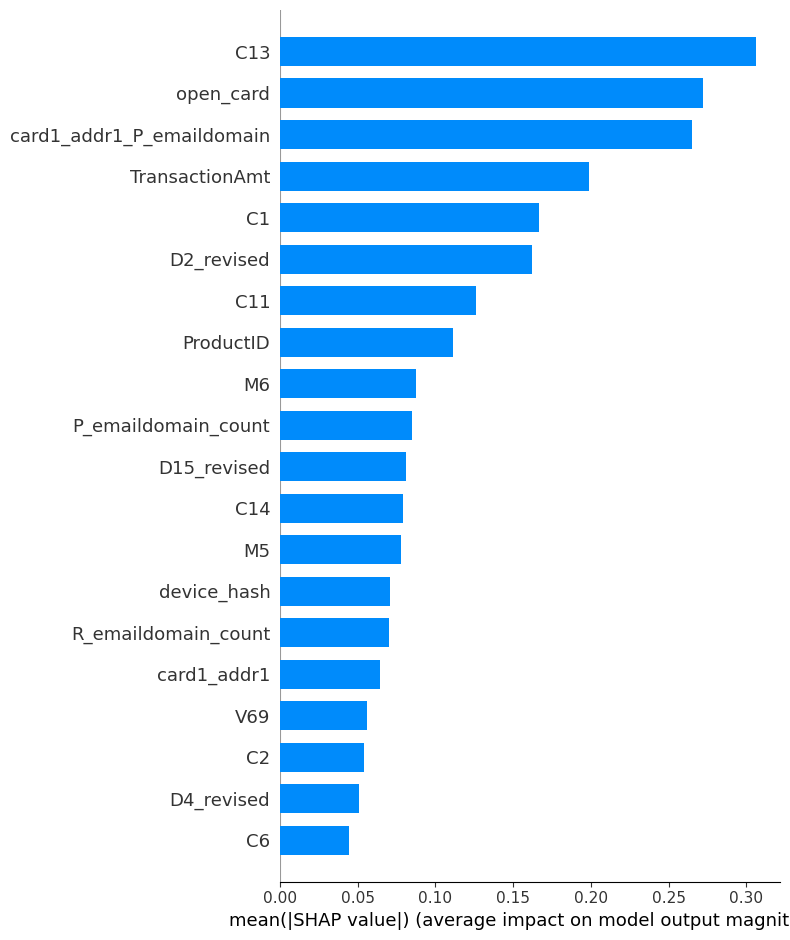

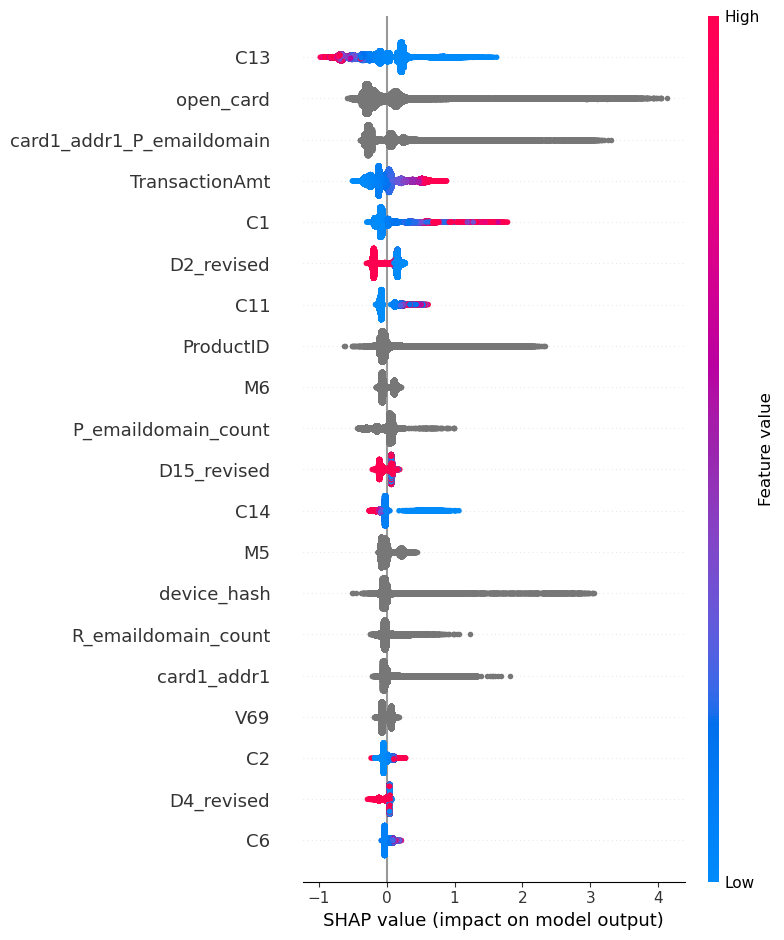

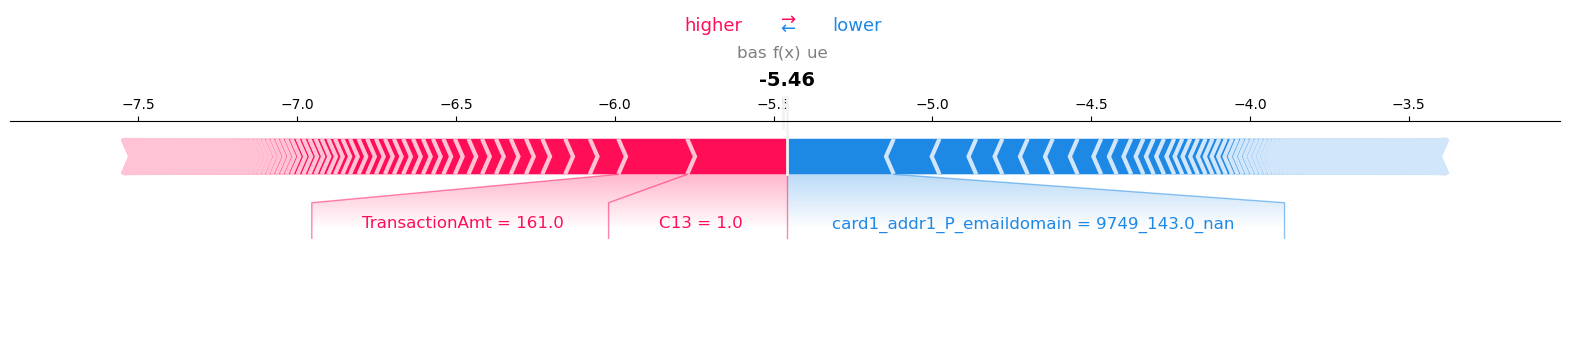

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")
shap.summary_plot(shap_values, X_val)  # dot plot

i = 0  
shap.force_plot(explainer.expected_value, shap_values[i], X_val.iloc[i], matplotlib=True)


Force plot for predicted positive sample index: 4257 | predicted_proba: 0.931


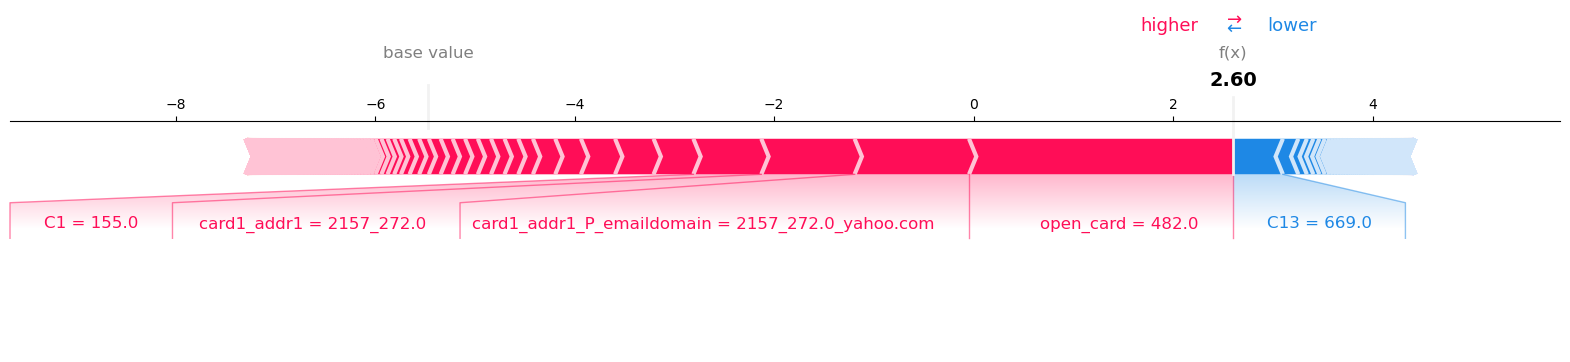

Force plot for predicted positive sample index: 79254 | predicted_proba: 1.000


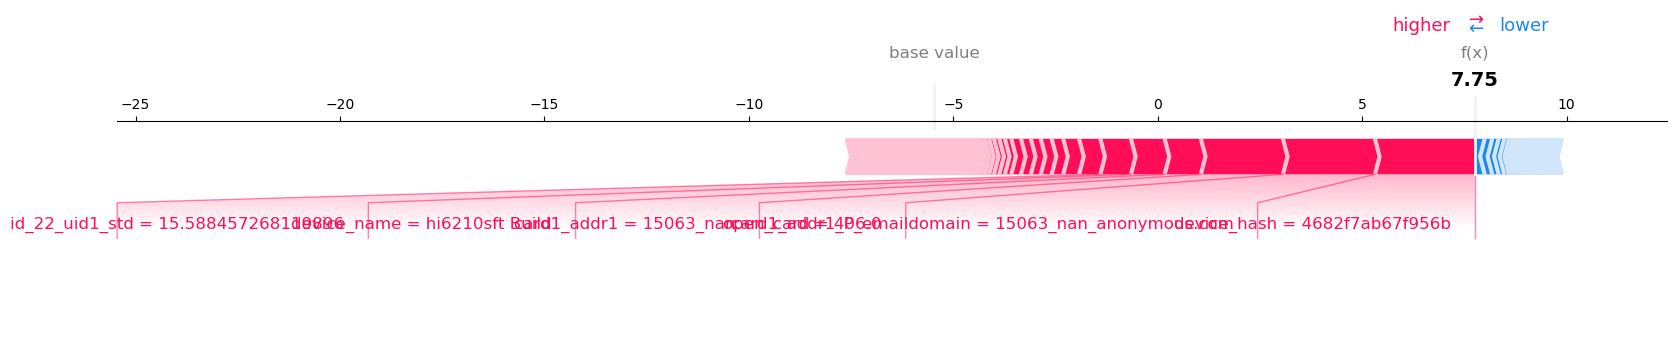

Force plot for predicted positive sample index: 29238 | predicted_proba: 0.819


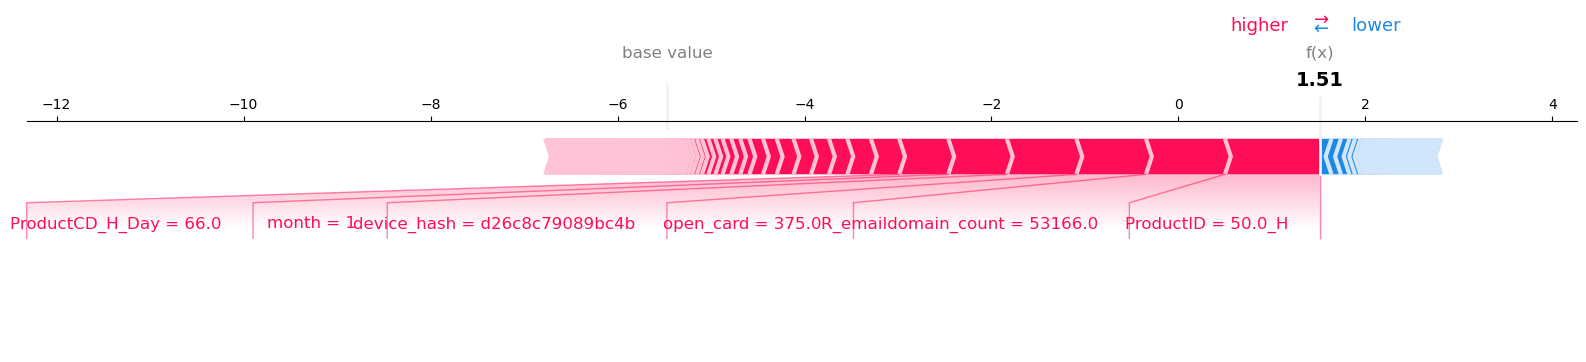

Force plot for predicted positive sample index: 89994 | predicted_proba: 0.997


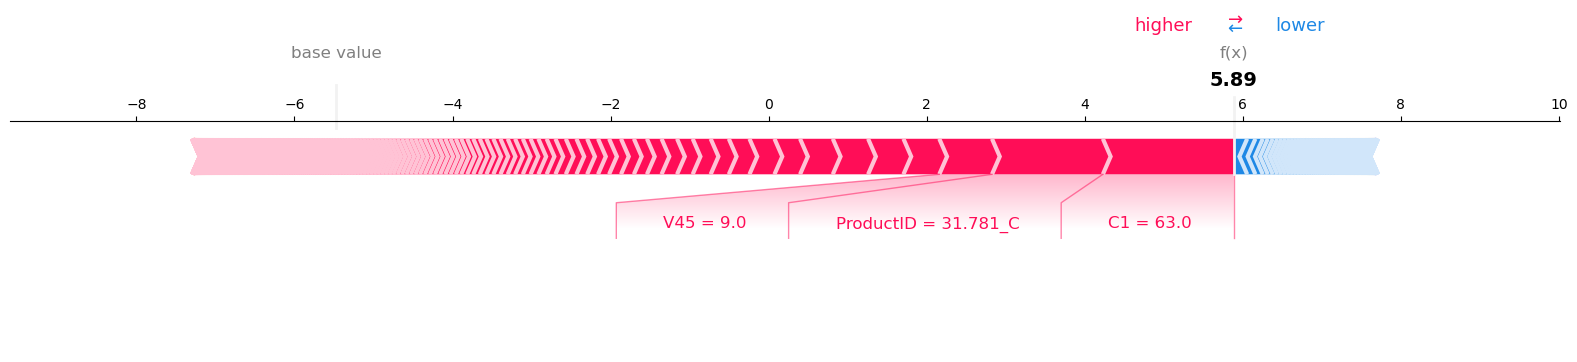

Force plot for predicted positive sample index: 76390 | predicted_proba: 1.000


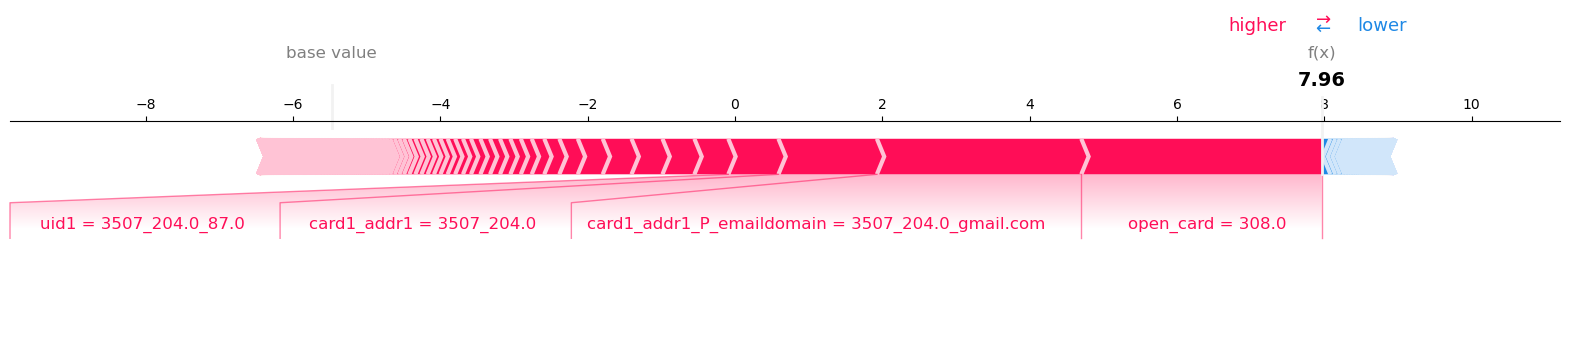

Force plot for predicted positive sample index: 59976 | predicted_proba: 1.000


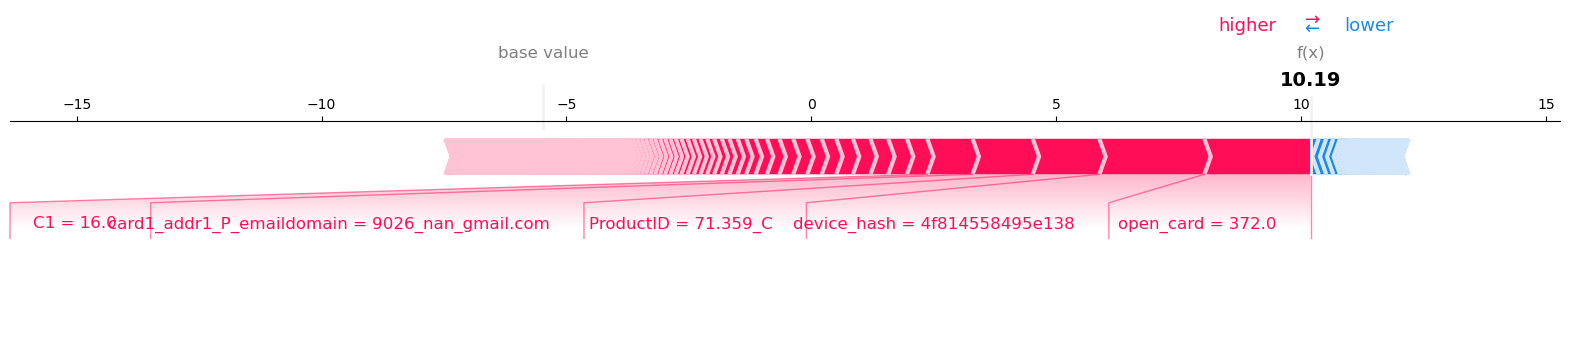

Force plot for predicted positive sample index: 32763 | predicted_proba: 0.677


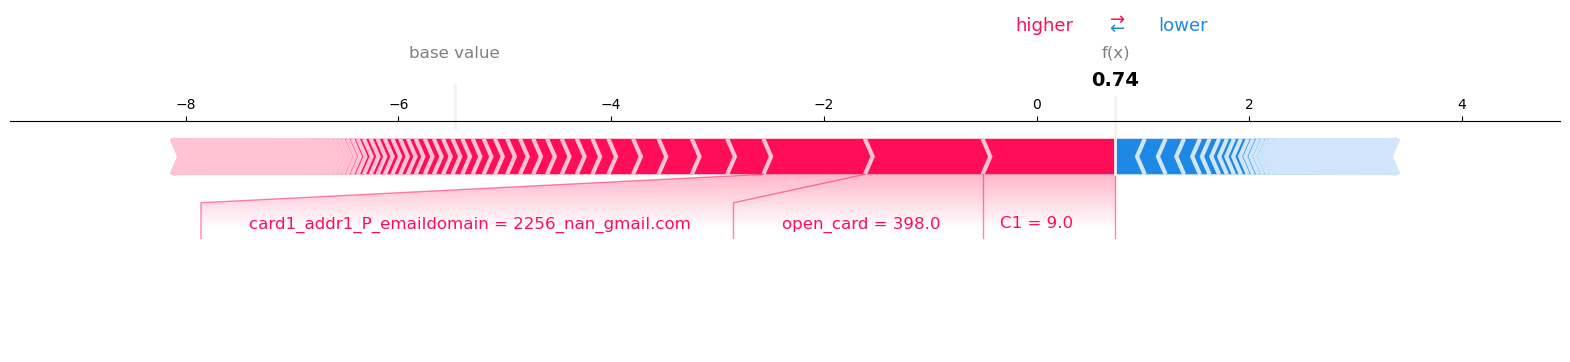

Force plot for predicted positive sample index: 64134 | predicted_proba: 1.000


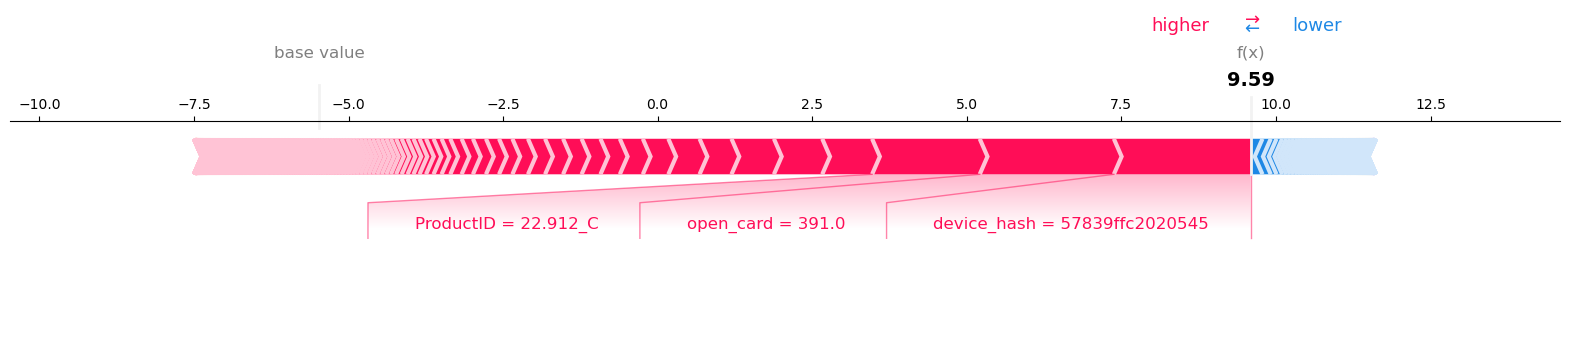

Force plot for predicted positive sample index: 83185 | predicted_proba: 0.974


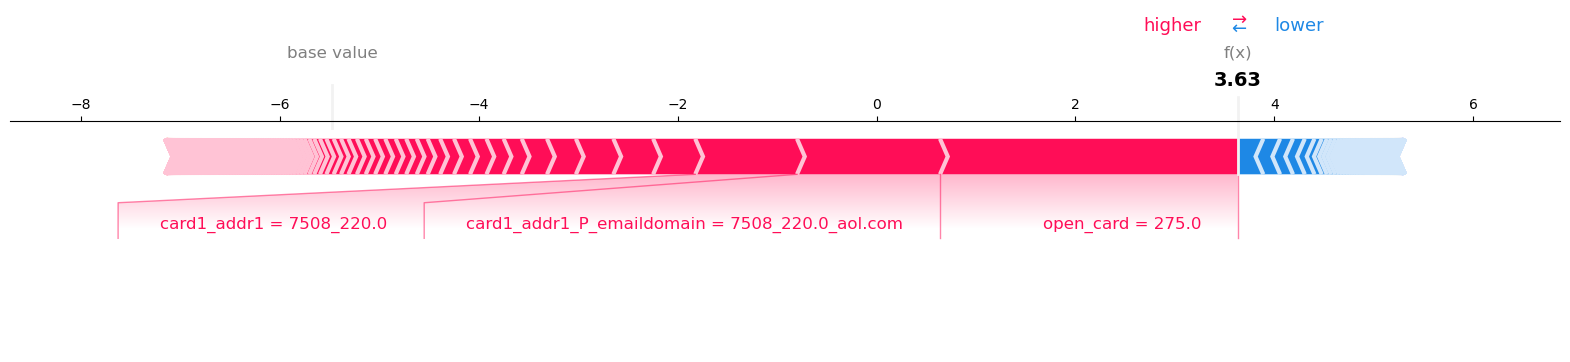

Force plot for predicted positive sample index: 40785 | predicted_proba: 0.963


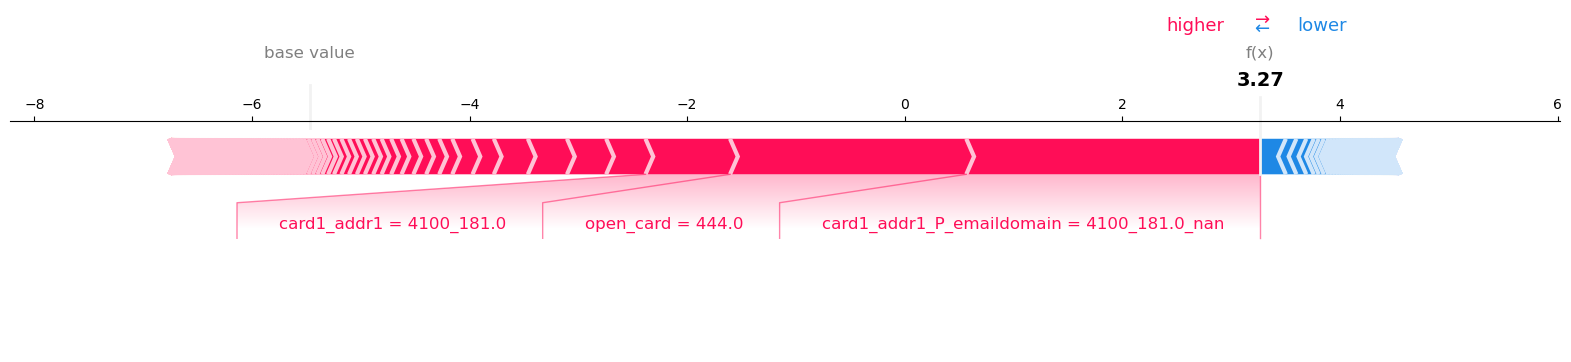

In [35]:
import numpy as np
import shap
import random

y_val_pred_proba = final_model.predict_proba(X_val)[:, 1]
predicted_positive_indices = np.where(y_val_pred_proba >= 0.5)[0]

num_to_plot = min(10, len(predicted_positive_indices))
selected_indices = random.sample(list(predicted_positive_indices), num_to_plot)

for i in selected_indices:
    print(f"Force plot for predicted positive sample index: {i} | predicted_proba: {y_val_pred_proba[i]:.3f}")
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[i],
        features=X_val.iloc[i],
        matplotlib=True
    )


Common High-Risk Features pushing prediction toward Fraud:
- open_card (number of opened cards) appears frequently with high values: 385.0, 439.0, 498.0, 374.0, 397.0
- recommend close monitoring of behaviors involving unfamiliar devices (device_hash), high numbers of opened cards, and specific combinations of email domains and address fields.
- Composite features such as ProductID, C1, C13, card1_addr1_P_emaildomain, and uid1 appear often and have strong positive contributions

Feature Interactions:
- Many fraud predictions are driven by combinations of features like card1 + emaildomain + open_card, or uid1 + addr1 + device_hash
- Some features have small individual impact but become powerful together

Model
- The SHAP visualizations confirm that the model relies on a diverse set of features with stable influence patterns in high-confidence predictions, rather than overfitting to a single feature.



In [29]:
# X_test = test_df[X_train.columns] 
# y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]  

# test_df["isFraud"] = y_pred_proba  
# test_df[["TransactionID", "isFraud"]].to_csv("prediction_results_catboost.csv", index=False)

Leaderboard Score
- Public Score : 0.94
- Private Score : 0.92